# Artificial Intelligence in Medical Imaging 2024

This Jupyter notebook is part of the course Artificial Intelligence in Medical Imaging (AIMI) from Radboud University (Nijmegen, The Netherlands), and it was developed by researchers of Radboud University Medical Center (Nijmegen, The Netherlands).

You should have obtained this notebook by downloading it from the official Brightspace page of the course.

This notebook formulates an assignment as part of the AIMI course, and the content of this notebook should be used solely to develop a solution to this assignment. You should not make the code provided in this notebook, or your solution, publicly available.

## Teaching Assistants

* Fazael Ayatollahi (Fazael.Ayatollahi@radboudumc.nl)
* Lars Leijten (Lars.Leijten@radboudumc.nl)
* Rianne Weber (Rianne.Weber@radboudumc.nl)
* Vilma Bozgo (Vilma.Bozgo@radboudumc.nl)

For questions about the assignments that go beyond the content, you can contact Joeran Bosma. Questions about the content are addressed in the tutorial sessions. You are also encouraged to use the Brightspace discussion forums to discuss the content of the assignments. We will also keep an eye out there to help!

## Guidelines and instructions
Make sure you write code in any place that says "YOUR CODE HERE" by substituting `None` variables or by adding your own solution. Make sure you write in any place that says "YOUR ANSWER HERE" with your answers to the questions.

Please **do not delete or add any cells**. This breaks the grading system and requires you to copy your answers in a clean notebook.

Before you turn this problem in, make sure everything runs without errors. The easiest way to check this is to restart the kernel and run all cells (in the menubar, select Runtime$\rightarrow$Restart & Run All).

* Groups: You should work in **groups of 2 or 3 people**.
* You are expected to work in **Google Colab**. If you run the notebooks locally, you may have to solve some issues yourself!
* Submit your **fully executed** notebook to Brightspace with file name format: `GroupN_NameSurname1_NameSurname2_NameSurname3.ipynb`
* The deadlines for all assignments are on Brightspace.
* Deadlines are soft, but make an effort to be on time. We prioritise feedback on assignments that are handed in before the deadline.
* Each assignment has 100 points, your grade is your total number of points divided by 10.
* The assignments are mandatory, but **do not count** towards your final grade for the course.
<!-- * For assignments where you have to submit to grand-challenge.org, use team name format `ismi-GroupN-nickname1`.-->
* When working with Google Colab, we advise you to download model checkpoints (.h5 files). This way you don't lose your checkpoint if your session times out. Also, don't forget to connect to a **GPU runtime** when training neural networks!
* In Google Colab, you can mount your Google Drive to save files, by clicking the Folder icon on the left, and then click the Mount Drive icon.

There are more detailed instructions on Brightspace on how to use Google Colab for the assignments. You can find it here: https://brightspace.ru.nl/d2l/le/content/426986/Home

## Students
Please fill in this cell with your names, e-mail address and s-numbers. This information will be used to grade your assignment.

* Adam Farrag, s1073320, adam.farrag@ru.nl
* Michael Cornelisse, s1059020, michael.cornelisse@ru.nl
* Charissa Wolff, s1052414, charissa.wolff@ru.nl

--------
# Vessel segmentation in retina fundus images
<img width="250" height="250" align="right" src="https://diagnijmegen.github.io/ismi-course/images/assignment5/images/21_training.png">
In this assignment we will return to the taks of segmentation of vessels in retina fundus images from assignment 2. This time however, we will solve the problem using deep learning. More specifically, we will explore different **fully convolutional neural networks** and **U-Net**.

## Data
For this assignment we will use data from the publicly available DRIVE dataset (https://www.dropbox.com/scl/fo/2y1tt4t7l939d37w6diyx/AC2PXSmqEBJUR1n1zFIbrE4?rlkey=5lqh1o0h22l08vpyjcddfjs8x&e=1&dl=0).
The DRIVE dataset consists of 40 images, 20 used for training and 20 used for testing. Each case contains:
* a fundus (RGB) image
* a binary mask, which indicates the area of the image that has to be analyzed (removing black background)
* manual annotations of retinal vessels, provided as a binary map

## Imports
Let's get started by importing libraries needed for this assignment:

In [ ]:
!pip3 install -q --upgrade ismi_utils
!pip install imagecodecs
!pip3 install torchsummary

In [ ]:
import os
from typing import Optional

# import libraries
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"

import random
import shutil
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import torch
import torch.nn as nn
from ismi_utils import download_data
from PIL import Image
from tqdm import tqdm

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 12)

In [ ]:
'''Please insert here your teamname'''
TeamName = ''

## Download the data

In [ ]:
network_dir = Path('.')

In [ ]:
assignment_name = "assignment_5.zip"
download_data(assignment_name, link="https://surfdrive.surf.nl/files/index.php/s/Kn4hCF4G919ijr3/download")
data_folder = Path('./DRIVE')

100%|██████████| 28.0M/28.0M [00:03<00:00, 7.53MB/s]


------------
# Part 1: Fully convolutional neural networks
In previous assignments we've seen how neural networks can be applied to classify images into different categories. In this assignment we will explore how the same techniques can be applied to a segmentation task. For segmentation we conceptually solve the same taks as for classification: we can extract a patch around every pixel, and then classify the patch and assign the output back to the pixel location. As you can imagine, many classification steps have to be done to segment a full image: we will be working with images of size 584x565 (329,960 pixels), so that would mean we have to apply 329,960 classification steps to segment the full image.

However, when we move our patch by one pixel to classify the next pixel, a large proportion of the pixels of the new patch are identical to the previous patch, and we will be applying the same convolutions many times over. A trick to obtain a label for all pixels efficiently is to define a network architecture that does not include a fully connected (or dense) part. As the network only contains convolutional filters, the spatial structure is kept intact. Therefore the whole network can be thought of as a single large convolutional filter that can be applied to the whole image at once. This speeds up the classification and allows full image segmentation in milliseconds!

During training the same trick can be applied: use a full image as input, and train on all pixel-labels synchronously. In this assignment however, we will initially train the network on patches extracted from random locations in the training data.
There are several reasons why this could be useful. To name a few:
* In some applications you don't have a label for all pixels, so patches are a necessity.
* Less memory is needed during training, which may speed up training time dramatically.
* Per training iteration we can use patches from different source images, and apply augmentations on a patch-base, which increases diversity during training, leading to faster convergence and better results.
* We could design a sampling strategy so that regions of interests could be seen more often during training. It is also a way to control class balance during training.

## Tasks
The tasks you have to perform in Part 1 of this assignment are:
1. Create a patch extractor and a batch creator to generate training data for the network.
2. Implement and train a fully convolutional neural network.
3. Use dilated convolutions.

## Create a training and validation set
We will load all training images into memory, and then divide them into two sets: one (called the **training set**) to optimize the weights of the network, and one (**validation set**) to monitor the performance of the network on unseen data.

In [ ]:
def get_file_list(path, ext=''):
    path = Path(path)
    return sorted(path.glob(f"*{ext}"))

def load_img(path) -> np.ndarray:
    """Load an image from disk as a numpy array
    Make sure the image is in RGB format (3 channels) ordered as (height, width, channels),
    or binary format (1 channel) ordered as (height, width, 1)
    """
    img = skimage.io.imread(path)
    if img.ndim == 2:
        img = np.expand_dims(img, -1)
    elif img.shape[0] <= 3:
        img = np.moveaxis(img, 0, -1)
    return img


In [ ]:
train_img_files = get_file_list(data_folder / 'training' / 'images', '.tif')
train_msk_files = get_file_list(data_folder / 'training' / 'mask', '.gif')
train_lbl_files = get_file_list(data_folder / 'training' / '1st_manual', '.gif')

# train_img_files
train_imgs = [load_img(f) for f in train_img_files]
train_msks = [load_img(f) for f in train_msk_files]
train_lbls = [load_img(f) for f in train_lbl_files]

# we also load test image and masks, to be used later
test_img_files = get_file_list(data_folder / 'test' / 'images', '.tif')
test_msk_files = get_file_list(data_folder / 'test' / 'mask', '.gif')

test_imgs = [load_img(f) for f in test_img_files]
test_msks = [load_img(f) for f in test_msk_files]

print( "loading finished")

loading finished


Define how many images will be used for validation:

In [ ]:
# Define the number of validation images here:
n_validation_imgs = None

# YOUR CODE HERE
n_validation_imgs = int(len(train_imgs) * 0.2)

In [ ]:
"""DO NOT MODIFY THIS CELL"""

'DO NOT MODIFY THIS CELL'

Now we define a class ```DataSet``` that will be used to handle training and validation datasets:

In [ ]:
class DataSet:

    def __init__(self, imgs, msks, lbls=None):
        self.imgs = imgs
        self.msks = msks
        self.lbls = lbls

    def __post_init__(self):
        if len(self.imgs) != len(self.msks):
            raise ValueError("The number of images and masks should be the same")
        if self.lbls is not None and len(self.imgs) != len(self.lbls):
            raise ValueError("The number of images and labels should be the same")
        if len(self.imgs) == 0:
            raise ValueError("No images were provided!")

    def show_image(self, i):
        if self.lbls is not None:
            f, axes = plt.subplots(1, 3)
            for ax, im, t in zip(axes,
                                 (self.imgs[i], self.msks[i], self.lbls[i]),
                                 ('RGB image', 'Mask','Manual annotation')):
                ax.imshow(im, cmap='gray')
                ax.set_title(t)
        else:
            f, axes = plt.subplots(1, 2)
            for ax, im, t in zip(axes,
                                 (self.imgs[i], self.msks[i]),
                                 ('RGB image', 'Mask')):
                ax.imshow(im, cmap='gray')
                ax.set_title(t)
        plt.show()

In [ ]:
# use the first images as validation
validation_data = DataSet(train_imgs[:n_validation_imgs], train_msks[:n_validation_imgs], train_lbls[:n_validation_imgs])

# the rest as training
train_data = DataSet(train_imgs[n_validation_imgs:], train_msks[n_validation_imgs:], train_lbls[n_validation_imgs:])


Let's inspect some of the loaded images:

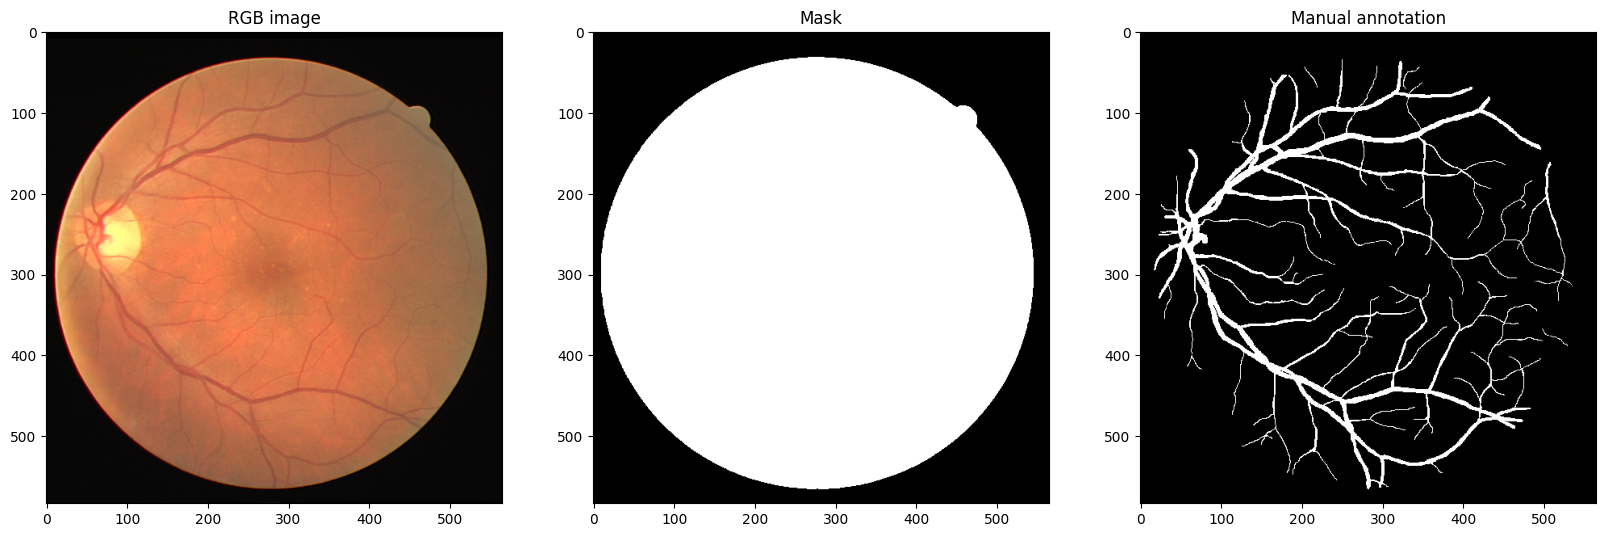

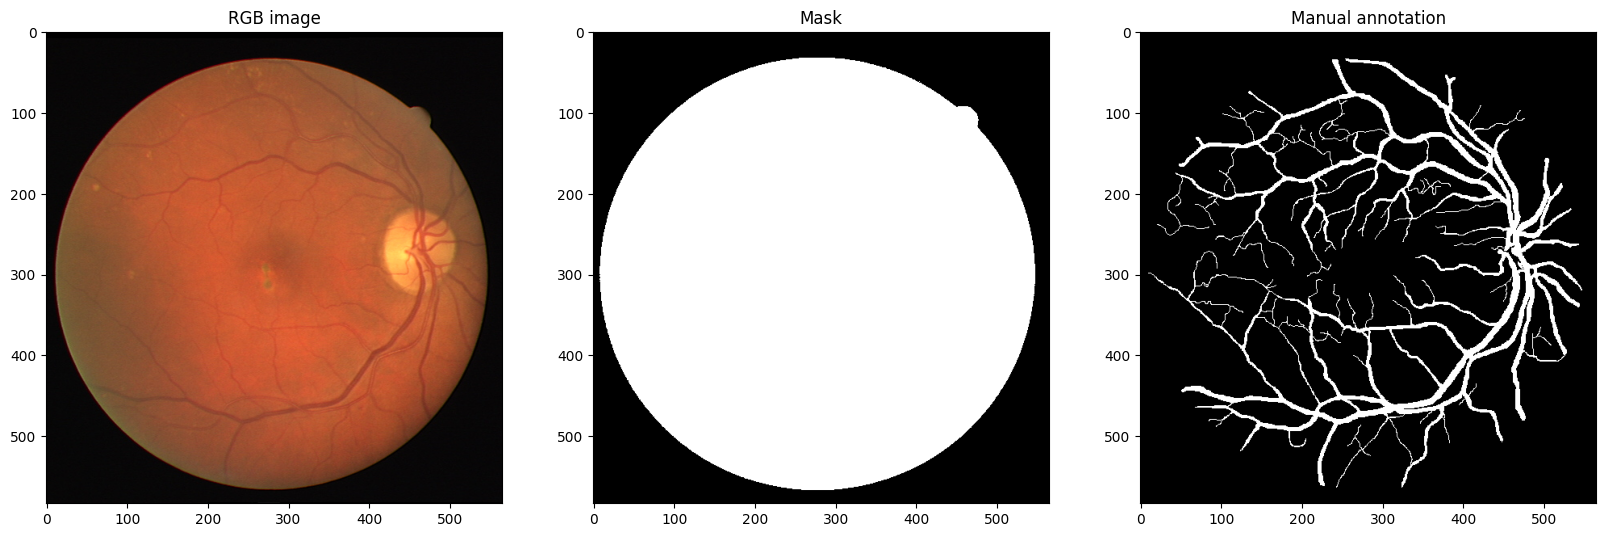

In [ ]:
matplotlib.rcParams['figure.figsize'] = (20, 12)
validation_data.show_image(0) # change this parameter to try a few images
train_data.show_image(0) # change this parameter to try a few images

## Build a patch extractor

In this assignment we are going to implement a ```PatchExtractor``` class, which extract random patches from a list of images.
This means that you don't need to create a dataset beforehand and then use it to train you network, but you will just have a list of training images and annotation segmentations available, and patches will be extracted **on-the-fly** during training. For each example, you will need to generate an image patch and a corresponding label patch (patch with segmentation annotation) given a patch center location (y, x) and a predefined patch size (h, w). The generated image and label patches should have the same dimension.
This strategy allows to save time in the preparation of your *static* dataset, and allows the use of a *dynamic* generation of batches, where data augmentation can also be applied on-the-fly.

Note that this approach allows to test different strategies of data augmentation without the need for making a new dataset from scratch all the time. For now, we will only implement one kind of data augmentation in the ```get_patch``` method: **horizontal flipping**. The event will occur at random such that for each patch location, there is a 50% chance it gets flipped.

In [ ]:
class PatchExtractor:

    def __init__(self, patch_size, horizontal_flipping=True):
        self.patch_size = patch_size
        # Doing this to ensure we keep odd sizes caused a lot if issues for me with the U-net
        # Easiest solution is to just set odd patch sizes ourselves.
        #self.patch_size = (
        #    patch_size[0] if patch_size[0] % 2 == 1 else patch_size[0] + 1,
        #    patch_size[1] if patch_size[1] % 2 == 1 else patch_size[1] + 1
        #)
        self.horizontal_flipping = horizontal_flipping

    def get_patch(self, image, mask, location):
        '''
        image: a numpy array representing the input image,
        mask: a numpy array representing the corresponding segmentation annotation
        location: a tuple with an y and x coordinate

        return a patch from the image at `location`, representing the center of the patch, and the corresponding label patch
        if self.horizontal_flipping = True, there is a 50% chance the patch is horizontally flipped
        '''
        y, x = location
        py, px = self.patch_size

        # - patch should be a numpy array of size <h, w>
        # - the patch should be normalized (intensity values between 0-1)

        img_patch = None
        label_patch = None
        # YOUR CODE HERE
        y1, y2 = y - py // 2, y + py // 2 + 1
        x1, x2 = x - px // 2, x + px // 2 + 1
        img_patch = image[y1:y2, x1:x2]
        img_patch = img_patch / 255 # Normalize img patches
        label_patch = mask[y1:y2, x1:x2]

        # - if self.flipping = True, there should be a 50% chance to apply a horizontal flip to the patch
        if self.horizontal_flipping:
            do_flipping = None

            # YOUR CODE HERE
            do_flipping = np.random.rand() < 0.5  # 50% chance

            # - if do_flipping == True, flip the patch horizontally
            if do_flipping:
                img_patch_flipped = None
                label_patch_flipped = None

                # YOUR CODE HERE
                img_patch_flipped = np.fliplr(img_patch)
                label_patch_flipped = np.fliplr(label_patch)

                img_patch = img_patch_flipped
                label_patch = label_patch_flipped

        assert img_patch.ndim == label_patch.ndim
        return img_patch, label_patch

In [ ]:
'''DO NOT MODIFY THIS CELL'''



'DO NOT MODIFY THIS CELL'

Let's test our patch extractor! By repeatedly executing the cell below, you should be able to see different augmentations of the same patch. The dot in the images represents the center of the patch, which is the pixel we are going to classify.

In [ ]:
patch_size = (None, None) # Set the size of the patches as a tuple (height, width), make sure they are odd numbers

img_index = None # choose an image to extract the patch from
location = (None, None) # define the location of the patch (y, x) - coordinate

# YOUR CODE HERE
patch_size = (11, 11)  # Example patch size (65, 65), odd numbers
img_index = 0  # Choose the first image in the training dataset
location = (150, 150)  # Example location (y, x) within the image

In [ ]:
'''DO NOT MODIFY THIS CELL'''

'DO NOT MODIFY THIS CELL'

Text(0.5, 1.0, 'mask at (150, 150)')

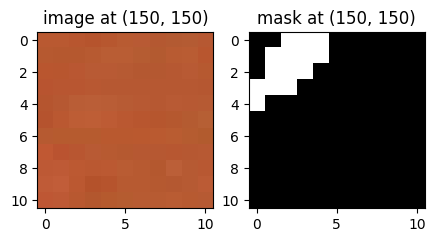

In [ ]:
patch_extractor_train = PatchExtractor(patch_size=patch_size, horizontal_flipping=True)

matplotlib.rcParams['figure.figsize'] = (5, 5)
image_patch, label_patch = patch_extractor_train.get_patch(train_data.imgs[img_index], train_data.lbls[img_index], location)
label_patch = np.repeat(label_patch, 3, axis=-1)
f, axes = plt.subplots(1, 2)
axes[0].imshow(image_patch)
axes[0].set_title('image at {}'.format(location))
axes[1].imshow(label_patch)
axes[1].set_title('mask at {}'.format(location))

## Build a dataset of patches

The PatchDataset will allow us to build a dataset of generated patches to train on. These patches contain a set of (class-balanced) samples or patches, and their corresponding labels. The data returned by the ```PatchDataset``` can be used in the PyTorch framework to create batches for training, which in turn can be fed into the neural network for training or classification.

First we define a useful function for padding images with a zero-border:

In [ ]:
def pad(images, patch_size):
    '''
    images: list of images (numpy arrays)
    returns a padded version of the images, with a border of half the patch_size around each image
    '''
    half_py, half_px = [p//2 for p in patch_size]
    paddings = ((0, 0), (half_py, half_py), (half_px, half_px), (0, 0))
    return np.pad(np.array(images), pad_width=paddings, mode='constant')


Now, implement the ```__getitem__``` method in the ```PatchDataset``` class. It should return the patches and labels (```x_data``` and ```y_data```) where ```x_data``` denotes the image patch, and ```y_data``` the corresponding labels. The idea is to predict whether a pixel is vessel or not by feeding the image patch surrounding the pixel to the network. So here the labels are the one-hot encoding class vectors for the pixels at the patch center. Previously, you have implemented a patch extractor that gives you an image and label patch. You should be able to compute the pixel labels at patch center from the label patch.
We also provide you an implementation of a class balanced patch location sampler, which will compute locations to extract patches such that half of the locations are foreground pixels (vessels) and the other half of the locations are background pixels (inside the fundus mask, but not vessels).  

In [ ]:
class BalancedSampler:

    def __init__(self, lbls, msks):
        # pre calculate the positive and negative indices
        lbls = np.squeeze(lbls, 3)
        msks = np.squeeze(msks, 3)
        self.p_idxs = np.asarray(np.where((msks > 0) & (lbls > 0))).T.tolist()
        self.n_idxs = np.asarray(np.where((msks > 0) & (lbls == 0))).T.tolist()

    def generate_sample_locations(self, batch_size):
        # generate locations half from the positive set and half from the negative set
        if batch_size % 2 != 0:
            raise RuntimeError("batch_size should be even")
        p_locations = random.sample(self.p_idxs, batch_size // 2)
        n_locations = random.sample(self.n_idxs, batch_size - batch_size // 2)
        locations = np.vstack([p_locations, n_locations])
        return locations


In [ ]:
class PatchDataset(torch.utils.data.Dataset):

    def __init__(self, patch_extractor, dataset, border_pad_size, batch_size):
        self.patch_extractor = patch_extractor

        # the images are padded with half the patch-size around the border
        # this way, we don't risk extracting patches from the border, that extend beyond the original image
        self.imgs = pad(dataset.imgs, border_pad_size)
        self.lbls = pad(dataset.lbls, border_pad_size)
        self.msks = pad(dataset.msks, border_pad_size)
        self.patch_location_sampler = BalancedSampler(self.lbls, self.msks)
        self.batch_size = batch_size

    def __len__(self):
        # Note: take the max of the length of the images and the batch_size to allow batches larger than the number of images
        return max(len(self.imgs), self.batch_size)

    def __getitem__(self, index):
        '''generate a sample from the dataset'''
        # sample a random image and location
        locations = self.patch_location_sampler.generate_sample_locations(2)
        index = np.random.randint(0, 2)
        i, y, x = locations[index]

        image_patch = None
        label_patch = None

        # YOUR CODE HERE
        image_patch, label_patch = self.patch_extractor.get_patch(
            self.imgs[i], self.lbls[i], (y, x)
        )

        # get the label at the center of the patch
        if label_patch.shape[0] % 2 == 0 or label_patch.shape[1] % 2 == 0:
            raise ValueError("label_patch should have an odd size in both dimensions to have a single center pixel")

        label = (label_patch[label_patch.shape[0] // 2, label_patch.shape[1] // 2, 0] > 0)

        # convert mask to a one-hot encoded classification label
        label = np.eye(2)[int(label)]

        # move the color channel to the first dimension
        image = np.moveaxis(image_patch, -1, 0).copy()

        # add two dummy dimensions to the label for compatibility with pytorch
        label = np.expand_dims(np.expand_dims(label, -1), -1)

        return image, label

In [ ]:
'''DO NOT MODIFY THIS CELL'''


'DO NOT MODIFY THIS CELL'

Let's test our PatchDataset! Half of the patches in the visualization below should represent vessel patches (having a vessel in the center of the patch). The other half should represent background patches (no vessel in the center of the patch). The dot in the images represents the center of the patch, which is the pixel we are going to classify.

x_data.shape=torch.Size([20, 3, 11, 11]), y_data.shape=torch.Size([20, 2, 1, 1])


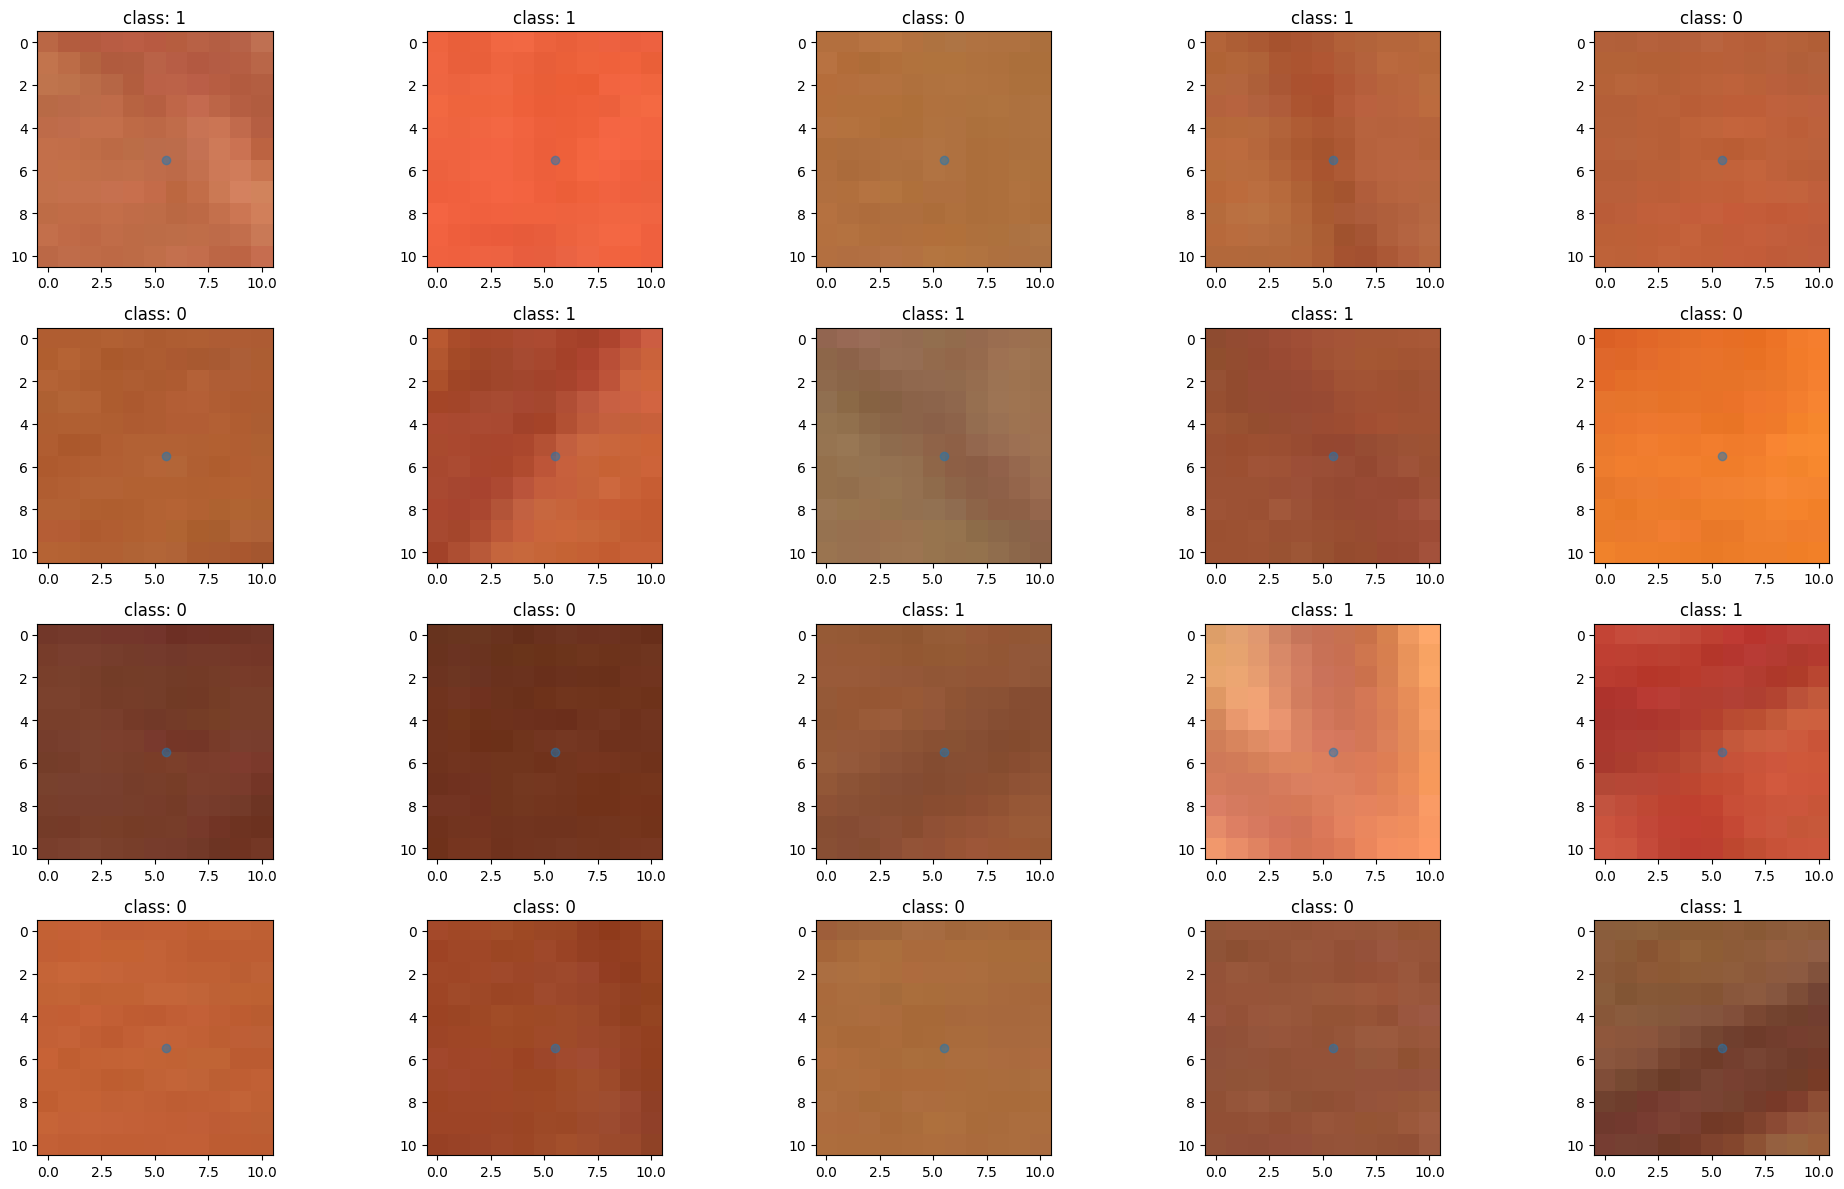

In [ ]:
nrows, ncols = 4, 5
batch_size = nrows * ncols
patch_dataset_train = PatchDataset(patch_extractor=patch_extractor_train, dataset=train_data, border_pad_size=patch_extractor_train.patch_size, batch_size=batch_size)
dataloader_train = torch.utils.data.DataLoader(patch_dataset_train, batch_size)

# create a batch of images and labels from the training set for visualization
for x_data, y_data in dataloader_train:
    print(f"x_data.shape={x_data.shape}, y_data.shape={y_data.shape}")

    # visualize it
    f, axes2d = plt.subplots(nrows, ncols, figsize=(20, 12))
    for i, ax in enumerate(np.ravel(axes2d)):
        ax.imshow(np.moveaxis(x_data[i].numpy(), 0, -1))
        ax.scatter(*[p/2 for p in patch_extractor_train.patch_size], alpha=0.5)
        ax.set_title(f'class: {np.argmax(y_data.numpy()[i])}')
    plt.tight_layout()
    plt.show()
    break


## Build and train the first fully convolutional network

We will now start with defining our initial network architecture in PyTorch. What is important to train a fully convolutional neural network on patches, is that **the size of the feature maps within the network goes down to exactly 1x1 for the final feature map**.
We will therefore use **valid** convolutions (in contrast to **same** convolutions) and pooling operations to reduce the size of the feature maps.
This requires some computation, but luckily it is pretty straightforward:  

If we define:
```
i = Input featuremap size
o = Output featuremap size
f = Convolution filter size
m = Pooling size
```
Then:

Output size of a feature map after convolution with a convolution filter of size f:
```python
o = i - (f - 1)
```
Output size of a feature map after pooling of size m:
```python
o = floor(i/m)
```

### Model definition
Let's define a baseline model:
* input layer
* 32 filters of 4x4
* 32 filters of 3x3
* pooling
* 64 filters of 3x3
* 64 filters of 3x3
* pooling
* 128 filters of 3x3
* 64 filters of 1x1
* 2 filters of 1x1

After every convolution we will apply a **ReLU** non-linearity. The last layer should have a **softmax** non-linearity to transform the 2 filters in probabilities for the vessel and background class.  

The reason to start with the less common 4x4 convolutions, is that we wish to define a patch-size that has an odd number of pixels (so that we can define a single center pixel that corresponds with the label). At the same time, we want the input to the pooling layers to be even, so we don't exclude the pixels around the border. The 1x1 convolutions in the deeper layers act as the dense part of a classification network: we no longer take contextual information into account, but only do recombination of features. The final two filters represent the two classes background and vessel.


In [ ]:
def count_params(network):
    return sum(p.numel() for p in network.parameters())

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = None
        self.conv2 = None
        self.conv3 = None
        self.conv4 = None
        self.conv5 = None
        self.conv6 = None
        self.conv7 = None
        self.pool = None
        self.relu = None

        # YOUR CODE HERE
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, padding='valid')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding='valid')
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='valid')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='valid')
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding='valid')
        self.conv6 = nn.Conv2d(128, 64, kernel_size=1, padding='valid')
        self.conv7 = nn.Conv2d(64, 2, kernel_size=1, padding='valid')

        self.pool = nn.MaxPool2d(2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Perform the forward pass of your network.

        Args:
            x (torch.Tensor): Input tensor to the network.

        Returns:
            torch.Tensor: Output tensor from the network.
        """
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.conv7(x)
        return x

In [ ]:
network = Model()
print(network)
print(f"Number of parameters: {count_params(network)}")

Model(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=valid)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=valid)
  (conv7): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1), padding=valid)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)
Number of parameters: 148482


In [ ]:
# '''DO NOT MODIFY THIS CELL'''


## Define the training method

For this assignment we will use the cross-entropy loss (sometimes also referred to as log-loss). In this case it is equivalent to the mean log of the differences between true labels and the predicted labels for a given batch. Below we define a Trainer class that can train a network given the network, optimizer, loss function, a name for saving, and the batch size.

In [ ]:
class Trainer():

    def __init__(self, network, optimizer, loss_function, name, batch_size):
        """
        Make training set
        Notes:
          * network - The network you have created before, should be a nn.Module()
          * optimizer - The optimizer you have created before.
          * loss_function - The crossentropy loss function
          * name: To identify which model came from which task, you can give your models
          a name so you can distinguish them later on. Give them clear distinguishable names to make it easy for yourself
        """

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.network = network.to(self.device)
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.name = name
        self.network_filepath = network_dir / f'{name}_best_model.pt'
        self.running_train_loss = []
        self.runnin_val_loss = []
        self.running_train_acc = []
        self.running_val_acc = []
        self.best_val_loss = np.inf
        self.batch_size = batch_size

    def train_network(self, train_data, val_data, steps_per_epoch, epochs):
        # Contains the code to train the network and calculate performance metrics

        for epoch in tqdm(range(epochs), position=0, leave=False, desc="Epochs"):

            self._train_one_epoch(train_data, steps_per_epoch=steps_per_epoch)

            """
            EXERCISE: Evaluate the network on the training and validation set.
            Uncomment the following lines of Python and replace the None value
            within the function to calculate the training and validation performance.
            """

            # Get training loss and accuracy
            #train_loss, train_acc = self.validate_dataset(None)

            # Get validation loss and accuracy
            #val_loss, val_acc = self.validate_dataset(None)

            # YOUR CODE HERE
            # Get training loss and accuracy
            train_loss, train_acc = self.validate_dataset(train_data)

            # Get validation loss and accuracy
            val_loss, val_acc = self.validate_dataset(val_data)

            tqdm.write(f"Epoch {epoch}: train loss: {train_loss}, train accuracy: {train_acc}, val loss: {val_loss}, val accuracy: {val_acc}")

            self.running_train_loss.append(train_loss)
            self.runnin_val_loss.append(val_loss)
            self.running_train_acc.append(train_acc)
            self.running_val_acc.append(val_acc)

            if val_loss < self.best_val_loss:
                # Look up how to save your network
                self.best_val_loss = val_loss
                self._save_best_network()

        self._plot_statistics()

    def _train_one_step(self, dataloader):
        # Set the network to train mode
        self.network.train()
        for x, y in dataloader:
            x = x.float().to(self.device)
            y = y.to(self.device)
            """
            EXERCISE: fill in the right values for y_pred and loss
            """
            y_pred = None
            loss = None

            # YOUR CODE HERE
            y_pred = self.network(x)
            loss = self.loss_function(y_pred, y.float())

            # Optimization step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            break

    def _train_one_epoch(self, dataloader, steps_per_epoch):
        for step in range(steps_per_epoch):
            self._train_one_step(dataloader)

    def validate_dataset(self, dataloader):
        total_loss = 0
        correct = 0

        # Set the network into eval mode (changes how dropout and BN work)
        self.network.eval()

        # perform an evaluation pass
        accuracies = []
        with torch.no_grad():
            for x, y in dataloader:
                x = x.float().to(self.device)
                y = y.to(self.device)

                # Evaluate the model and get the batch loss and predictions
                loss_value, y_pred_class = self._evaluate_batch(x, y)

                # Get the number of correct predictions and accumulate
                batch_accuracy = np.mean((y_pred_class == torch.argmax(y, dim=1)).cpu().detach().numpy())
                accuracies.append(batch_accuracy)

                # Accumulate loss
                total_loss += loss_value.cpu().detach().numpy()

        # The loss is meaned over the batches, to get the proper loss, multiple by the batch size and divide by number of images
        total_loss = (total_loss * dataloader.batch_size) / (dataloader.batch_size * len(dataloader))
        accuracy = np.mean(accuracies)
        return total_loss, accuracy

    def _evaluate_batch(self, x, y):
        # Get logits from the model
        # print(f'Type input: {x.dtype}')
        y_pred = self.network(x)

        # binarize the probabilities to predictions
        y_pred_class = torch.argmax(y_pred, dim=1)

        # Calculate the loss
        # print(f'Prediction: {y_pred.shape}, Label: {y.float().shape}')
        loss_value: torch.Tensor = self.loss_function(y_pred, y.float())

        # print(f'X: {x.shape}, Y: {y.shape}, Y_pred: {y_pred.shape}, Y_pred_class: {y_pred_class.shape}')
        return loss_value, y_pred_class

    def _save_best_network(self):
        torch.save(self.network, self.network_filepath)

    def load_best_network(self):
        self.network = self._load_best_network()

    def _load_best_network(self):
        return torch.load(self.network_filepath, weights_only=False)

    def _predict(self, x):
        self.network.eval()
        with torch.no_grad():
            otp = self.network(x.to(self.device))
        return otp

    def _predict_batch(self, x):
        outputs = []
        for img in x:
            output = self._predict(img)
            outputs.append(output)
        return outputs

    def _plot_statistics(self):
        # Helper function, plots the training and validation curves
        f, ax = plt.subplots(figsize=(10, 5))
        ax.plot(range(len(self.running_train_loss)), self.running_train_loss , 'b', label="training loss")
        ax.plot(range(len(self.runnin_val_loss)), self.runnin_val_loss, 'c', label="validation loss")
        ax.plot(range(len(self.running_train_acc)), self.running_train_acc, 'g', label="training accuracy")
        ax.plot(range(len(self.running_val_acc)), self.running_val_acc, 'r', label="validation accuracy")
        ax.set_xlabel('step')
        ax.set_ylabel('loss')
        ax.legend(loc='best')
        ax.set_title(f'Best validation loss = {self.best_val_loss:.2f}')
        plt.show()


Now you have to define some parameters, which are needed to train your network.
To do validation during training, we need to define the downscaling factor (which we call ```stride```) due to pooling of our network. That is: how much lower is the resolution of the output compared to the input?

To let the network converge to a reasonable state, `steps_per_epoch * epochs` should be around 5000 to 10000

In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [ ]:
patch_size = None              # should be a tuple of width, height corresponding to your network architecture
batch_size = None              # pick a reasonable batch-size (e.g. 32, 64, 128, 256)
steps_per_epoch = None         # how many steps per epoch?
epochs = None                  # how many epochs?
stride = None                  # what is the downscaling factor of your network?


# YOUR CODE HERE
patch_size = (25, 25)
batch_size = 64
steps_per_epoch = 20
epochs = 250
stride = 4

In [ ]:
# '''DO NOT MODIFY THIS CELL'''


What is the correct value for our downsampling factor (stride) and why?

**Aswer:**

We have two maxpool layers of kernel and stride 2, so the downsampling factor is $2 \times 2=4$

Now we use all the classes defined so far to initialize data that will be used for training and validation.

In [ ]:
patch_extractor_train = PatchExtractor(patch_size=patch_size, horizontal_flipping=True)
patch_dataset_train = PatchDataset(patch_extractor=patch_extractor_train, dataset=train_data, border_pad_size=patch_extractor_train.patch_size, batch_size=batch_size)
dataloader_train = torch.utils.data.DataLoader(patch_dataset_train, batch_size)
patch_extractor_val = PatchExtractor(patch_size=patch_size, horizontal_flipping=False)
patch_dataset_val = PatchDataset(patch_extractor=patch_extractor_val, dataset=validation_data, border_pad_size=patch_size, batch_size=batch_size)
dataloader_val = torch.utils.data.DataLoader(patch_dataset_val, batch_size)

# define the trainer
trainer = Trainer(
    network=network,
    optimizer=optimizer,
    loss_function=loss_function,
    name='basic_net',
    batch_size=batch_size,
)


Evaluate the validation set as a sanity check. The loss should be around 0.69.

In [ ]:
# Perform an evaluation pass
loss, accuracy = trainer.validate_dataset(dataloader_val)
print(f"validation loss {loss}, validation accuracy {accuracy}")

validation loss 0.6831918954849243, validation accuracy 0.609375


In [ ]:
# '''DO NOT MODIFY THIS CELL'''


Train the network

Epochs:   1%|          | 2/250 [00:00<00:47,  5.18it/s]

Epoch 0: train loss: 0.6918754577636719, train accuracy: 0.578125, val loss: 0.6941841244697571, val accuracy: 0.5
Epoch 1: train loss: 0.6912007331848145, train accuracy: 0.53125, val loss: 0.6921181678771973, val accuracy: 0.53125


Epochs:   2%|▏         | 4/250 [00:00<00:47,  5.22it/s]

Epoch 2: train loss: 0.6933481693267822, train accuracy: 0.484375, val loss: 0.689972996711731, val accuracy: 0.546875
Epoch 3: train loss: 0.6916036605834961, train accuracy: 0.484375, val loss: 0.6949403285980225, val accuracy: 0.453125


Epochs:   2%|▏         | 6/250 [00:01<00:47,  5.16it/s]

Epoch 4: train loss: 0.6854212880134583, train accuracy: 0.640625, val loss: 0.6923834085464478, val accuracy: 0.53125
Epoch 5: train loss: 0.7164037227630615, train accuracy: 0.4375, val loss: 0.6879950761795044, val accuracy: 0.484375


Epoch 6: train loss: 0.6884859800338745, train accuracy: 0.546875, val loss: 0.6901559829711914, val accuracy: 0.453125


Epochs:   4%|▎         | 9/250 [00:01<00:46,  5.19it/s]

Epoch 7: train loss: 0.6850576400756836, train accuracy: 0.53125, val loss: 0.6896068453788757, val accuracy: 0.4375
Epoch 8: train loss: 0.6918016076087952, train accuracy: 0.59375, val loss: 0.667243242263794, val accuracy: 0.625


Epochs:   4%|▍         | 10/250 [00:01<00:46,  5.21it/s]

Epoch 9: train loss: 0.6866521835327148, train accuracy: 0.546875, val loss: 0.6859984397888184, val accuracy: 0.4375


Epochs:   4%|▍         | 11/250 [00:02<00:46,  5.09it/s]

Epoch 10: train loss: 0.6884552836418152, train accuracy: 0.515625, val loss: 0.6953026652336121, val accuracy: 0.46875


Epochs:   5%|▍         | 12/250 [00:02<00:53,  4.46it/s]

Epoch 11: train loss: 0.6906623244285583, train accuracy: 0.5625, val loss: 0.6875807046890259, val accuracy: 0.625


Epochs:   5%|▌         | 13/250 [00:02<00:58,  4.08it/s]

Epoch 12: train loss: 0.671367883682251, train accuracy: 0.453125, val loss: 0.6781851053237915, val accuracy: 0.53125


Epochs:   6%|▌         | 14/250 [00:02<00:57,  4.09it/s]

Epoch 13: train loss: 0.7007253766059875, train accuracy: 0.390625, val loss: 0.6723261475563049, val accuracy: 0.5


Epochs:   6%|▌         | 15/250 [00:03<00:59,  3.98it/s]

Epoch 14: train loss: 0.6607425212860107, train accuracy: 0.59375, val loss: 0.7016017436981201, val accuracy: 0.59375


Epochs:   6%|▋         | 16/250 [00:03<00:57,  4.04it/s]

Epoch 15: train loss: 0.6891512870788574, train accuracy: 0.484375, val loss: 0.6914311051368713, val accuracy: 0.390625


Epochs:   7%|▋         | 17/250 [00:03<00:59,  3.89it/s]

Epoch 16: train loss: 0.6795620918273926, train accuracy: 0.546875, val loss: 0.687358021736145, val accuracy: 0.53125


Epochs:   7%|▋         | 18/250 [00:04<01:01,  3.76it/s]

Epoch 17: train loss: 0.6844185590744019, train accuracy: 0.4375, val loss: 0.694664478302002, val accuracy: 0.328125


Epochs:   8%|▊         | 19/250 [00:04<01:04,  3.60it/s]

Epoch 18: train loss: 0.6730993986129761, train accuracy: 0.59375, val loss: 0.6901023983955383, val accuracy: 0.40625


Epochs:   8%|▊         | 20/250 [00:04<01:01,  3.74it/s]

Epoch 19: train loss: 0.6913754343986511, train accuracy: 0.421875, val loss: 0.6987236738204956, val accuracy: 0.390625
Epoch 20: train loss: 0.6941419839859009, train accuracy: 0.5, val loss: 0.656182050704956, val accuracy: 0.703125


Epochs:   9%|▉         | 22/250 [00:04<00:53,  4.28it/s]

Epoch 21: train loss: 0.6805565357208252, train accuracy: 0.453125, val loss: 0.6954057216644287, val accuracy: 0.4375


Epochs:   9%|▉         | 23/250 [00:05<00:51,  4.40it/s]

Epoch 22: train loss: 0.6935222148895264, train accuracy: 0.40625, val loss: 0.683817446231842, val accuracy: 0.578125


Epochs:  10%|▉         | 24/250 [00:05<00:50,  4.52it/s]

Epoch 23: train loss: 0.6932293176651001, train accuracy: 0.515625, val loss: 0.6954261064529419, val accuracy: 0.578125
Epoch 24: train loss: 0.6920494437217712, train accuracy: 0.53125, val loss: 0.6834721565246582, val accuracy: 0.515625


Epochs:  11%|█         | 27/250 [00:05<00:45,  4.92it/s]

Epoch 25: train loss: 0.6934424638748169, train accuracy: 0.515625, val loss: 0.6880329847335815, val accuracy: 0.671875
Epoch 26: train loss: 0.692689836025238, train accuracy: 0.5625, val loss: 0.7027952671051025, val accuracy: 0.546875


Epochs:  12%|█▏        | 29/250 [00:06<00:43,  5.06it/s]

Epoch 27: train loss: 0.6962987184524536, train accuracy: 0.4375, val loss: 0.6813984513282776, val accuracy: 0.578125
Epoch 28: train loss: 0.6975051164627075, train accuracy: 0.421875, val loss: 0.6996163129806519, val accuracy: 0.515625


Epochs:  12%|█▏        | 31/250 [00:06<00:42,  5.12it/s]

Epoch 29: train loss: 0.6897467970848083, train accuracy: 0.5, val loss: 0.694466233253479, val accuracy: 0.484375
Epoch 30: train loss: 0.6799710988998413, train accuracy: 0.578125, val loss: 0.7125747203826904, val accuracy: 0.515625


Epochs:  13%|█▎        | 33/250 [00:07<00:42,  5.15it/s]

Epoch 31: train loss: 0.6998893022537231, train accuracy: 0.484375, val loss: 0.6796523332595825, val accuracy: 0.578125
Epoch 32: train loss: 0.685625433921814, train accuracy: 0.4375, val loss: 0.6835830807685852, val accuracy: 0.5


Epoch 33: train loss: 0.6825798749923706, train accuracy: 0.484375, val loss: 0.686062216758728, val accuracy: 0.546875


Epochs:  14%|█▍        | 36/250 [00:07<00:41,  5.19it/s]

Epoch 34: train loss: 0.7001153230667114, train accuracy: 0.453125, val loss: 0.6898645162582397, val accuracy: 0.53125
Epoch 35: train loss: 0.6802635192871094, train accuracy: 0.53125, val loss: 0.6847561597824097, val accuracy: 0.578125


Epochs:  15%|█▌        | 38/250 [00:08<00:40,  5.22it/s]

Epoch 36: train loss: 0.6993721127510071, train accuracy: 0.5, val loss: 0.6816314458847046, val accuracy: 0.546875
Epoch 37: train loss: 0.7081917524337769, train accuracy: 0.421875, val loss: 0.6613047122955322, val accuracy: 0.640625


Epochs:  16%|█▌        | 40/250 [00:08<00:40,  5.17it/s]

Epoch 38: train loss: 0.6976889371871948, train accuracy: 0.59375, val loss: 0.671100378036499, val accuracy: 0.578125
Epoch 39: train loss: 0.682296872138977, train accuracy: 0.640625, val loss: 0.696151852607727, val accuracy: 0.484375


Epochs:  17%|█▋        | 42/250 [00:08<00:40,  5.14it/s]

Epoch 40: train loss: 0.6913102865219116, train accuracy: 0.46875, val loss: 0.6897945404052734, val accuracy: 0.53125
Epoch 41: train loss: 0.7037928104400635, train accuracy: 0.359375, val loss: 0.6846321821212769, val accuracy: 0.46875


Epochs:  17%|█▋        | 43/250 [00:09<00:40,  5.16it/s]

Epoch 42: train loss: 0.6809550523757935, train accuracy: 0.515625, val loss: 0.6893206834793091, val accuracy: 0.5


Epoch 43: train loss: 0.6723548769950867, train accuracy: 0.65625, val loss: 0.6770983338356018, val accuracy: 0.53125


Epochs:  18%|█▊        | 46/250 [00:09<00:39,  5.11it/s]

Epoch 44: train loss: 0.6880907416343689, train accuracy: 0.578125, val loss: 0.6861435174942017, val accuracy: 0.5625
Epoch 45: train loss: 0.6927882432937622, train accuracy: 0.453125, val loss: 0.6943100690841675, val accuracy: 0.453125


Epochs:  19%|█▉        | 48/250 [00:10<00:38,  5.19it/s]

Epoch 46: train loss: 0.6841148734092712, train accuracy: 0.515625, val loss: 0.6683927774429321, val accuracy: 0.546875
Epoch 47: train loss: 0.6790671944618225, train accuracy: 0.609375, val loss: 0.7066572904586792, val accuracy: 0.5625


Epochs:  20%|█▉        | 49/250 [00:10<00:40,  5.01it/s]

Epoch 48: train loss: 0.6946809887886047, train accuracy: 0.359375, val loss: 0.6932535171508789, val accuracy: 0.546875


Epochs:  20%|██        | 50/250 [00:10<00:40,  4.90it/s]

Epoch 49: train loss: 0.6999875903129578, train accuracy: 0.46875, val loss: 0.6974304914474487, val accuracy: 0.609375


Epochs:  20%|██        | 51/250 [00:10<00:40,  4.89it/s]

Epoch 50: train loss: 0.6854468584060669, train accuracy: 0.59375, val loss: 0.6964899301528931, val accuracy: 0.59375
Epoch 51: train loss: 0.6917954087257385, train accuracy: 0.625, val loss: 0.6849703788757324, val accuracy: 0.53125


Epochs:  22%|██▏       | 54/250 [00:11<00:38,  5.06it/s]

Epoch 52: train loss: 0.6907767653465271, train accuracy: 0.546875, val loss: 0.6900027990341187, val accuracy: 0.5625
Epoch 53: train loss: 0.6973691582679749, train accuracy: 0.46875, val loss: 0.6881537437438965, val accuracy: 0.546875


Epochs:  22%|██▏       | 56/250 [00:11<00:39,  4.87it/s]

Epoch 54: train loss: 0.6926302313804626, train accuracy: 0.515625, val loss: 0.687160849571228, val accuracy: 0.53125
Epoch 55: train loss: 0.7068043351173401, train accuracy: 0.40625, val loss: 0.6829900741577148, val accuracy: 0.546875


Epochs:  23%|██▎       | 57/250 [00:11<00:39,  4.94it/s]

Epoch 56: train loss: 0.6769948601722717, train accuracy: 0.546875, val loss: 0.6740132570266724, val accuracy: 0.53125


Epochs:  23%|██▎       | 58/250 [00:12<00:40,  4.74it/s]

Epoch 57: train loss: 0.5951835513114929, train accuracy: 0.78125, val loss: 0.5754234790802002, val accuracy: 0.8125


Epoch 58: train loss: 0.5245026350021362, train accuracy: 0.78125, val loss: 0.5451267957687378, val accuracy: 0.703125


Epochs:  24%|██▍       | 61/250 [00:12<00:38,  4.90it/s]

Epoch 59: train loss: 0.5195075273513794, train accuracy: 0.734375, val loss: 0.6902704238891602, val accuracy: 0.703125
Epoch 60: train loss: 0.5926980972290039, train accuracy: 0.671875, val loss: 0.5412002801895142, val accuracy: 0.703125


Epochs:  25%|██▌       | 63/250 [00:13<00:36,  5.08it/s]

Epoch 61: train loss: 0.5264103412628174, train accuracy: 0.8125, val loss: 0.5381909608840942, val accuracy: 0.734375
Epoch 62: train loss: 0.47336292266845703, train accuracy: 0.8125, val loss: 0.5413028001785278, val accuracy: 0.71875


Epochs:  26%|██▌       | 64/250 [00:13<00:37,  5.02it/s]

Epoch 63: train loss: 0.5274869203567505, train accuracy: 0.765625, val loss: 0.49343204498291016, val accuracy: 0.75


Epochs:  26%|██▋       | 66/250 [00:13<00:36,  5.04it/s]

Epoch 64: train loss: 0.5557957887649536, train accuracy: 0.703125, val loss: 0.4600871503353119, val accuracy: 0.84375
Epoch 65: train loss: 0.46456536650657654, train accuracy: 0.78125, val loss: 0.4389500319957733, val accuracy: 0.8125


Epoch 66: train loss: 0.3977743983268738, train accuracy: 0.8125, val loss: 0.28135108947753906, val accuracy: 0.875


Epochs:  28%|██▊       | 69/250 [00:14<00:35,  5.12it/s]

Epoch 67: train loss: 0.462973952293396, train accuracy: 0.8125, val loss: 0.37836402654647827, val accuracy: 0.828125
Epoch 68: train loss: 0.4278324246406555, train accuracy: 0.8125, val loss: 0.3516692519187927, val accuracy: 0.84375


Epochs:  28%|██▊       | 70/250 [00:14<00:37,  4.86it/s]

Epoch 69: train loss: 0.3770906627178192, train accuracy: 0.828125, val loss: 0.5155040621757507, val accuracy: 0.765625


Epochs:  28%|██▊       | 71/250 [00:14<00:41,  4.35it/s]

Epoch 70: train loss: 0.3984777629375458, train accuracy: 0.84375, val loss: 0.38957101106643677, val accuracy: 0.859375


Epochs:  29%|██▉       | 72/250 [00:15<00:42,  4.20it/s]

Epoch 71: train loss: 0.33923888206481934, train accuracy: 0.859375, val loss: 0.3538353443145752, val accuracy: 0.859375


Epochs:  29%|██▉       | 73/250 [00:15<00:42,  4.13it/s]

Epoch 72: train loss: 0.5621686577796936, train accuracy: 0.734375, val loss: 0.4886903762817383, val accuracy: 0.8125


Epochs:  30%|██▉       | 74/250 [00:15<00:44,  3.96it/s]

Epoch 73: train loss: 0.3706895112991333, train accuracy: 0.828125, val loss: 0.3337322473526001, val accuracy: 0.8125


Epochs:  30%|███       | 75/250 [00:15<00:45,  3.81it/s]

Epoch 74: train loss: 0.40925517678260803, train accuracy: 0.828125, val loss: 0.3518447279930115, val accuracy: 0.828125


Epochs:  30%|███       | 76/250 [00:16<00:45,  3.80it/s]

Epoch 75: train loss: 0.3044951558113098, train accuracy: 0.921875, val loss: 0.3245306611061096, val accuracy: 0.859375


Epochs:  31%|███       | 77/250 [00:16<00:46,  3.74it/s]

Epoch 76: train loss: 0.34812963008880615, train accuracy: 0.84375, val loss: 0.23201049864292145, val accuracy: 0.90625


Epochs:  31%|███       | 78/250 [00:16<00:48,  3.56it/s]

Epoch 77: train loss: 0.3057369291782379, train accuracy: 0.921875, val loss: 0.4247277081012726, val accuracy: 0.796875


Epochs:  32%|███▏      | 80/250 [00:17<00:41,  4.06it/s]

Epoch 78: train loss: 0.25323987007141113, train accuracy: 0.90625, val loss: 0.32052791118621826, val accuracy: 0.890625
Epoch 79: train loss: 0.28283432126045227, train accuracy: 0.875, val loss: 0.3434069752693176, val accuracy: 0.875


Epochs:  32%|███▏      | 81/250 [00:17<00:38,  4.36it/s]

Epoch 80: train loss: 0.4581761956214905, train accuracy: 0.84375, val loss: 0.4624343514442444, val accuracy: 0.796875


Epochs:  33%|███▎      | 83/250 [00:17<00:35,  4.68it/s]

Epoch 81: train loss: 0.2702416181564331, train accuracy: 0.90625, val loss: 0.40547335147857666, val accuracy: 0.828125
Epoch 82: train loss: 0.412934809923172, train accuracy: 0.78125, val loss: 0.4584549367427826, val accuracy: 0.8125


Epochs:  34%|███▍      | 85/250 [00:18<00:33,  4.94it/s]

Epoch 83: train loss: 0.33450067043304443, train accuracy: 0.859375, val loss: 0.29380154609680176, val accuracy: 0.875
Epoch 84: train loss: 0.2358417809009552, train accuracy: 0.90625, val loss: 0.3856683373451233, val accuracy: 0.828125


Epochs:  34%|███▍      | 86/250 [00:18<00:32,  5.03it/s]

Epoch 85: train loss: 0.3334288001060486, train accuracy: 0.84375, val loss: 0.38556742668151855, val accuracy: 0.8125


Epochs:  35%|███▌      | 88/250 [00:18<00:32,  5.06it/s]

Epoch 86: train loss: 0.5531425476074219, train accuracy: 0.734375, val loss: 0.383522629737854, val accuracy: 0.828125
Epoch 87: train loss: 0.3506332039833069, train accuracy: 0.859375, val loss: 0.3224124610424042, val accuracy: 0.875


Epochs:  36%|███▌      | 90/250 [00:19<00:31,  5.15it/s]

Epoch 88: train loss: 0.22097688913345337, train accuracy: 0.875, val loss: 0.24655120074748993, val accuracy: 0.921875
Epoch 89: train loss: 0.30795836448669434, train accuracy: 0.84375, val loss: 0.4681989848613739, val accuracy: 0.8125


Epochs:  36%|███▋      | 91/250 [00:19<00:30,  5.20it/s]

Epoch 90: train loss: 0.26956331729888916, train accuracy: 0.859375, val loss: 0.24740295112133026, val accuracy: 0.921875


Epochs:  37%|███▋      | 92/250 [00:19<00:30,  5.11it/s]

Epoch 91: train loss: 0.2663998305797577, train accuracy: 0.875, val loss: 0.3636479675769806, val accuracy: 0.875


Epochs:  38%|███▊      | 94/250 [00:19<00:30,  5.04it/s]

Epoch 92: train loss: 0.6128863096237183, train accuracy: 0.703125, val loss: 0.2930607497692108, val accuracy: 0.890625
Epoch 93: train loss: 0.3082371950149536, train accuracy: 0.90625, val loss: 0.26522961258888245, val accuracy: 0.890625


Epochs:  38%|███▊      | 96/250 [00:20<00:29,  5.20it/s]

Epoch 94: train loss: 0.3548167049884796, train accuracy: 0.8125, val loss: 0.35484573245048523, val accuracy: 0.8125
Epoch 95: train loss: 0.322083055973053, train accuracy: 0.859375, val loss: 0.28647109866142273, val accuracy: 0.875


Epochs:  39%|███▉      | 98/250 [00:20<00:29,  5.15it/s]

Epoch 96: train loss: 0.3290851414203644, train accuracy: 0.875, val loss: 0.3255789577960968, val accuracy: 0.875
Epoch 97: train loss: 0.3273247480392456, train accuracy: 0.828125, val loss: 0.36796775460243225, val accuracy: 0.859375


Epochs:  40%|████      | 100/250 [00:21<00:29,  5.16it/s]

Epoch 98: train loss: 0.3838549554347992, train accuracy: 0.828125, val loss: 0.4111173152923584, val accuracy: 0.828125
Epoch 99: train loss: 0.44467484951019287, train accuracy: 0.765625, val loss: 0.2538849711418152, val accuracy: 0.875


Epochs:  41%|████      | 102/250 [00:21<00:28,  5.14it/s]

Epoch 100: train loss: 0.29441770911216736, train accuracy: 0.84375, val loss: 0.4484504461288452, val accuracy: 0.8125
Epoch 101: train loss: 0.32507145404815674, train accuracy: 0.890625, val loss: 0.2700982093811035, val accuracy: 0.890625


Epochs:  42%|████▏     | 104/250 [00:21<00:28,  5.11it/s]

Epoch 102: train loss: 0.27188044786453247, train accuracy: 0.859375, val loss: 0.22033968567848206, val accuracy: 0.875
Epoch 103: train loss: 0.4357418417930603, train accuracy: 0.796875, val loss: 0.3566845655441284, val accuracy: 0.828125


Epoch 104: train loss: 0.35140281915664673, train accuracy: 0.859375, val loss: 0.5776805877685547, val accuracy: 0.734375
Epoch 105: train loss: 0.22879832983016968, train accuracy: 0.875, val loss: 0.3896763324737549, val accuracy: 0.8125


Epochs:  43%|████▎     | 108/250 [00:22<00:28,  5.07it/s]

Epoch 106: train loss: 0.22318238019943237, train accuracy: 0.9375, val loss: 0.3733242154121399, val accuracy: 0.859375
Epoch 107: train loss: 0.30551084876060486, train accuracy: 0.875, val loss: 0.30603042244911194, val accuracy: 0.875


Epochs:  44%|████▍     | 110/250 [00:23<00:27,  5.17it/s]

Epoch 108: train loss: 0.2799995243549347, train accuracy: 0.90625, val loss: 0.2846575379371643, val accuracy: 0.90625
Epoch 109: train loss: 0.3804054260253906, train accuracy: 0.828125, val loss: 0.24959532916545868, val accuracy: 0.859375


Epochs:  45%|████▍     | 112/250 [00:23<00:26,  5.23it/s]

Epoch 110: train loss: 0.31558966636657715, train accuracy: 0.859375, val loss: 0.3088662624359131, val accuracy: 0.84375
Epoch 111: train loss: 0.3280823230743408, train accuracy: 0.859375, val loss: 0.3098224699497223, val accuracy: 0.890625


Epochs:  45%|████▌     | 113/250 [00:23<00:26,  5.14it/s]

Epoch 112: train loss: 0.5142183303833008, train accuracy: 0.796875, val loss: 0.2527390718460083, val accuracy: 0.90625


Epoch 113: train loss: 0.4044393301010132, train accuracy: 0.8125, val loss: 0.25325119495391846, val accuracy: 0.859375


Epoch 114: train loss: 0.24969586730003357, train accuracy: 0.921875, val loss: 0.42426735162734985, val accuracy: 0.796875


Epochs:  46%|████▋     | 116/250 [00:24<00:26,  4.97it/s]

Epoch 115: train loss: 0.29197409749031067, train accuracy: 0.875, val loss: 0.2713150084018707, val accuracy: 0.921875


Epoch 116: train loss: 0.3501744270324707, train accuracy: 0.78125, val loss: 0.34700286388397217, val accuracy: 0.84375


Epochs:  47%|████▋     | 118/250 [00:24<00:27,  4.88it/s]

Epoch 117: train loss: 0.36030641198158264, train accuracy: 0.875, val loss: 0.19540198147296906, val accuracy: 0.90625


Epochs:  48%|████▊     | 119/250 [00:25<00:26,  4.86it/s]

Epoch 118: train loss: 0.39503639936447144, train accuracy: 0.8125, val loss: 0.43533915281295776, val accuracy: 0.8125
Epoch 119: train loss: 0.23900176584720612, train accuracy: 0.90625, val loss: 0.3313603699207306, val accuracy: 0.84375


Epochs:  49%|████▉     | 122/250 [00:25<00:25,  5.00it/s]

Epoch 120: train loss: 0.35148903727531433, train accuracy: 0.859375, val loss: 0.3948713541030884, val accuracy: 0.828125
Epoch 121: train loss: 0.313316285610199, train accuracy: 0.84375, val loss: 0.279915452003479, val accuracy: 0.875


Epochs:  49%|████▉     | 123/250 [00:25<00:25,  5.00it/s]

Epoch 122: train loss: 0.28246721625328064, train accuracy: 0.875, val loss: 0.23873268067836761, val accuracy: 0.859375


Epochs:  50%|████▉     | 124/250 [00:26<00:25,  4.93it/s]

Epoch 123: train loss: 0.23693686723709106, train accuracy: 0.890625, val loss: 0.34202882647514343, val accuracy: 0.859375
Epoch 124: train loss: 0.3074628710746765, train accuracy: 0.890625, val loss: 0.3412240147590637, val accuracy: 0.890625


Epoch 125: train loss: 0.2535952627658844, train accuracy: 0.90625, val loss: 0.24616751074790955, val accuracy: 0.9375


Epochs:  51%|█████     | 127/250 [00:26<00:24,  4.96it/s]

Epoch 126: train loss: 0.23209157586097717, train accuracy: 0.90625, val loss: 0.39397478103637695, val accuracy: 0.859375


Epochs:  51%|█████     | 128/250 [00:26<00:24,  4.94it/s]

Epoch 127: train loss: 0.18819411098957062, train accuracy: 0.921875, val loss: 0.34332209825515747, val accuracy: 0.828125


Epochs:  52%|█████▏    | 129/250 [00:26<00:25,  4.78it/s]

Epoch 128: train loss: 0.3372156023979187, train accuracy: 0.828125, val loss: 0.3629942536354065, val accuracy: 0.796875


Epochs:  52%|█████▏    | 130/250 [00:27<00:27,  4.29it/s]

Epoch 129: train loss: 0.3021612763404846, train accuracy: 0.890625, val loss: 0.25756800174713135, val accuracy: 0.875


Epochs:  52%|█████▏    | 131/250 [00:27<00:29,  3.97it/s]

Epoch 130: train loss: 0.2389858365058899, train accuracy: 0.921875, val loss: 0.2180653214454651, val accuracy: 0.953125


Epochs:  53%|█████▎    | 132/250 [00:27<00:30,  3.89it/s]

Epoch 131: train loss: 0.4391418993473053, train accuracy: 0.84375, val loss: 0.38481754064559937, val accuracy: 0.75


Epochs:  53%|█████▎    | 133/250 [00:28<00:31,  3.74it/s]

Epoch 132: train loss: 0.363689661026001, train accuracy: 0.859375, val loss: 0.23614153265953064, val accuracy: 0.921875


Epochs:  54%|█████▎    | 134/250 [00:28<00:30,  3.76it/s]

Epoch 133: train loss: 0.27735358476638794, train accuracy: 0.890625, val loss: 0.305263876914978, val accuracy: 0.875


Epochs:  54%|█████▍    | 135/250 [00:28<00:30,  3.73it/s]

Epoch 134: train loss: 0.19679108262062073, train accuracy: 0.90625, val loss: 0.3206110894680023, val accuracy: 0.84375


Epochs:  54%|█████▍    | 136/250 [00:28<00:31,  3.61it/s]

Epoch 135: train loss: 0.21566513180732727, train accuracy: 0.90625, val loss: 0.22445298731327057, val accuracy: 0.921875


Epochs:  55%|█████▍    | 137/250 [00:29<00:32,  3.50it/s]

Epoch 136: train loss: 0.27522197365760803, train accuracy: 0.859375, val loss: 0.2686616778373718, val accuracy: 0.875


Epochs:  56%|█████▌    | 139/250 [00:29<00:28,  3.89it/s]

Epoch 137: train loss: 0.17782798409461975, train accuracy: 0.9375, val loss: 0.2773600220680237, val accuracy: 0.84375
Epoch 138: train loss: 0.3512108623981476, train accuracy: 0.890625, val loss: 0.290385901927948, val accuracy: 0.890625


Epochs:  56%|█████▌    | 140/250 [00:29<00:26,  4.20it/s]

Epoch 139: train loss: 0.32127177715301514, train accuracy: 0.875, val loss: 0.4053229093551636, val accuracy: 0.828125


Epochs:  57%|█████▋    | 142/250 [00:30<00:23,  4.55it/s]

Epoch 140: train loss: 0.3056891858577728, train accuracy: 0.859375, val loss: 0.3443077802658081, val accuracy: 0.84375
Epoch 141: train loss: 0.23547717928886414, train accuracy: 0.921875, val loss: 0.3000505566596985, val accuracy: 0.890625


Epochs:  57%|█████▋    | 143/250 [00:30<00:23,  4.57it/s]

Epoch 142: train loss: 0.4300784468650818, train accuracy: 0.828125, val loss: 0.293768048286438, val accuracy: 0.921875
Epoch 143: train loss: 0.23039492964744568, train accuracy: 0.90625, val loss: 0.355835497379303, val accuracy: 0.859375


Epochs:  58%|█████▊    | 145/250 [00:30<00:22,  4.75it/s]

Epoch 144: train loss: 0.23065900802612305, train accuracy: 0.9375, val loss: 0.3288975954055786, val accuracy: 0.859375


Epochs:  58%|█████▊    | 146/250 [00:31<00:22,  4.67it/s]

Epoch 145: train loss: 0.26371920108795166, train accuracy: 0.875, val loss: 0.26968106627464294, val accuracy: 0.890625


Epochs:  59%|█████▉    | 147/250 [00:31<00:21,  4.72it/s]

Epoch 146: train loss: 0.2392578423023224, train accuracy: 0.890625, val loss: 0.3501584529876709, val accuracy: 0.859375


Epochs:  60%|█████▉    | 149/250 [00:31<00:20,  4.98it/s]

Epoch 147: train loss: 0.4882737398147583, train accuracy: 0.78125, val loss: 0.5090433955192566, val accuracy: 0.765625
Epoch 148: train loss: 0.4054308831691742, train accuracy: 0.78125, val loss: 0.3425334692001343, val accuracy: 0.828125


Epochs:  60%|██████    | 150/250 [00:31<00:20,  4.95it/s]

Epoch 149: train loss: 0.3103415369987488, train accuracy: 0.828125, val loss: 0.33965033292770386, val accuracy: 0.859375


Epochs:  61%|██████    | 152/250 [00:32<00:20,  4.89it/s]

Epoch 150: train loss: 0.2350955605506897, train accuracy: 0.90625, val loss: 0.29533907771110535, val accuracy: 0.90625
Epoch 151: train loss: 0.15695986151695251, train accuracy: 0.96875, val loss: 0.2680422067642212, val accuracy: 0.890625


Epochs:  62%|██████▏   | 154/250 [00:32<00:19,  5.04it/s]

Epoch 152: train loss: 0.25447553396224976, train accuracy: 0.90625, val loss: 0.3729405403137207, val accuracy: 0.828125
Epoch 153: train loss: 0.2990005612373352, train accuracy: 0.875, val loss: 0.31887316703796387, val accuracy: 0.875


Epochs:  62%|██████▏   | 155/250 [00:32<00:18,  5.03it/s]

Epoch 154: train loss: 0.2588253319263458, train accuracy: 0.890625, val loss: 0.3331186771392822, val accuracy: 0.84375


Epochs:  63%|██████▎   | 157/250 [00:33<00:18,  5.05it/s]

Epoch 155: train loss: 0.422854483127594, train accuracy: 0.828125, val loss: 0.29594480991363525, val accuracy: 0.890625
Epoch 156: train loss: 0.21781933307647705, train accuracy: 0.921875, val loss: 0.3785180449485779, val accuracy: 0.828125


Epochs:  64%|██████▎   | 159/250 [00:33<00:17,  5.13it/s]

Epoch 157: train loss: 0.34489428997039795, train accuracy: 0.859375, val loss: 0.30204981565475464, val accuracy: 0.859375
Epoch 158: train loss: 0.497412770986557, train accuracy: 0.734375, val loss: 0.35587984323501587, val accuracy: 0.859375


Epochs:  64%|██████▍   | 160/250 [00:33<00:17,  5.12it/s]

Epoch 159: train loss: 0.4970557689666748, train accuracy: 0.796875, val loss: 0.2915838360786438, val accuracy: 0.859375


Epochs:  65%|██████▍   | 162/250 [00:34<00:17,  5.08it/s]

Epoch 160: train loss: 0.3155782222747803, train accuracy: 0.890625, val loss: 0.2784958481788635, val accuracy: 0.859375
Epoch 161: train loss: 0.24383652210235596, train accuracy: 0.90625, val loss: 0.3118631839752197, val accuracy: 0.90625


Epochs:  66%|██████▌   | 164/250 [00:34<00:16,  5.14it/s]

Epoch 162: train loss: 0.254148930311203, train accuracy: 0.921875, val loss: 0.24838055670261383, val accuracy: 0.90625
Epoch 163: train loss: 0.27975863218307495, train accuracy: 0.90625, val loss: 0.40214842557907104, val accuracy: 0.859375


Epochs:  66%|██████▌   | 165/250 [00:35<00:16,  5.12it/s]

Epoch 164: train loss: 0.29572606086730957, train accuracy: 0.890625, val loss: 0.2732163071632385, val accuracy: 0.859375
Epoch 165: train loss: 0.21811266243457794, train accuracy: 0.921875, val loss: 0.29277515411376953, val accuracy: 0.90625


Epochs:  67%|██████▋   | 168/250 [00:35<00:15,  5.18it/s]

Epoch 166: train loss: 0.3015940487384796, train accuracy: 0.890625, val loss: 0.33815592527389526, val accuracy: 0.84375
Epoch 167: train loss: 0.37190359830856323, train accuracy: 0.828125, val loss: 0.2655653953552246, val accuracy: 0.890625


Epochs:  68%|██████▊   | 170/250 [00:35<00:15,  5.09it/s]

Epoch 168: train loss: 0.2779935896396637, train accuracy: 0.890625, val loss: 0.2516709566116333, val accuracy: 0.90625
Epoch 169: train loss: 0.2724900245666504, train accuracy: 0.890625, val loss: 0.3213210105895996, val accuracy: 0.890625


Epochs:  68%|██████▊   | 171/250 [00:36<00:15,  5.03it/s]

Epoch 170: train loss: 0.3327738046646118, train accuracy: 0.875, val loss: 0.21487295627593994, val accuracy: 0.90625
Epoch 171: train loss: 0.22863125801086426, train accuracy: 0.9375, val loss: 0.2744097113609314, val accuracy: 0.90625


Epochs:  69%|██████▉   | 173/250 [00:36<00:15,  5.05it/s]

Epoch 172: train loss: 0.3608108162879944, train accuracy: 0.84375, val loss: 0.1864229142665863, val accuracy: 0.9375


Epochs:  70%|███████   | 175/250 [00:36<00:14,  5.07it/s]

Epoch 173: train loss: 0.3562184274196625, train accuracy: 0.875, val loss: 0.3211345672607422, val accuracy: 0.890625
Epoch 174: train loss: 0.45956599712371826, train accuracy: 0.796875, val loss: 0.3910963535308838, val accuracy: 0.859375


Epoch 175: train loss: 0.2467595487833023, train accuracy: 0.9375, val loss: 0.31392091512680054, val accuracy: 0.859375


Epochs:  71%|███████   | 178/250 [00:37<00:14,  5.09it/s]

Epoch 176: train loss: 0.1452077329158783, train accuracy: 0.953125, val loss: 0.258566290140152, val accuracy: 0.90625
Epoch 177: train loss: 0.20760761201381683, train accuracy: 0.90625, val loss: 0.23670396208763123, val accuracy: 0.890625


Epochs:  72%|███████▏  | 180/250 [00:37<00:13,  5.11it/s]

Epoch 178: train loss: 0.14777907729148865, train accuracy: 0.953125, val loss: 0.42923736572265625, val accuracy: 0.8125
Epoch 179: train loss: 0.3588848114013672, train accuracy: 0.859375, val loss: 0.2281607985496521, val accuracy: 0.890625


Epoch 180: train loss: 0.2412722408771515, train accuracy: 0.9375, val loss: 0.2620907425880432, val accuracy: 0.90625


Epochs:  73%|███████▎  | 183/250 [00:38<00:13,  5.08it/s]

Epoch 181: train loss: 0.3294151723384857, train accuracy: 0.90625, val loss: 0.20539189875125885, val accuracy: 0.921875
Epoch 182: train loss: 0.24444901943206787, train accuracy: 0.921875, val loss: 0.30996447801589966, val accuracy: 0.84375


Epochs:  74%|███████▍  | 185/250 [00:38<00:12,  5.12it/s]

Epoch 183: train loss: 0.23684287071228027, train accuracy: 0.890625, val loss: 0.17345529794692993, val accuracy: 0.921875
Epoch 184: train loss: 0.2987183630466461, train accuracy: 0.875, val loss: 0.27862516045570374, val accuracy: 0.890625


Epochs:  74%|███████▍  | 186/250 [00:39<00:12,  5.03it/s]

Epoch 185: train loss: 0.27485859394073486, train accuracy: 0.84375, val loss: 0.23572570085525513, val accuracy: 0.921875


Epochs:  75%|███████▌  | 188/250 [00:39<00:12,  5.01it/s]

Epoch 186: train loss: 0.3311929702758789, train accuracy: 0.875, val loss: 0.41870206594467163, val accuracy: 0.828125
Epoch 187: train loss: 0.27240264415740967, train accuracy: 0.828125, val loss: 0.34023627638816833, val accuracy: 0.859375


Epochs:  76%|███████▌  | 189/250 [00:39<00:13,  4.47it/s]

Epoch 188: train loss: 0.2547745406627655, train accuracy: 0.90625, val loss: 0.40998804569244385, val accuracy: 0.859375


Epochs:  76%|███████▌  | 190/250 [00:39<00:14,  4.23it/s]

Epoch 189: train loss: 0.29366621375083923, train accuracy: 0.84375, val loss: 0.2173057496547699, val accuracy: 0.890625


Epochs:  76%|███████▋  | 191/250 [00:40<00:14,  4.06it/s]

Epoch 190: train loss: 0.334663450717926, train accuracy: 0.84375, val loss: 0.3104611039161682, val accuracy: 0.84375


Epochs:  77%|███████▋  | 192/250 [00:40<00:14,  4.00it/s]

Epoch 191: train loss: 0.37202340364456177, train accuracy: 0.84375, val loss: 0.39753103256225586, val accuracy: 0.859375


Epochs:  77%|███████▋  | 193/250 [00:40<00:14,  4.02it/s]

Epoch 192: train loss: 0.413394033908844, train accuracy: 0.84375, val loss: 0.2902018129825592, val accuracy: 0.890625


Epochs:  78%|███████▊  | 194/250 [00:40<00:13,  4.03it/s]

Epoch 193: train loss: 0.32856985926628113, train accuracy: 0.875, val loss: 0.41277819871902466, val accuracy: 0.84375


Epochs:  78%|███████▊  | 195/250 [00:41<00:14,  3.85it/s]

Epoch 194: train loss: 0.33815938234329224, train accuracy: 0.875, val loss: 0.32537010312080383, val accuracy: 0.828125


Epochs:  78%|███████▊  | 196/250 [00:41<00:14,  3.69it/s]

Epoch 195: train loss: 0.17553400993347168, train accuracy: 0.9375, val loss: 0.24809573590755463, val accuracy: 0.890625


Epochs:  79%|███████▉  | 198/250 [00:42<00:12,  4.00it/s]

Epoch 196: train loss: 0.28318721055984497, train accuracy: 0.875, val loss: 0.28658777475357056, val accuracy: 0.875
Epoch 197: train loss: 0.39962080121040344, train accuracy: 0.8125, val loss: 0.32183778285980225, val accuracy: 0.890625


Epochs:  80%|███████▉  | 199/250 [00:42<00:11,  4.29it/s]

Epoch 198: train loss: 0.30298441648483276, train accuracy: 0.875, val loss: 0.23929104208946228, val accuracy: 0.9375


Epochs:  80%|████████  | 201/250 [00:42<00:10,  4.59it/s]

Epoch 199: train loss: 0.1494506597518921, train accuracy: 0.953125, val loss: 0.38462361693382263, val accuracy: 0.84375
Epoch 200: train loss: 0.26810359954833984, train accuracy: 0.84375, val loss: 0.30032646656036377, val accuracy: 0.859375


Epochs:  81%|████████  | 203/250 [00:43<00:09,  4.88it/s]

Epoch 201: train loss: 0.24533683061599731, train accuracy: 0.90625, val loss: 0.377195805311203, val accuracy: 0.84375
Epoch 202: train loss: 0.3595004975795746, train accuracy: 0.859375, val loss: 0.23149272799491882, val accuracy: 0.90625


Epochs:  82%|████████▏ | 204/250 [00:43<00:09,  4.98it/s]

Epoch 203: train loss: 0.2636025547981262, train accuracy: 0.875, val loss: 0.18934041261672974, val accuracy: 0.921875


Epochs:  82%|████████▏ | 205/250 [00:43<00:09,  4.91it/s]

Epoch 204: train loss: 0.2508416771888733, train accuracy: 0.890625, val loss: 0.2588805556297302, val accuracy: 0.875
Epoch 205: train loss: 0.3973209857940674, train accuracy: 0.875, val loss: 0.37253904342651367, val accuracy: 0.890625


Epoch 206: train loss: 0.2955338954925537, train accuracy: 0.890625, val loss: 0.36665233969688416, val accuracy: 0.859375


Epoch 207: train loss: 0.24866808950901031, train accuracy: 0.90625, val loss: 0.28039878606796265, val accuracy: 0.875


Epochs:  84%|████████▎ | 209/250 [00:44<00:08,  4.95it/s]

Epoch 208: train loss: 0.21714074909687042, train accuracy: 0.921875, val loss: 0.2452983260154724, val accuracy: 0.875


Epochs:  84%|████████▍ | 211/250 [00:44<00:07,  4.92it/s]

Epoch 209: train loss: 0.32637691497802734, train accuracy: 0.875, val loss: 0.24365079402923584, val accuracy: 0.890625
Epoch 210: train loss: 0.29040831327438354, train accuracy: 0.84375, val loss: 0.38544291257858276, val accuracy: 0.828125


Epochs:  85%|████████▌ | 213/250 [00:45<00:07,  5.06it/s]

Epoch 211: train loss: 0.2835133373737335, train accuracy: 0.921875, val loss: 0.24771317839622498, val accuracy: 0.90625
Epoch 212: train loss: 0.25981903076171875, train accuracy: 0.90625, val loss: 0.25884106755256653, val accuracy: 0.921875


Epochs:  86%|████████▌ | 214/250 [00:45<00:07,  5.07it/s]

Epoch 213: train loss: 0.22626738250255585, train accuracy: 0.921875, val loss: 0.3425188660621643, val accuracy: 0.875
Epoch 214: train loss: 0.2161632478237152, train accuracy: 0.9375, val loss: 0.15879467129707336, val accuracy: 0.921875


Epochs:  87%|████████▋ | 217/250 [00:45<00:06,  5.10it/s]

Epoch 215: train loss: 0.17244639992713928, train accuracy: 0.921875, val loss: 0.3470320701599121, val accuracy: 0.875
Epoch 216: train loss: 0.4084680378437042, train accuracy: 0.828125, val loss: 0.32590746879577637, val accuracy: 0.828125


Epochs:  88%|████████▊ | 219/250 [00:46<00:06,  5.15it/s]

Epoch 217: train loss: 0.4937901496887207, train accuracy: 0.828125, val loss: 0.2699645459651947, val accuracy: 0.875
Epoch 218: train loss: 0.20352064073085785, train accuracy: 0.921875, val loss: 0.30368608236312866, val accuracy: 0.875


Epochs:  88%|████████▊ | 220/250 [00:46<00:06,  4.74it/s]

Epoch 219: train loss: 0.25835809111595154, train accuracy: 0.890625, val loss: 0.3894922137260437, val accuracy: 0.828125


Epoch 220: train loss: 0.31529372930526733, train accuracy: 0.84375, val loss: 0.24260061979293823, val accuracy: 0.890625
Epoch 221: train loss: 0.1775239109992981, train accuracy: 0.90625, val loss: 0.2955418527126312, val accuracy: 0.875


Epochs:  90%|████████▉ | 224/250 [00:47<00:05,  4.93it/s]

Epoch 222: train loss: 0.31935372948646545, train accuracy: 0.875, val loss: 0.25370219349861145, val accuracy: 0.921875
Epoch 223: train loss: 0.20762458443641663, train accuracy: 0.921875, val loss: 0.15695860981941223, val accuracy: 0.9375


Epochs:  90%|█████████ | 226/250 [00:47<00:04,  4.93it/s]

Epoch 224: train loss: 0.24557587504386902, train accuracy: 0.90625, val loss: 0.32561081647872925, val accuracy: 0.875
Epoch 225: train loss: 0.2604359984397888, train accuracy: 0.90625, val loss: 0.3672933578491211, val accuracy: 0.8125


Epochs:  91%|█████████ | 228/250 [00:48<00:04,  4.97it/s]

Epoch 226: train loss: 0.2916969954967499, train accuracy: 0.90625, val loss: 0.28110000491142273, val accuracy: 0.875
Epoch 227: train loss: 0.4039965867996216, train accuracy: 0.84375, val loss: 0.2004406601190567, val accuracy: 0.9375


Epochs:  92%|█████████▏| 229/250 [00:48<00:04,  5.03it/s]

Epoch 228: train loss: 0.2783695459365845, train accuracy: 0.890625, val loss: 0.3497195839881897, val accuracy: 0.859375


Epochs:  92%|█████████▏| 231/250 [00:48<00:03,  4.94it/s]

Epoch 229: train loss: 0.2681123614311218, train accuracy: 0.890625, val loss: 0.3168751001358032, val accuracy: 0.828125
Epoch 230: train loss: 0.40803784132003784, train accuracy: 0.828125, val loss: 0.27995550632476807, val accuracy: 0.890625


Epochs:  93%|█████████▎| 233/250 [00:49<00:03,  5.00it/s]

Epoch 231: train loss: 0.32549768686294556, train accuracy: 0.859375, val loss: 0.2120618224143982, val accuracy: 0.890625
Epoch 232: train loss: 0.3767138123512268, train accuracy: 0.765625, val loss: 0.34389835596084595, val accuracy: 0.90625


Epochs:  94%|█████████▎| 234/250 [00:49<00:03,  4.97it/s]

Epoch 233: train loss: 0.19037464261054993, train accuracy: 0.90625, val loss: 0.17966800928115845, val accuracy: 0.9375


Epochs:  94%|█████████▍| 236/250 [00:49<00:02,  4.88it/s]

Epoch 234: train loss: 0.38133370876312256, train accuracy: 0.828125, val loss: 0.34737351536750793, val accuracy: 0.859375
Epoch 235: train loss: 0.3483315110206604, train accuracy: 0.859375, val loss: 0.2925887703895569, val accuracy: 0.875


Epochs:  95%|█████████▍| 237/250 [00:49<00:02,  4.93it/s]

Epoch 236: train loss: 0.329123854637146, train accuracy: 0.8125, val loss: 0.23717337846755981, val accuracy: 0.90625


Epochs:  96%|█████████▌| 239/250 [00:50<00:02,  4.98it/s]

Epoch 237: train loss: 0.3061164617538452, train accuracy: 0.875, val loss: 0.2937484383583069, val accuracy: 0.859375
Epoch 238: train loss: 0.1520012766122818, train accuracy: 0.953125, val loss: 0.3836545944213867, val accuracy: 0.859375


Epoch 239: train loss: 0.28560376167297363, train accuracy: 0.890625, val loss: 0.18314272165298462, val accuracy: 0.90625


Epochs:  96%|█████████▋| 241/250 [00:50<00:01,  4.87it/s]

Epoch 240: train loss: 0.3185364305973053, train accuracy: 0.890625, val loss: 0.34702926874160767, val accuracy: 0.84375


Epochs:  97%|█████████▋| 242/250 [00:50<00:01,  4.82it/s]

Epoch 241: train loss: 0.3952156603336334, train accuracy: 0.875, val loss: 0.18900185823440552, val accuracy: 0.9375


Epoch 242: train loss: 0.2916736602783203, train accuracy: 0.875, val loss: 0.2809406518936157, val accuracy: 0.90625


Epochs:  98%|█████████▊| 244/250 [00:51<00:01,  4.83it/s]

Epoch 243: train loss: 0.14630663394927979, train accuracy: 0.984375, val loss: 0.208605095744133, val accuracy: 0.9375


Epochs:  98%|█████████▊| 245/250 [00:51<00:01,  4.63it/s]

Epoch 244: train loss: 0.23194438219070435, train accuracy: 0.875, val loss: 0.1765323281288147, val accuracy: 0.9375


Epochs:  98%|█████████▊| 246/250 [00:51<00:00,  4.63it/s]

Epoch 245: train loss: 0.22950436174869537, train accuracy: 0.890625, val loss: 0.2651466131210327, val accuracy: 0.875


Epochs:  99%|█████████▉| 247/250 [00:52<00:00,  4.22it/s]

Epoch 246: train loss: 0.36340808868408203, train accuracy: 0.796875, val loss: 0.2802233099937439, val accuracy: 0.90625


Epochs:  99%|█████████▉| 248/250 [00:52<00:00,  3.98it/s]

Epoch 247: train loss: 0.4144984483718872, train accuracy: 0.859375, val loss: 0.3342858850955963, val accuracy: 0.859375


Epochs: 100%|█████████▉| 249/250 [00:52<00:00,  3.78it/s]

Epoch 248: train loss: 0.3026261329650879, train accuracy: 0.875, val loss: 0.35641950368881226, val accuracy: 0.859375


Epoch 249: train loss: 0.2707269787788391, train accuracy: 0.875, val loss: 0.2275933176279068, val accuracy: 0.90625


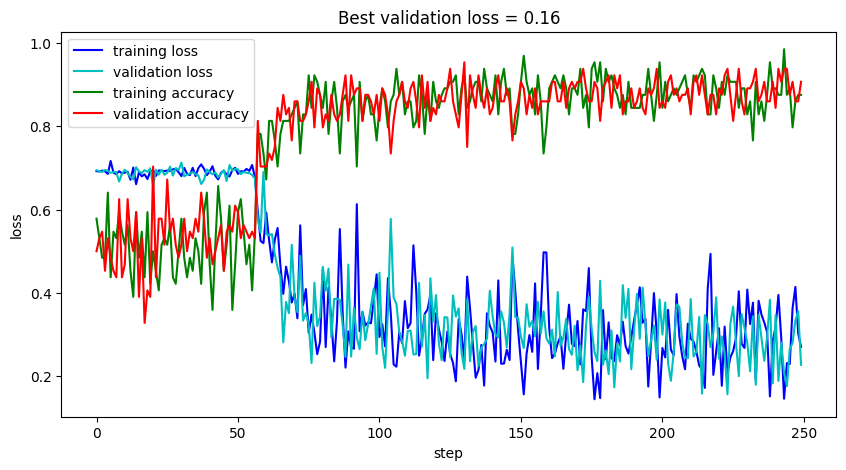

In [ ]:
trainer.train_network(
    dataloader_train,
    dataloader_val,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs
)


## Check results on the validation set

Now let's apply the trained model to the validation data to get an idea how well the network is performing. We will define the function ```process_basic``` below to apply the model to a dataset.

In [ ]:
def downscale(images, stride):
    # Downscale if the network does pooling
    return np.array(images)[:, ::stride, ::stride]


def adjust_axis(imgs):
    adjusted = []
    for index, image in enumerate(imgs):
        tmp = np.moveaxis(image,-1,0)
        #assuming batch size 1
        tmp = tmp[None,:]
        tmp = torch.from_numpy(tmp.astype(np.float32))
        adjusted.append(tmp)
    return adjusted


def process_basic(trainer: "Trainer", dataset: "DataSet", stride=1):

    # pad the original images, so we don't loose the borders in our output
    imgs = pad(dataset.imgs, patch_size) / 255.
    # downscale the label and masks if needed (to get the same resolution as the output)
    lbls = downscale(dataset.lbls, stride) > 0
    msks = downscale(dataset.msks, stride) > 0

    # apply our model to the images
    images = adjust_axis(imgs)
    output = trainer._predict_batch(images)

    return lbls, msks, output

We will use the following function to visually inspect the results and calculate a dice-score for each image:

In [ ]:
def calculate_dice(x, y):
    '''returns the dice similarity score, between two boolean arrays'''
    return 2 * np.count_nonzero(x & y) / (np.count_nonzero(x) + np.count_nonzero(y))

def check_results(imgs, lbls, msks, output):
    softmax = nn.Softmax(dim=1)
    dice_scores = []
    for i, (img, lbl, msk, raw_output) in enumerate(zip(imgs, lbls, msks, output)):
        final_output = raw_output.cpu().numpy()
        final_output = np.argmax(final_output, axis=1)
        final_output = np.moveaxis(final_output, 0, -1)
        dice = calculate_dice(final_output[msk], lbl[msk])
        dice_scores.append(dice)
        raw_output = softmax(raw_output)
        raw_output = raw_output.cpu().numpy()
        raw_output = raw_output[0, 1]
        print(f'image {i} Dice score: {dice}')

        # plot the results
        f, axes = plt.subplots(1, 4, figsize=(15, 6))
        for ax, im, t in zip(axes,
                             (img, raw_output, final_output, lbl),
                             ('RGB image', 'Soft prediction', 'Thresholded', 'Ground truth')):
            ax.imshow(im, cmap='gray', vmin=0, vmax=1)
            ax.set_title(t)
        plt.show()

    print('mean dice', np.mean(dice_scores))

Now we load the best model (based on the validation loss during training), and check the results:

In [ ]:
trainer_test = Trainer(network=network, optimizer=optimizer, loss_function=loss_function, name='basic_net', batch_size=batch_size)
trainer_test.load_best_network()

image 0 Dice score: 0.7313757476889614


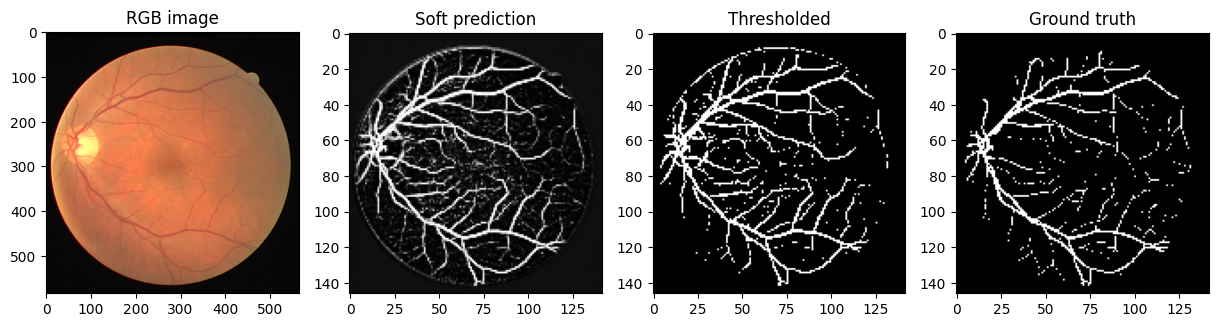

image 1 Dice score: 0.7366658694092323


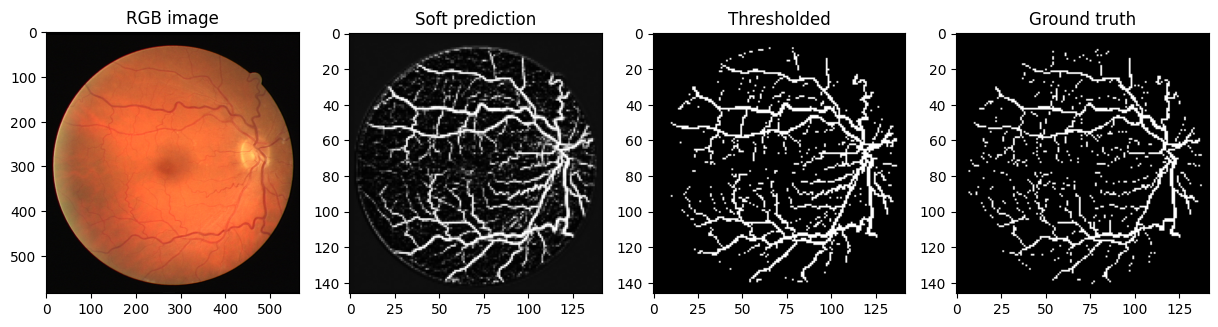

image 2 Dice score: 0.5139641517298874


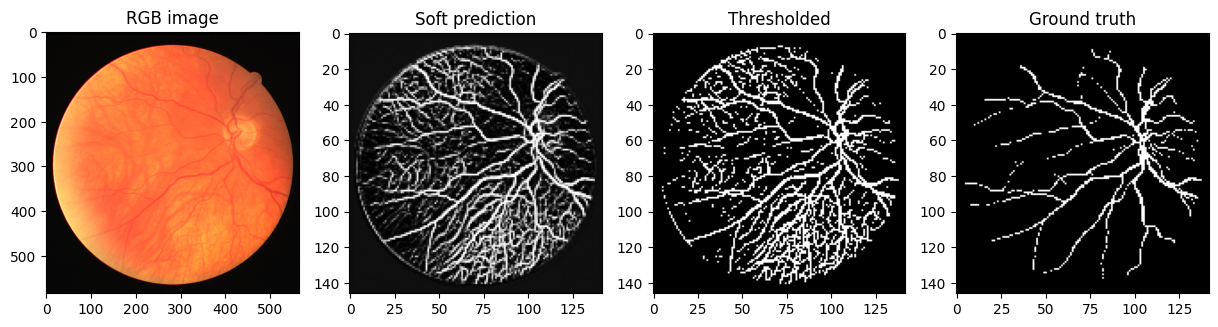

image 3 Dice score: 0.7760839437735102


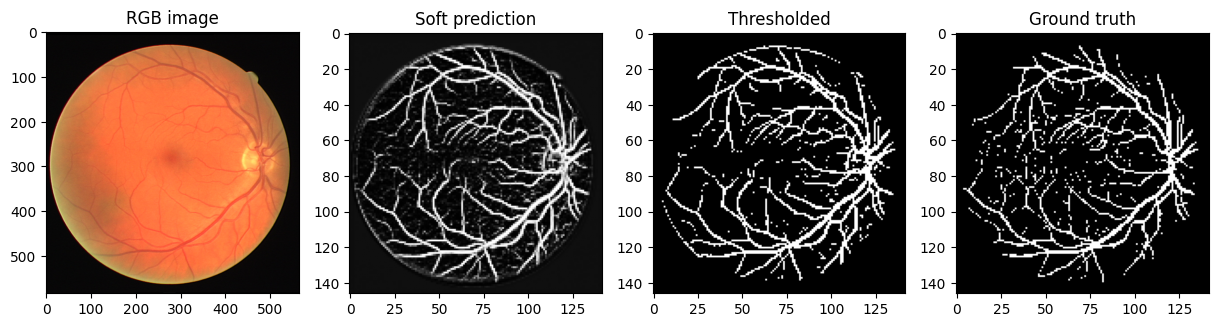

mean dice 0.6895224281503979


In [ ]:
lbls, msks, output = process_basic(trainer_test, validation_data, stride=stride)
check_results(validation_data.imgs, lbls, msks, output)

## Use dilated convolutions

<img align="right" width="300" src="https://diagnijmegen.github.io/ismi-course/images/assignment5/images/dilation.gif">

You can see that the label image predicted by our network has a **much lower resolution** then the input image.
This is due to the pooling operations that we used in our network. One solution to this would be to completely remove the pooling layers. For this, however, we would need to train using even smaller patches as input, reducing the context even more.

To get state-of-the-art results, it is normally necessary to include a **larger context**. If we wish to do this without introducing pooling operations or increasing the complexity of the network too much, we have another option: dilated convolutions.

Dilated convolutions work like regular convolutions, but introduce a spacing between the parameters of the filter. This way, they expand the area covered by the filter (often referred to as the **receptive field**). Unlike pooling operations, they do not reduce the resolution of the feature maps. Let's experiment with them, and define a new network architecture that includes dilated convolutions. See the image to the right for an example of a 3x3 convolution filter with dilation rate 2 (image taken from https://github.com/vdumoulin/conv_arithmetic ).

Implement the following network
* input layer
* 32 filters of 3x3
* 32 filters of 3x3
* 64 filters of 3x3, dilation rate 2
* 64 filters of 3x3, dilation rate 4
* 128 filters of 3x3, dilation rate 8
* 64 filters of 1x1
* 2 filters of 1x1

Note:
1. kernel weights initializer should be `'he_uniform'`
2. activation (except for final softmax) should be `'relu'`

In [ ]:
class ModelWithDilation(nn.Module):
    def __init__(self):
        super(ModelWithDilation, self).__init__()
        self.conv1 = None
        self.conv2 = None
        self.conv3 = None
        self.conv4 = None
        self.conv5 = None
        self.conv6 = None
        self.conv7 = None
        self.pool = None
        self.relu = None

        # YOUR CODE HERE
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, dilation=2, stride=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, dilation=4, stride=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, dilation=8, stride=1)
        self.conv6 = nn.Conv2d(128, 64, kernel_size=1, stride=1)
        self.conv7 = nn.Conv2d(64, 2, kernel_size=1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()


    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # YOUR SOLUTION HERE
                # nn.init.[something here](m.weight, nonlinearity='relu')

                # YOUR CODE HERE
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

    def forward(self, x):
        """
        Perform the forward pass of your network.

        Args:
            x (torch.Tensor): Input tensor to the network.

        Returns:
            torch.Tensor: Output tensor from the network.
        """
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.conv7(x)
        return x

In [ ]:
network_2 = ModelWithDilation()
print(network_2)
print(f"Number of parameters: {count_params(network_2)}")
network_2.initialize_weights()
optimizer_2 = torch.optim.Adam(network_2.parameters(), lr=learning_rate)


ModelWithDilation(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), dilation=(4, 4))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), dilation=(8, 8))
  (conv6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv7): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)
Number of parameters: 147810


In [ ]:
'''DO NOT MODIFY THIS CELL'''

'DO NOT MODIFY THIS CELL'

Set the new patch_size and stride for this network:

In [ ]:
patch_size = None
stride = None
epochs = None
# YOUR CODE HERE
patch_size = (33,33)
stride = 1
epochs = 200

In [ ]:
'''DO NOT MODIFY THIS CELL'''

'DO NOT MODIFY THIS CELL'

In [ ]:
patch_extractor_train = PatchExtractor(patch_size=patch_size, horizontal_flipping=True)
patch_dataset_train = PatchDataset(patch_extractor=patch_extractor_train, dataset=train_data, border_pad_size=patch_extractor_train.patch_size, batch_size=batch_size)
dataloader_train = torch.utils.data.DataLoader(patch_dataset_train, batch_size)
patch_extractor_val = PatchExtractor(patch_size=patch_size, horizontal_flipping=False)
patch_dataset_val = PatchDataset(patch_extractor=patch_extractor_val, dataset=validation_data, border_pad_size=patch_size, batch_size=batch_size)
dataloader_val = torch.utils.data.DataLoader(patch_dataset_val, batch_size)

# define the trainer
trainer = Trainer(
    network=network_2,
    optimizer=optimizer_2,
    loss_function=loss_function,
    name='model_2',
    batch_size=batch_size,
)


In [ ]:
# Perform an evaluation pass (of the randomly initialized network, to see if everything is working)
loss, accuracy = trainer.validate_dataset(dataloader_val)
print(f"validation loss {loss}, validation accuracy {accuracy}")


validation loss 0.6952031254768372, validation accuracy 0.46875


Epochs:   0%|          | 1/200 [00:00<00:53,  3.71it/s]

Epoch 0: train loss: 0.6879904270172119, train accuracy: 0.5, val loss: 0.6918287873268127, val accuracy: 0.53125


Epochs:   2%|▏         | 3/200 [00:00<00:42,  4.64it/s]

Epoch 1: train loss: 0.6810548305511475, train accuracy: 0.59375, val loss: 0.6887980103492737, val accuracy: 0.578125
Epoch 2: train loss: 0.6731851696968079, train accuracy: 0.625, val loss: 0.6898140907287598, val accuracy: 0.5


Epoch 3: train loss: 0.6687639951705933, train accuracy: 0.5625, val loss: 0.6742568016052246, val accuracy: 0.671875


Epochs:   2%|▎         | 5/200 [00:01<00:40,  4.80it/s]

Epoch 4: train loss: 0.6612249612808228, train accuracy: 0.71875, val loss: 0.6277640461921692, val accuracy: 0.671875


Epoch 5: train loss: 0.5534384250640869, train accuracy: 0.796875, val loss: 0.6024540066719055, val accuracy: 0.8125


Epochs:   4%|▎         | 7/200 [00:01<00:39,  4.84it/s]

Epoch 6: train loss: 0.4904705584049225, train accuracy: 0.765625, val loss: 0.4381794333457947, val accuracy: 0.796875


Epochs:   4%|▍         | 8/200 [00:01<00:39,  4.88it/s]

Epoch 7: train loss: 0.5087856650352478, train accuracy: 0.796875, val loss: 0.5222107172012329, val accuracy: 0.734375


Epochs:   5%|▌         | 10/200 [00:02<00:38,  4.91it/s]

Epoch 8: train loss: 0.42641764879226685, train accuracy: 0.8125, val loss: 0.49190014600753784, val accuracy: 0.765625
Epoch 9: train loss: 0.4464499354362488, train accuracy: 0.828125, val loss: 0.3747071623802185, val accuracy: 0.828125


Epoch 10: train loss: 0.38473862409591675, train accuracy: 0.859375, val loss: 0.5389478802680969, val accuracy: 0.75


Epochs:   6%|▋         | 13/200 [00:02<00:37,  4.99it/s]

Epoch 11: train loss: 0.4221206307411194, train accuracy: 0.859375, val loss: 0.5056344270706177, val accuracy: 0.765625
Epoch 12: train loss: 0.3516499698162079, train accuracy: 0.875, val loss: 0.5241744518280029, val accuracy: 0.796875


Epochs:   8%|▊         | 15/200 [00:03<00:37,  4.99it/s]

Epoch 13: train loss: 0.38419100642204285, train accuracy: 0.8125, val loss: 0.515349805355072, val accuracy: 0.78125
Epoch 14: train loss: 0.38054800033569336, train accuracy: 0.859375, val loss: 0.4042946398258209, val accuracy: 0.8125


Epochs:   8%|▊         | 17/200 [00:03<00:37,  4.93it/s]

Epoch 15: train loss: 0.40790218114852905, train accuracy: 0.859375, val loss: 0.40850120782852173, val accuracy: 0.828125
Epoch 16: train loss: 0.40158218145370483, train accuracy: 0.828125, val loss: 0.3635374903678894, val accuracy: 0.828125


Epochs:  10%|▉         | 19/200 [00:03<00:36,  4.99it/s]

Epoch 17: train loss: 0.48039987683296204, train accuracy: 0.8125, val loss: 0.5095440149307251, val accuracy: 0.734375
Epoch 18: train loss: 0.3402329683303833, train accuracy: 0.90625, val loss: 0.40220487117767334, val accuracy: 0.828125


Epochs:  10%|█         | 20/200 [00:04<00:35,  5.02it/s]

Epoch 19: train loss: 0.4400046765804291, train accuracy: 0.796875, val loss: 0.4597246050834656, val accuracy: 0.796875


Epochs:  10%|█         | 21/200 [00:04<00:36,  4.84it/s]

Epoch 20: train loss: 0.3734400272369385, train accuracy: 0.875, val loss: 0.4113616943359375, val accuracy: 0.796875


Epochs:  11%|█         | 22/200 [00:04<00:36,  4.83it/s]

Epoch 21: train loss: 0.33146095275878906, train accuracy: 0.875, val loss: 0.44736409187316895, val accuracy: 0.828125


Epochs:  12%|█▏        | 23/200 [00:04<00:37,  4.75it/s]

Epoch 22: train loss: 0.36755335330963135, train accuracy: 0.8125, val loss: 0.4089561104774475, val accuracy: 0.84375


Epochs:  12%|█▏        | 24/200 [00:04<00:37,  4.74it/s]

Epoch 23: train loss: 0.3819207549095154, train accuracy: 0.828125, val loss: 0.41104525327682495, val accuracy: 0.796875


Epochs:  12%|█▎        | 25/200 [00:05<00:42,  4.13it/s]

Epoch 24: train loss: 0.2911425232887268, train accuracy: 0.90625, val loss: 0.23717454075813293, val accuracy: 0.875


Epochs:  13%|█▎        | 26/200 [00:05<00:43,  3.99it/s]

Epoch 25: train loss: 0.34836894273757935, train accuracy: 0.875, val loss: 0.333904504776001, val accuracy: 0.890625


Epochs:  14%|█▎        | 27/200 [00:05<00:45,  3.79it/s]

Epoch 26: train loss: 0.3180672824382782, train accuracy: 0.8125, val loss: 0.4701573848724365, val accuracy: 0.765625


Epochs:  14%|█▍        | 28/200 [00:06<00:45,  3.77it/s]

Epoch 27: train loss: 0.3857653737068176, train accuracy: 0.828125, val loss: 0.3224693834781647, val accuracy: 0.890625


Epochs:  14%|█▍        | 29/200 [00:06<00:46,  3.69it/s]

Epoch 28: train loss: 0.33426064252853394, train accuracy: 0.859375, val loss: 0.5411906242370605, val accuracy: 0.78125


Epochs:  15%|█▌        | 30/200 [00:06<00:47,  3.56it/s]

Epoch 29: train loss: 0.30234235525131226, train accuracy: 0.859375, val loss: 0.34568989276885986, val accuracy: 0.90625


Epochs:  16%|█▌        | 31/200 [00:07<00:49,  3.44it/s]

Epoch 30: train loss: 0.35055333375930786, train accuracy: 0.859375, val loss: 0.3286440372467041, val accuracy: 0.84375


Epochs:  16%|█▌        | 32/200 [00:07<00:49,  3.37it/s]

Epoch 31: train loss: 0.315326064825058, train accuracy: 0.890625, val loss: 0.4145878553390503, val accuracy: 0.796875


Epochs:  16%|█▋        | 33/200 [00:07<00:45,  3.64it/s]

Epoch 32: train loss: 0.34836989641189575, train accuracy: 0.828125, val loss: 0.3652612566947937, val accuracy: 0.84375


Epochs:  17%|█▋        | 34/200 [00:07<00:42,  3.91it/s]

Epoch 33: train loss: 0.3629729151725769, train accuracy: 0.828125, val loss: 0.36020687222480774, val accuracy: 0.828125


Epochs:  18%|█▊        | 35/200 [00:08<00:39,  4.13it/s]

Epoch 34: train loss: 0.32020801305770874, train accuracy: 0.890625, val loss: 0.41440916061401367, val accuracy: 0.84375
Epoch 35: train loss: 0.2913608253002167, train accuracy: 0.875, val loss: 0.26111331582069397, val accuracy: 0.890625


Epochs:  18%|█▊        | 37/200 [00:08<00:36,  4.49it/s]

Epoch 36: train loss: 0.4628905951976776, train accuracy: 0.734375, val loss: 0.33048686385154724, val accuracy: 0.875


Epochs:  19%|█▉        | 38/200 [00:08<00:35,  4.58it/s]

Epoch 37: train loss: 0.40139517188072205, train accuracy: 0.796875, val loss: 0.29511311650276184, val accuracy: 0.90625


Epochs:  20%|██        | 40/200 [00:09<00:33,  4.76it/s]

Epoch 38: train loss: 0.4341048002243042, train accuracy: 0.78125, val loss: 0.5173792839050293, val accuracy: 0.859375
Epoch 39: train loss: 0.3752463161945343, train accuracy: 0.828125, val loss: 0.33381199836730957, val accuracy: 0.90625


Epochs:  20%|██        | 41/200 [00:09<00:32,  4.85it/s]

Epoch 40: train loss: 0.35239654779434204, train accuracy: 0.84375, val loss: 0.34426063299179077, val accuracy: 0.875


Epochs:  21%|██        | 42/200 [00:09<00:32,  4.86it/s]

Epoch 41: train loss: 0.25511038303375244, train accuracy: 0.9375, val loss: 0.4298051595687866, val accuracy: 0.796875


Epochs:  22%|██▏       | 43/200 [00:09<00:32,  4.78it/s]

Epoch 42: train loss: 0.24775326251983643, train accuracy: 0.90625, val loss: 0.24356287717819214, val accuracy: 0.90625


Epochs:  22%|██▎       | 45/200 [00:10<00:32,  4.83it/s]

Epoch 43: train loss: 0.331989049911499, train accuracy: 0.875, val loss: 0.30833131074905396, val accuracy: 0.859375
Epoch 44: train loss: 0.3879812955856323, train accuracy: 0.84375, val loss: 0.4178152084350586, val accuracy: 0.828125


Epochs:  23%|██▎       | 46/200 [00:10<00:31,  4.93it/s]

Epoch 45: train loss: 0.3564712405204773, train accuracy: 0.828125, val loss: 0.29487672448158264, val accuracy: 0.828125


Epochs:  24%|██▎       | 47/200 [00:10<00:31,  4.91it/s]

Epoch 46: train loss: 0.29515987634658813, train accuracy: 0.890625, val loss: 0.3981333374977112, val accuracy: 0.78125


Epochs:  24%|██▍       | 48/200 [00:10<00:31,  4.90it/s]

Epoch 47: train loss: 0.4017329812049866, train accuracy: 0.84375, val loss: 0.3200497627258301, val accuracy: 0.875


Epochs:  25%|██▌       | 50/200 [00:11<00:30,  4.98it/s]

Epoch 48: train loss: 0.3455204367637634, train accuracy: 0.859375, val loss: 0.34644585847854614, val accuracy: 0.828125
Epoch 49: train loss: 0.30474579334259033, train accuracy: 0.90625, val loss: 0.30473464727401733, val accuracy: 0.890625


Epochs:  26%|██▌       | 51/200 [00:11<00:29,  4.99it/s]

Epoch 50: train loss: 0.3937271237373352, train accuracy: 0.828125, val loss: 0.3840828537940979, val accuracy: 0.796875


Epochs:  26%|██▌       | 52/200 [00:11<00:30,  4.93it/s]

Epoch 51: train loss: 0.43092626333236694, train accuracy: 0.8125, val loss: 0.45065608620643616, val accuracy: 0.8125


Epochs:  26%|██▋       | 53/200 [00:11<00:30,  4.88it/s]

Epoch 52: train loss: 0.2695014476776123, train accuracy: 0.875, val loss: 0.41423165798187256, val accuracy: 0.828125


Epochs:  27%|██▋       | 54/200 [00:11<00:30,  4.80it/s]

Epoch 53: train loss: 0.32531416416168213, train accuracy: 0.890625, val loss: 0.2532939314842224, val accuracy: 0.953125


Epochs:  28%|██▊       | 55/200 [00:12<00:30,  4.81it/s]

Epoch 54: train loss: 0.2635526657104492, train accuracy: 0.921875, val loss: 0.2737869620323181, val accuracy: 0.90625
Epoch 55: train loss: 0.40240997076034546, train accuracy: 0.8125, val loss: 0.45320582389831543, val accuracy: 0.78125


Epochs:  28%|██▊       | 57/200 [00:12<00:29,  4.89it/s]

Epoch 56: train loss: 0.4161132574081421, train accuracy: 0.828125, val loss: 0.29842835664749146, val accuracy: 0.90625


Epochs:  29%|██▉       | 58/200 [00:12<00:29,  4.77it/s]

Epoch 57: train loss: 0.20919662714004517, train accuracy: 0.921875, val loss: 0.4604569673538208, val accuracy: 0.765625


Epochs:  30%|██▉       | 59/200 [00:12<00:29,  4.76it/s]

Epoch 58: train loss: 0.26464518904685974, train accuracy: 0.890625, val loss: 0.3102153241634369, val accuracy: 0.828125


Epochs:  30%|███       | 60/200 [00:13<00:29,  4.77it/s]

Epoch 59: train loss: 0.44957420229911804, train accuracy: 0.796875, val loss: 0.3819604218006134, val accuracy: 0.84375


Epochs:  30%|███       | 61/200 [00:13<00:29,  4.76it/s]

Epoch 60: train loss: 0.3375793695449829, train accuracy: 0.875, val loss: 0.44216981530189514, val accuracy: 0.84375


Epochs:  31%|███       | 62/200 [00:13<00:29,  4.72it/s]

Epoch 61: train loss: 0.3418225646018982, train accuracy: 0.875, val loss: 0.41757190227508545, val accuracy: 0.765625


Epochs:  32%|███▏      | 63/200 [00:13<00:29,  4.66it/s]

Epoch 62: train loss: 0.387651264667511, train accuracy: 0.84375, val loss: 0.39937806129455566, val accuracy: 0.8125


Epochs:  32%|███▏      | 64/200 [00:13<00:28,  4.72it/s]

Epoch 63: train loss: 0.33904528617858887, train accuracy: 0.890625, val loss: 0.2560076415538788, val accuracy: 0.890625


Epochs:  32%|███▎      | 65/200 [00:14<00:28,  4.68it/s]

Epoch 64: train loss: 0.3667164444923401, train accuracy: 0.828125, val loss: 0.23923109471797943, val accuracy: 0.921875


Epochs:  33%|███▎      | 66/200 [00:14<00:28,  4.62it/s]

Epoch 65: train loss: 0.3085288107395172, train accuracy: 0.890625, val loss: 0.39638152718544006, val accuracy: 0.859375


Epochs:  34%|███▎      | 67/200 [00:14<00:29,  4.58it/s]

Epoch 66: train loss: 0.3484165072441101, train accuracy: 0.84375, val loss: 0.38912737369537354, val accuracy: 0.828125


Epochs:  34%|███▍      | 68/200 [00:14<00:28,  4.56it/s]

Epoch 67: train loss: 0.3178975582122803, train accuracy: 0.90625, val loss: 0.380537748336792, val accuracy: 0.828125


Epochs:  34%|███▍      | 69/200 [00:15<00:28,  4.66it/s]

Epoch 68: train loss: 0.25398948788642883, train accuracy: 0.921875, val loss: 0.3068464398384094, val accuracy: 0.90625


Epochs:  35%|███▌      | 70/200 [00:15<00:27,  4.70it/s]

Epoch 69: train loss: 0.28416121006011963, train accuracy: 0.921875, val loss: 0.3717440366744995, val accuracy: 0.859375


Epochs:  36%|███▌      | 71/200 [00:15<00:27,  4.71it/s]

Epoch 70: train loss: 0.2868788242340088, train accuracy: 0.921875, val loss: 0.24053962528705597, val accuracy: 0.90625


Epochs:  36%|███▌      | 72/200 [00:15<00:27,  4.63it/s]

Epoch 71: train loss: 0.32045692205429077, train accuracy: 0.828125, val loss: 0.35474061965942383, val accuracy: 0.859375


Epochs:  36%|███▋      | 73/200 [00:15<00:27,  4.66it/s]

Epoch 72: train loss: 0.2722702622413635, train accuracy: 0.859375, val loss: 0.3300764560699463, val accuracy: 0.84375


Epochs:  37%|███▋      | 74/200 [00:16<00:26,  4.67it/s]

Epoch 73: train loss: 0.3218308091163635, train accuracy: 0.90625, val loss: 0.23651286959648132, val accuracy: 0.890625


Epochs:  38%|███▊      | 75/200 [00:16<00:26,  4.76it/s]

Epoch 74: train loss: 0.3727208375930786, train accuracy: 0.84375, val loss: 0.2760084867477417, val accuracy: 0.90625


Epochs:  38%|███▊      | 76/200 [00:16<00:26,  4.73it/s]

Epoch 75: train loss: 0.31442850828170776, train accuracy: 0.828125, val loss: 0.31370046734809875, val accuracy: 0.875


Epochs:  38%|███▊      | 77/200 [00:16<00:27,  4.52it/s]

Epoch 76: train loss: 0.27551835775375366, train accuracy: 0.890625, val loss: 0.23131848871707916, val accuracy: 0.890625


Epochs:  39%|███▉      | 78/200 [00:17<00:28,  4.34it/s]

Epoch 77: train loss: 0.3523199260234833, train accuracy: 0.828125, val loss: 0.22489143908023834, val accuracy: 0.890625


Epochs:  40%|███▉      | 79/200 [00:17<00:27,  4.41it/s]

Epoch 78: train loss: 0.3770132064819336, train accuracy: 0.8125, val loss: 0.30874699354171753, val accuracy: 0.875


Epochs:  40%|████      | 80/200 [00:17<00:29,  4.09it/s]

Epoch 79: train loss: 0.3441428244113922, train accuracy: 0.84375, val loss: 0.2835811376571655, val accuracy: 0.90625


Epochs:  40%|████      | 81/200 [00:17<00:31,  3.77it/s]

Epoch 80: train loss: 0.37986090779304504, train accuracy: 0.828125, val loss: 0.42965394258499146, val accuracy: 0.8125


Epochs:  41%|████      | 82/200 [00:18<00:32,  3.64it/s]

Epoch 81: train loss: 0.39190351963043213, train accuracy: 0.84375, val loss: 0.4273340702056885, val accuracy: 0.8125


Epochs:  42%|████▏     | 83/200 [00:18<00:32,  3.58it/s]

Epoch 82: train loss: 0.31933122873306274, train accuracy: 0.859375, val loss: 0.3435128629207611, val accuracy: 0.859375


Epochs:  42%|████▏     | 84/200 [00:18<00:32,  3.57it/s]

Epoch 83: train loss: 0.3487868309020996, train accuracy: 0.84375, val loss: 0.3476119339466095, val accuracy: 0.859375


Epochs:  42%|████▎     | 85/200 [00:19<00:33,  3.48it/s]

Epoch 84: train loss: 0.46646782755851746, train accuracy: 0.78125, val loss: 0.35094672441482544, val accuracy: 0.890625


Epochs:  43%|████▎     | 86/200 [00:19<00:33,  3.42it/s]

Epoch 85: train loss: 0.35335877537727356, train accuracy: 0.84375, val loss: 0.34864315390586853, val accuracy: 0.890625


Epochs:  44%|████▎     | 87/200 [00:19<00:34,  3.28it/s]

Epoch 86: train loss: 0.199832022190094, train accuracy: 0.96875, val loss: 0.4245981276035309, val accuracy: 0.75


Epochs:  44%|████▍     | 88/200 [00:19<00:33,  3.36it/s]

Epoch 87: train loss: 0.4594610631465912, train accuracy: 0.8125, val loss: 0.25641778111457825, val accuracy: 0.875


Epochs:  44%|████▍     | 89/200 [00:20<00:30,  3.66it/s]

Epoch 88: train loss: 0.3612062633037567, train accuracy: 0.859375, val loss: 0.3979548215866089, val accuracy: 0.859375


Epochs:  45%|████▌     | 90/200 [00:20<00:28,  3.91it/s]

Epoch 89: train loss: 0.3155919909477234, train accuracy: 0.875, val loss: 0.2853849530220032, val accuracy: 0.890625


Epochs:  46%|████▌     | 91/200 [00:20<00:26,  4.10it/s]

Epoch 90: train loss: 0.3782666325569153, train accuracy: 0.828125, val loss: 0.33238112926483154, val accuracy: 0.875


Epochs:  46%|████▌     | 92/200 [00:20<00:25,  4.21it/s]

Epoch 91: train loss: 0.21066778898239136, train accuracy: 0.890625, val loss: 0.5116991996765137, val accuracy: 0.8125


Epochs:  46%|████▋     | 93/200 [00:21<00:25,  4.27it/s]

Epoch 92: train loss: 0.2738111615180969, train accuracy: 0.90625, val loss: 0.34759223461151123, val accuracy: 0.859375


Epochs:  47%|████▋     | 94/200 [00:21<00:24,  4.36it/s]

Epoch 93: train loss: 0.28762099146842957, train accuracy: 0.828125, val loss: 0.24485436081886292, val accuracy: 0.90625


Epochs:  48%|████▊     | 95/200 [00:21<00:23,  4.43it/s]

Epoch 94: train loss: 0.3027442693710327, train accuracy: 0.859375, val loss: 0.4170837998390198, val accuracy: 0.8125


Epochs:  48%|████▊     | 96/200 [00:21<00:23,  4.49it/s]

Epoch 95: train loss: 0.259717732667923, train accuracy: 0.921875, val loss: 0.303122878074646, val accuracy: 0.84375


Epochs:  48%|████▊     | 97/200 [00:21<00:23,  4.41it/s]

Epoch 96: train loss: 0.3235313892364502, train accuracy: 0.875, val loss: 0.29725655913352966, val accuracy: 0.875


Epochs:  49%|████▉     | 98/200 [00:22<00:22,  4.44it/s]

Epoch 97: train loss: 0.2935253381729126, train accuracy: 0.921875, val loss: 0.3843061625957489, val accuracy: 0.8125


Epochs:  50%|████▉     | 99/200 [00:22<00:22,  4.48it/s]

Epoch 98: train loss: 0.3901224732398987, train accuracy: 0.75, val loss: 0.4218648374080658, val accuracy: 0.828125


Epochs:  50%|█████     | 100/200 [00:22<00:22,  4.49it/s]

Epoch 99: train loss: 0.3084748387336731, train accuracy: 0.890625, val loss: 0.36193645000457764, val accuracy: 0.8125


Epochs:  50%|█████     | 101/200 [00:22<00:22,  4.46it/s]

Epoch 100: train loss: 0.21803539991378784, train accuracy: 0.90625, val loss: 0.3435437083244324, val accuracy: 0.890625


Epochs:  51%|█████     | 102/200 [00:23<00:22,  4.41it/s]

Epoch 101: train loss: 0.2056925743818283, train accuracy: 0.921875, val loss: 0.37780851125717163, val accuracy: 0.8125


Epochs:  52%|█████▏    | 103/200 [00:23<00:21,  4.55it/s]

Epoch 102: train loss: 0.21999222040176392, train accuracy: 0.9375, val loss: 0.3010791838169098, val accuracy: 0.890625


Epochs:  52%|█████▏    | 104/200 [00:23<00:21,  4.49it/s]

Epoch 103: train loss: 0.32304009795188904, train accuracy: 0.890625, val loss: 0.4032219350337982, val accuracy: 0.765625


Epochs:  52%|█████▎    | 105/200 [00:23<00:21,  4.47it/s]

Epoch 104: train loss: 0.35912826657295227, train accuracy: 0.8125, val loss: 0.2533499002456665, val accuracy: 0.921875


Epochs:  53%|█████▎    | 106/200 [00:23<00:21,  4.38it/s]

Epoch 105: train loss: 0.2659638226032257, train accuracy: 0.875, val loss: 0.44450682401657104, val accuracy: 0.78125


Epochs:  54%|█████▎    | 107/200 [00:24<00:21,  4.39it/s]

Epoch 106: train loss: 0.42557433247566223, train accuracy: 0.859375, val loss: 0.2965891659259796, val accuracy: 0.875


Epochs:  54%|█████▍    | 108/200 [00:24<00:21,  4.37it/s]

Epoch 107: train loss: 0.5315308570861816, train accuracy: 0.765625, val loss: 0.3807104825973511, val accuracy: 0.8125


Epochs:  55%|█████▍    | 109/200 [00:24<00:20,  4.37it/s]

Epoch 108: train loss: 0.23527655005455017, train accuracy: 0.9375, val loss: 0.3016192317008972, val accuracy: 0.875


Epochs:  55%|█████▌    | 110/200 [00:24<00:20,  4.36it/s]

Epoch 109: train loss: 0.24347342550754547, train accuracy: 0.90625, val loss: 0.2876792252063751, val accuracy: 0.875


Epochs:  56%|█████▌    | 111/200 [00:25<00:20,  4.27it/s]

Epoch 110: train loss: 0.35550910234451294, train accuracy: 0.875, val loss: 0.1940632164478302, val accuracy: 0.9375


Epochs:  56%|█████▌    | 112/200 [00:25<00:20,  4.37it/s]

Epoch 111: train loss: 0.450480580329895, train accuracy: 0.78125, val loss: 0.43870317935943604, val accuracy: 0.8125


Epochs:  56%|█████▋    | 113/200 [00:25<00:19,  4.46it/s]

Epoch 112: train loss: 0.2645582854747772, train accuracy: 0.890625, val loss: 0.2829175293445587, val accuracy: 0.859375


Epochs:  57%|█████▋    | 114/200 [00:25<00:19,  4.41it/s]

Epoch 113: train loss: 0.3928843140602112, train accuracy: 0.84375, val loss: 0.2220466434955597, val accuracy: 0.875


Epochs:  57%|█████▊    | 115/200 [00:26<00:19,  4.33it/s]

Epoch 114: train loss: 0.3566094636917114, train accuracy: 0.828125, val loss: 0.2594779133796692, val accuracy: 0.921875


Epochs:  58%|█████▊    | 116/200 [00:26<00:19,  4.38it/s]

Epoch 115: train loss: 0.30216458439826965, train accuracy: 0.875, val loss: 0.3085709810256958, val accuracy: 0.875


Epochs:  58%|█████▊    | 117/200 [00:26<00:18,  4.41it/s]

Epoch 116: train loss: 0.22718030214309692, train accuracy: 0.90625, val loss: 0.38598084449768066, val accuracy: 0.8125


Epochs:  59%|█████▉    | 118/200 [00:26<00:18,  4.42it/s]

Epoch 117: train loss: 0.5685837864875793, train accuracy: 0.75, val loss: 0.27630549669265747, val accuracy: 0.90625


Epochs:  60%|█████▉    | 119/200 [00:26<00:18,  4.32it/s]

Epoch 118: train loss: 0.4790467619895935, train accuracy: 0.78125, val loss: 0.2786117196083069, val accuracy: 0.859375


Epochs:  60%|██████    | 120/200 [00:27<00:18,  4.26it/s]

Epoch 119: train loss: 0.2814437747001648, train accuracy: 0.90625, val loss: 0.3574930429458618, val accuracy: 0.859375


Epochs:  60%|██████    | 121/200 [00:27<00:18,  4.26it/s]

Epoch 120: train loss: 0.28404831886291504, train accuracy: 0.90625, val loss: 0.27645304799079895, val accuracy: 0.828125


Epochs:  61%|██████    | 122/200 [00:27<00:18,  4.27it/s]

Epoch 121: train loss: 0.34874045848846436, train accuracy: 0.828125, val loss: 0.34106823801994324, val accuracy: 0.84375


Epochs:  62%|██████▏   | 123/200 [00:27<00:18,  4.25it/s]

Epoch 122: train loss: 0.38003671169281006, train accuracy: 0.859375, val loss: 0.34826838970184326, val accuracy: 0.859375


Epochs:  62%|██████▏   | 124/200 [00:28<00:23,  3.18it/s]

Epoch 123: train loss: 0.20146232843399048, train accuracy: 0.921875, val loss: 0.26479172706604004, val accuracy: 0.890625


Epochs:  62%|██████▎   | 125/200 [00:28<00:28,  2.60it/s]

Epoch 124: train loss: 0.387418270111084, train accuracy: 0.875, val loss: 0.31610262393951416, val accuracy: 0.859375


Epochs:  63%|██████▎   | 126/200 [00:29<00:28,  2.56it/s]

Epoch 125: train loss: 0.24339546263217926, train accuracy: 0.921875, val loss: 0.43012845516204834, val accuracy: 0.8125


Epochs:  64%|██████▎   | 127/200 [00:29<00:29,  2.46it/s]

Epoch 126: train loss: 0.4135127365589142, train accuracy: 0.84375, val loss: 0.3145718276500702, val accuracy: 0.859375


Epochs:  64%|██████▍   | 128/200 [00:30<00:41,  1.73it/s]

Epoch 127: train loss: 0.3196270167827606, train accuracy: 0.890625, val loss: 0.42756903171539307, val accuracy: 0.765625


Epochs:  64%|██████▍   | 129/200 [00:31<00:51,  1.37it/s]

Epoch 128: train loss: 0.44060665369033813, train accuracy: 0.84375, val loss: 0.38934364914894104, val accuracy: 0.859375


Epochs:  65%|██████▌   | 130/200 [00:32<00:54,  1.27it/s]

Epoch 129: train loss: 0.3821375370025635, train accuracy: 0.8125, val loss: 0.2538799047470093, val accuracy: 0.921875


Epochs:  66%|██████▌   | 131/200 [00:33<00:49,  1.39it/s]

Epoch 130: train loss: 0.28334319591522217, train accuracy: 0.890625, val loss: 0.23982639610767365, val accuracy: 0.921875


Epochs:  66%|██████▌   | 132/200 [00:33<00:43,  1.56it/s]

Epoch 131: train loss: 0.2928096055984497, train accuracy: 0.890625, val loss: 0.28908902406692505, val accuracy: 0.84375


Epochs:  66%|██████▋   | 133/200 [00:34<00:40,  1.64it/s]

Epoch 132: train loss: 0.3269338607788086, train accuracy: 0.828125, val loss: 0.4016808271408081, val accuracy: 0.796875


Epochs:  67%|██████▋   | 134/200 [00:34<00:33,  1.95it/s]

Epoch 133: train loss: 0.19645023345947266, train accuracy: 0.921875, val loss: 0.3880297541618347, val accuracy: 0.8125


Epochs:  68%|██████▊   | 135/200 [00:34<00:27,  2.33it/s]

Epoch 134: train loss: 0.27227747440338135, train accuracy: 0.90625, val loss: 0.23782630264759064, val accuracy: 0.890625


Epochs:  68%|██████▊   | 136/200 [00:35<00:23,  2.71it/s]

Epoch 135: train loss: 0.22685320675373077, train accuracy: 0.9375, val loss: 0.3542216420173645, val accuracy: 0.84375


Epochs:  68%|██████▊   | 137/200 [00:35<00:20,  3.07it/s]

Epoch 136: train loss: 0.287333607673645, train accuracy: 0.875, val loss: 0.3278122842311859, val accuracy: 0.859375


Epochs:  69%|██████▉   | 138/200 [00:35<00:18,  3.32it/s]

Epoch 137: train loss: 0.21281442046165466, train accuracy: 0.921875, val loss: 0.30921438336372375, val accuracy: 0.84375


Epochs:  70%|██████▉   | 139/200 [00:35<00:17,  3.55it/s]

Epoch 138: train loss: 0.46854275465011597, train accuracy: 0.78125, val loss: 0.4923436641693115, val accuracy: 0.796875


Epochs:  70%|███████   | 140/200 [00:35<00:15,  3.78it/s]

Epoch 139: train loss: 0.31191307306289673, train accuracy: 0.90625, val loss: 0.2966635823249817, val accuracy: 0.859375


Epochs:  70%|███████   | 141/200 [00:36<00:15,  3.91it/s]

Epoch 140: train loss: 0.33492764830589294, train accuracy: 0.859375, val loss: 0.29329511523246765, val accuracy: 0.890625


Epochs:  71%|███████   | 142/200 [00:36<00:14,  3.93it/s]

Epoch 141: train loss: 0.385318398475647, train accuracy: 0.828125, val loss: 0.31940168142318726, val accuracy: 0.828125


Epochs:  72%|███████▏  | 143/200 [00:36<00:14,  3.99it/s]

Epoch 142: train loss: 0.27778181433677673, train accuracy: 0.875, val loss: 0.31983208656311035, val accuracy: 0.84375


Epochs:  72%|███████▏  | 144/200 [00:36<00:13,  4.02it/s]

Epoch 143: train loss: 0.39299410581588745, train accuracy: 0.84375, val loss: 0.320917546749115, val accuracy: 0.859375


Epochs:  72%|███████▎  | 145/200 [00:37<00:13,  4.06it/s]

Epoch 144: train loss: 0.18816570937633514, train accuracy: 0.890625, val loss: 0.33999690413475037, val accuracy: 0.859375


Epochs:  73%|███████▎  | 146/200 [00:37<00:13,  4.10it/s]

Epoch 145: train loss: 0.2893728017807007, train accuracy: 0.875, val loss: 0.3501304090023041, val accuracy: 0.859375


Epochs:  74%|███████▎  | 147/200 [00:37<00:12,  4.11it/s]

Epoch 146: train loss: 0.2495727837085724, train accuracy: 0.90625, val loss: 0.2544468343257904, val accuracy: 0.890625


Epochs:  74%|███████▍  | 148/200 [00:37<00:12,  4.13it/s]

Epoch 147: train loss: 0.3228124678134918, train accuracy: 0.828125, val loss: 0.3277263045310974, val accuracy: 0.8125


Epochs:  74%|███████▍  | 149/200 [00:38<00:12,  4.19it/s]

Epoch 148: train loss: 0.21539433300495148, train accuracy: 0.921875, val loss: 0.5973786115646362, val accuracy: 0.734375


Epochs:  75%|███████▌  | 150/200 [00:38<00:11,  4.21it/s]

Epoch 149: train loss: 0.4583091735839844, train accuracy: 0.8125, val loss: 0.31946831941604614, val accuracy: 0.859375


Epochs:  76%|███████▌  | 151/200 [00:38<00:11,  4.16it/s]

Epoch 150: train loss: 0.2160666286945343, train accuracy: 0.890625, val loss: 0.28213679790496826, val accuracy: 0.890625


Epochs:  76%|███████▌  | 152/200 [00:38<00:11,  4.18it/s]

Epoch 151: train loss: 0.2707684338092804, train accuracy: 0.90625, val loss: 0.3239496648311615, val accuracy: 0.828125


Epochs:  76%|███████▋  | 153/200 [00:39<00:11,  4.24it/s]

Epoch 152: train loss: 0.2097572386264801, train accuracy: 0.921875, val loss: 0.35156336426734924, val accuracy: 0.828125


Epochs:  77%|███████▋  | 154/200 [00:39<00:10,  4.23it/s]

Epoch 153: train loss: 0.2130163609981537, train accuracy: 0.921875, val loss: 0.28918635845184326, val accuracy: 0.890625


Epochs:  78%|███████▊  | 155/200 [00:39<00:10,  4.20it/s]

Epoch 154: train loss: 0.21984414756298065, train accuracy: 0.9375, val loss: 0.3274337649345398, val accuracy: 0.84375


Epochs:  78%|███████▊  | 156/200 [00:39<00:10,  4.23it/s]

Epoch 155: train loss: 0.34439677000045776, train accuracy: 0.921875, val loss: 0.3299424350261688, val accuracy: 0.875


Epochs:  78%|███████▊  | 157/200 [00:40<00:10,  4.28it/s]

Epoch 156: train loss: 0.5434651374816895, train accuracy: 0.78125, val loss: 0.4377920627593994, val accuracy: 0.859375


Epochs:  79%|███████▉  | 158/200 [00:40<00:09,  4.29it/s]

Epoch 157: train loss: 0.2245228886604309, train accuracy: 0.90625, val loss: 0.3245978355407715, val accuracy: 0.875


Epochs:  80%|███████▉  | 159/200 [00:40<00:09,  4.29it/s]

Epoch 158: train loss: 0.33355915546417236, train accuracy: 0.84375, val loss: 0.25707101821899414, val accuracy: 0.9375


Epochs:  80%|████████  | 160/200 [00:40<00:09,  4.19it/s]

Epoch 159: train loss: 0.3119785189628601, train accuracy: 0.875, val loss: 0.3378308415412903, val accuracy: 0.859375


Epochs:  80%|████████  | 161/200 [00:40<00:09,  4.26it/s]

Epoch 160: train loss: 0.3773021399974823, train accuracy: 0.8125, val loss: 0.48401331901550293, val accuracy: 0.78125


Epochs:  81%|████████  | 162/200 [00:41<00:08,  4.34it/s]

Epoch 161: train loss: 0.2668808102607727, train accuracy: 0.921875, val loss: 0.3462788462638855, val accuracy: 0.859375


Epochs:  82%|████████▏ | 163/200 [00:41<00:08,  4.39it/s]

Epoch 162: train loss: 0.3748306632041931, train accuracy: 0.859375, val loss: 0.44205015897750854, val accuracy: 0.765625


Epochs:  82%|████████▏ | 164/200 [00:41<00:08,  4.36it/s]

Epoch 163: train loss: 0.2946268916130066, train accuracy: 0.84375, val loss: 0.24488480389118195, val accuracy: 0.890625


Epochs:  82%|████████▎ | 165/200 [00:41<00:08,  4.29it/s]

Epoch 164: train loss: 0.292751282453537, train accuracy: 0.875, val loss: 0.33266139030456543, val accuracy: 0.828125


Epochs:  83%|████████▎ | 166/200 [00:42<00:07,  4.39it/s]

Epoch 165: train loss: 0.32058483362197876, train accuracy: 0.84375, val loss: 0.33123257756233215, val accuracy: 0.84375


Epochs:  84%|████████▎ | 167/200 [00:42<00:07,  4.42it/s]

Epoch 166: train loss: 0.371071994304657, train accuracy: 0.84375, val loss: 0.3253575563430786, val accuracy: 0.890625


Epochs:  84%|████████▍ | 168/200 [00:42<00:07,  4.37it/s]

Epoch 167: train loss: 0.3423798382282257, train accuracy: 0.875, val loss: 0.22547957301139832, val accuracy: 0.9375


Epochs:  84%|████████▍ | 169/200 [00:42<00:07,  4.26it/s]

Epoch 168: train loss: 0.26512256264686584, train accuracy: 0.90625, val loss: 0.2575657069683075, val accuracy: 0.859375


Epochs:  85%|████████▌ | 170/200 [00:43<00:06,  4.33it/s]

Epoch 169: train loss: 0.2519252896308899, train accuracy: 0.921875, val loss: 0.28426113724708557, val accuracy: 0.90625


Epochs:  86%|████████▌ | 171/200 [00:43<00:07,  4.04it/s]

Epoch 170: train loss: 0.2852436304092407, train accuracy: 0.828125, val loss: 0.3537745475769043, val accuracy: 0.875


Epochs:  86%|████████▌ | 172/200 [00:43<00:07,  3.67it/s]

Epoch 171: train loss: 0.4594661593437195, train accuracy: 0.828125, val loss: 0.2716720402240753, val accuracy: 0.890625


Epochs:  86%|████████▋ | 173/200 [00:43<00:07,  3.50it/s]

Epoch 172: train loss: 0.23719826340675354, train accuracy: 0.9375, val loss: 0.4202704429626465, val accuracy: 0.8125


Epochs:  87%|████████▋ | 174/200 [00:44<00:07,  3.41it/s]

Epoch 173: train loss: 0.3005039393901825, train accuracy: 0.921875, val loss: 0.2858554720878601, val accuracy: 0.859375


Epochs:  88%|████████▊ | 175/200 [00:44<00:07,  3.41it/s]

Epoch 174: train loss: 0.33094334602355957, train accuracy: 0.859375, val loss: 0.243418350815773, val accuracy: 0.890625


Epochs:  88%|████████▊ | 176/200 [00:44<00:07,  3.27it/s]

Epoch 175: train loss: 0.2721279561519623, train accuracy: 0.859375, val loss: 0.27816420793533325, val accuracy: 0.859375


Epochs:  88%|████████▊ | 177/200 [00:45<00:07,  3.22it/s]

Epoch 176: train loss: 0.2913439869880676, train accuracy: 0.859375, val loss: 0.33225005865097046, val accuracy: 0.875


Epochs:  89%|████████▉ | 178/200 [00:45<00:07,  3.09it/s]

Epoch 177: train loss: 0.2337549775838852, train accuracy: 0.90625, val loss: 0.32535600662231445, val accuracy: 0.875


Epochs:  90%|████████▉ | 179/200 [00:45<00:06,  3.12it/s]

Epoch 178: train loss: 0.28731638193130493, train accuracy: 0.875, val loss: 0.42063355445861816, val accuracy: 0.828125


Epochs:  90%|█████████ | 180/200 [00:46<00:05,  3.40it/s]

Epoch 179: train loss: 0.19352880120277405, train accuracy: 0.9375, val loss: 0.3522750735282898, val accuracy: 0.84375


Epochs:  90%|█████████ | 181/200 [00:46<00:05,  3.70it/s]

Epoch 180: train loss: 0.1976400464773178, train accuracy: 0.953125, val loss: 0.28158697485923767, val accuracy: 0.875


Epochs:  91%|█████████ | 182/200 [00:46<00:04,  3.88it/s]

Epoch 181: train loss: 0.3166128993034363, train accuracy: 0.84375, val loss: 0.2513362169265747, val accuracy: 0.921875


Epochs:  92%|█████████▏| 183/200 [00:46<00:04,  3.89it/s]

Epoch 182: train loss: 0.22386127710342407, train accuracy: 0.9375, val loss: 0.30462926626205444, val accuracy: 0.875


Epochs:  92%|█████████▏| 184/200 [00:47<00:03,  4.00it/s]

Epoch 183: train loss: 0.2933533191680908, train accuracy: 0.859375, val loss: 0.2078389972448349, val accuracy: 0.953125


Epochs:  92%|█████████▎| 185/200 [00:47<00:03,  3.92it/s]

Epoch 184: train loss: 0.37007391452789307, train accuracy: 0.84375, val loss: 0.4043494164943695, val accuracy: 0.796875


Epochs:  93%|█████████▎| 186/200 [00:47<00:03,  4.06it/s]

Epoch 185: train loss: 0.27310046553611755, train accuracy: 0.890625, val loss: 0.29386505484580994, val accuracy: 0.84375


Epochs:  94%|█████████▎| 187/200 [00:47<00:03,  4.09it/s]

Epoch 186: train loss: 0.31385713815689087, train accuracy: 0.84375, val loss: 0.2161647379398346, val accuracy: 0.90625


Epochs:  94%|█████████▍| 188/200 [00:48<00:02,  4.12it/s]

Epoch 187: train loss: 0.19720423221588135, train accuracy: 0.953125, val loss: 0.2460310012102127, val accuracy: 0.921875


Epochs:  94%|█████████▍| 189/200 [00:48<00:02,  4.21it/s]

Epoch 188: train loss: 0.341370165348053, train accuracy: 0.859375, val loss: 0.28861284255981445, val accuracy: 0.859375


Epochs:  95%|█████████▌| 190/200 [00:48<00:02,  4.23it/s]

Epoch 189: train loss: 0.18797165155410767, train accuracy: 0.921875, val loss: 0.2907659411430359, val accuracy: 0.859375


Epochs:  96%|█████████▌| 191/200 [00:48<00:02,  4.19it/s]

Epoch 190: train loss: 0.5703079700469971, train accuracy: 0.796875, val loss: 0.19877371191978455, val accuracy: 0.90625


Epochs:  96%|█████████▌| 192/200 [00:48<00:01,  4.18it/s]

Epoch 191: train loss: 0.26803043484687805, train accuracy: 0.875, val loss: 0.3168350160121918, val accuracy: 0.8125


Epochs:  96%|█████████▋| 193/200 [00:49<00:01,  4.24it/s]

Epoch 192: train loss: 0.29995089769363403, train accuracy: 0.90625, val loss: 0.4016698896884918, val accuracy: 0.8125


Epochs:  97%|█████████▋| 194/200 [00:49<00:01,  4.29it/s]

Epoch 193: train loss: 0.2815673351287842, train accuracy: 0.90625, val loss: 0.3035324811935425, val accuracy: 0.890625


Epochs:  98%|█████████▊| 195/200 [00:49<00:01,  4.25it/s]

Epoch 194: train loss: 0.2503349781036377, train accuracy: 0.90625, val loss: 0.3204038739204407, val accuracy: 0.84375


Epochs:  98%|█████████▊| 196/200 [00:49<00:00,  4.20it/s]

Epoch 195: train loss: 0.2427072525024414, train accuracy: 0.921875, val loss: 0.27415788173675537, val accuracy: 0.875


Epochs:  98%|█████████▊| 197/200 [00:50<00:00,  4.21it/s]

Epoch 196: train loss: 0.2903536558151245, train accuracy: 0.890625, val loss: 0.4623968005180359, val accuracy: 0.796875


Epochs:  99%|█████████▉| 198/200 [00:50<00:00,  4.23it/s]

Epoch 197: train loss: 0.2806495428085327, train accuracy: 0.90625, val loss: 0.2508343458175659, val accuracy: 0.890625


Epochs: 100%|█████████▉| 199/200 [00:50<00:00,  4.27it/s]

Epoch 198: train loss: 0.3476871848106384, train accuracy: 0.8125, val loss: 0.4955440163612366, val accuracy: 0.765625


Epoch 199: train loss: 0.24205277860164642, train accuracy: 0.90625, val loss: 0.23847231268882751, val accuracy: 0.890625


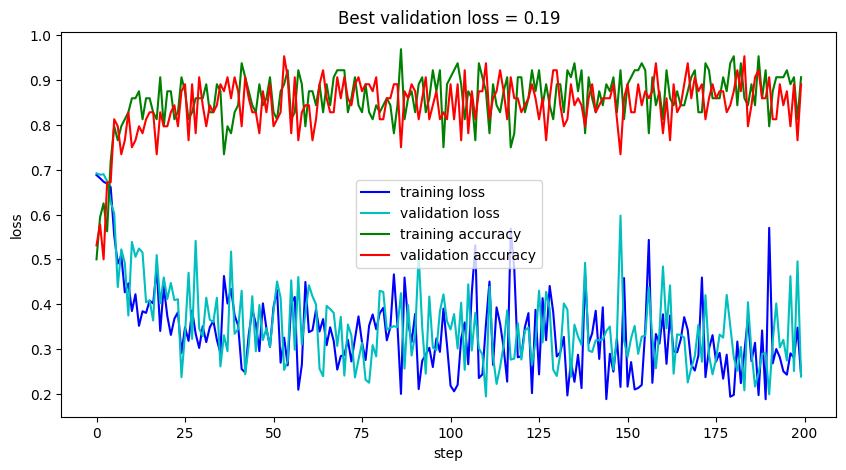

In [ ]:
trainer.train_network(
    dataloader_train,
    dataloader_val,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs
)


Again, we will load the best model (the one that achieved the lowest validation loss during training) and inspect the results on the validation set:

image 0 Dice score: 0.6555117526751045


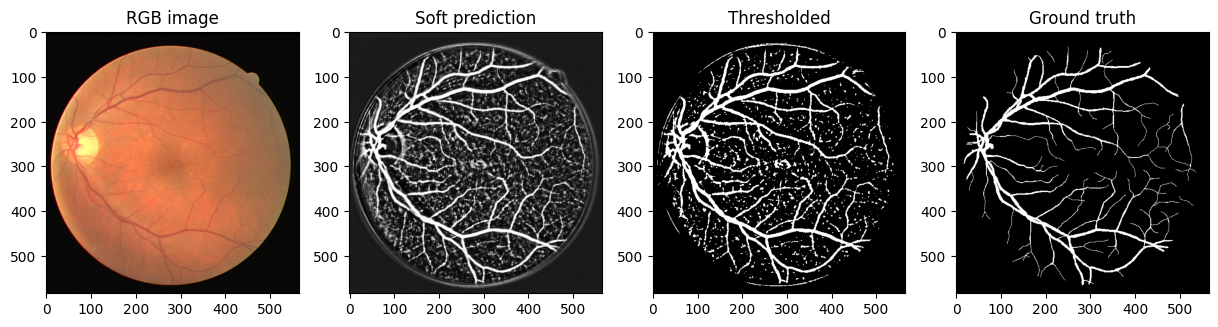

image 1 Dice score: 0.6651026545002073


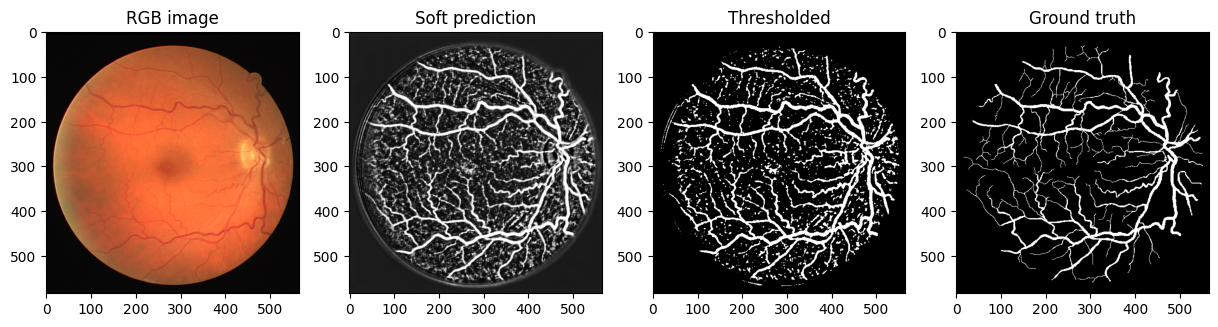

image 2 Dice score: 0.4469310132250823


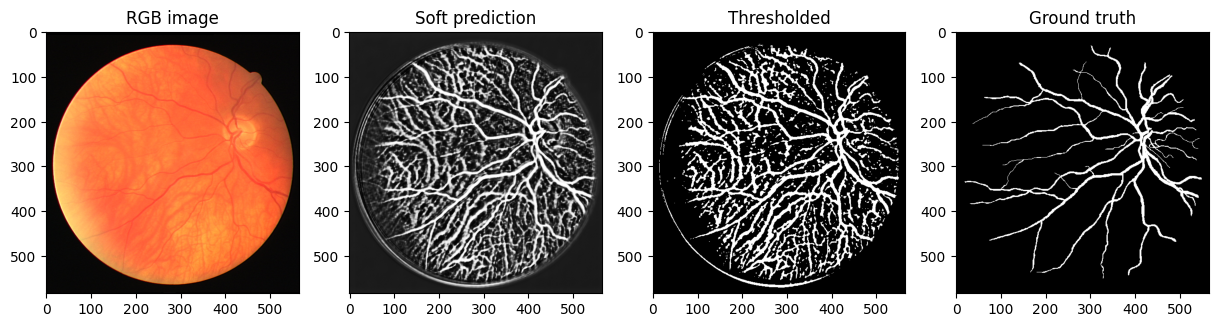

image 3 Dice score: 0.7191611144418176


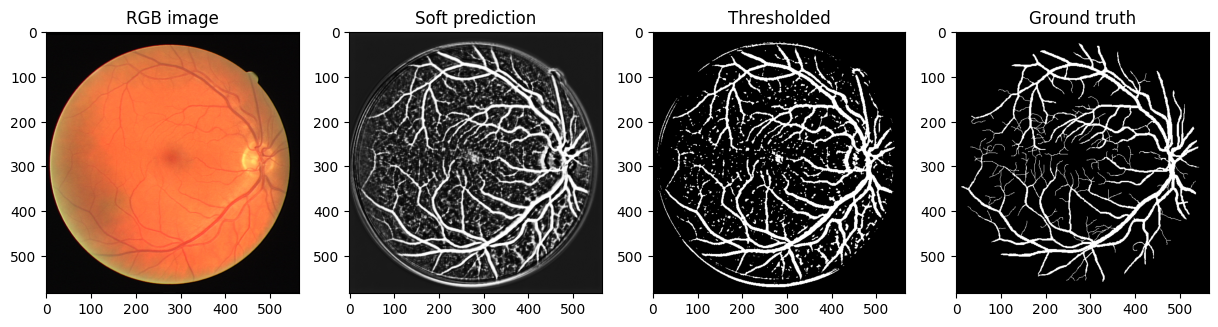

mean dice 0.6216766337105529


In [ ]:
trainer_test = Trainer(network=network_2, optimizer=optimizer, loss_function=loss_function, name='model_2', batch_size=batch_size)
trainer_test.load_best_network()

lbls, msks, output = process_basic(trainer_test, validation_data, stride=stride)
check_results(validation_data.imgs, lbls, msks, output)


------------
# Part 2: U-Net

As you might have observed, the use of dilated convolutions in the fully-convoutional network gives a full-resolution output, but the processing is slow due to the large feature maps. In the second part of this assignment, we are going to work with **U-Net** for retina vessels segmentation.

## Tasks
These are the main tasks of the second part of this assignment:
1. Implement a batch creator that generates image and label patches for U-Net training.
2. Train a baseline U-Net model.
3. Improve the U-Net implementation to increase performance.

## Implement a batch creator that generates image and mask patches for U-Net training

We implement here the ``UNetPatchDataset``. Note that our previous model predicted a label for the center pixel, given the surrounding image patch. Now the U-Net model will predict labels for all pixels in a patch. Therefore, you need to implement a patch dataset to generate image patches and the corresponding whole segmentation annotation patches. For simplicity, this creator makes use of the previous  ``BalancedSampler``, although it is not relevant anymore that center pixels of the patches belong to positive or negative samples in a balanced way.

In [ ]:
class UNetPatchDataset(PatchDataset):

    def __init__(self, patch_extractor, dataset, border_pad_size, batch_size):
        super(UNetPatchDataset, self).__init__(patch_extractor, dataset, border_pad_size, batch_size)

    def __getitem__(self, index):
        '''
        return image patches (x) with corresponding label patches (y) in one-hot structure
        '''
        x_data = np.zeros((3, *self.patch_extractor.patch_size))
        y_data = np.zeros((2, *self.patch_extractor.patch_size))  # one-hot encoding

        locations = self.patch_location_sampler.generate_sample_locations(2)
        index = np.random.randint(0, 2)
        i, y, x = locations[index]

        # YOUR CODE HERE
        image_patch, label_patch = self.patch_extractor.get_patch(self.imgs[i], self.lbls[i], (y, x))
        y_data[1] = label_patch[:,:,0] > 0
        y_data[0] = 1-(label_patch[:,:,0] > 0)
        x_data = np.moveaxis(image_patch, -1, 0).copy() # Move color channel to first-dimension

        return x_data.copy(), y_data.copy()

In [ ]:
'''DO NOT MODIFY THIS CELL'''

'DO NOT MODIFY THIS CELL'

## Implement and train a baseline U-Net model

Here we explicitly define a baseline U-Net model. It has a depth of 4 (with 3 pooling layers), it uses 'same' convolutions and it starts with 16 filters in the first layer. We will still use patch-based training for U-Net. We have defined the input to the network to be an image patch of size 88x88 (you could also try with other patch sizes). Let's call it ``UNet1``.

In [ ]:
class UNet1(nn.Module):
    def __init__(self):
        super(UNet1, self).__init__()

        # Define the first set of layers
        self.c1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.p1 = nn.MaxPool2d(kernel_size=2)

        # Define the second set of layers
        self.c2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.p2 = nn.MaxPool2d(kernel_size=2)

        # Define the third set of layers
        self.c3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.p3 = nn.MaxPool2d(kernel_size=2)

        # Define the fourth set of layers
        self.c4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        # Define the up-convolution and concatenation layers
        self.u2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.cm2 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.u3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.cm3 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.u4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.cm4 = nn.Sequential(
            nn.Conv2d(32 + 16, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        # Define the output layer
        self.predictions = nn.Conv2d(16, 2, kernel_size=1)

    def forward(self, x):
        # YOUR CODE HERE
        x1 = self.c1(x)
        p1 = self.p1(x1)

        x2 = self.c2(p1)
        p2 = self.p2(x2)

        x3 = self.c3(p2)
        p3 = self.p3(x3)

        x4 = self.c4(p3)

        u2 = self.u2(x4)
        cat2 = torch.cat((x3,u2), dim=1)
        x5 = self.cm2(cat2)

        u3 = self.u3(x5)
        cat3 = torch.cat((x2,u3), dim=1)
        x6 = self.cm3(cat3)

        u4 = self.u4(x6)
        cat4 = torch.cat((x1,u4), dim=1)
        x7 = self.cm4(cat4)

        # YOUR CODE HERE
        predictions = self.predictions(x7)

        return predictions

Initialize all training parameters, define an image generator that will be able to return mini-batches during the training procedure, define a loss function, the mini-batch size, and other parameters needed to train U-Net. Replace ``None`` with some values.

In [ ]:
learning_rate = None
patch_size = (None, None)
batch_size = None
steps_per_epoch = None
epochs = None
# YOUR CODE HERE
learning_rate = 1e-05#0.1
patch_size = (88, 88)
batch_size = 64
steps_per_epoch = 20
epochs = 200

In [ ]:
'''DO NOT MODIFY THIS CELL'''

'DO NOT MODIFY THIS CELL'

Make an instance of the ``UNet1`` model:

In [ ]:
unet_1 = UNet1()
print(unet_1)
print(f"Number of parameters: {count_params(unet_1)}")
optimizer_3 = torch.optim.Adam(unet_1.parameters(), lr=learning_rate)


UNet1(
  (c1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (p3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 128, ker

In [ ]:
'''DO NOT MODIFY THIS CELL'''

'DO NOT MODIFY THIS CELL'

In [ ]:
class PatchExtractor:

    def __init__(self, patch_size, horizontal_flipping=True):
        self.patch_size = patch_size
        self.horizontal_flipping = horizontal_flipping

    def get_patch(self, image, mask, location):
        '''
        image: a numpy array representing the input image,
        mask: a numpy array representing the corresponding segmentation annotation
        location: a tuple with an y and x coordinate

        return a patch from the image at `location`, representing the center of the patch, and the corresponding label patch
        if self.horizontal_flipping = True, there is a 50% chance the patch is horizontally flipped
        '''
        y, x = location
        py, px = self.patch_size

        # - patch should be a numpy array of size <h, w>
        # - the patch should be normalized (intensity values between 0-1)

        img_patch = image[y - py//2:y + py-py//2, x - px//2:x + px-px//2]
        img_patch = img_patch/255
        label_patch = mask[y - py//2:y + py-py//2, x - px//2:x + px-px//2]
        # YOUR CODE HERE

        # - if self.flipping = True, there should be a 50% chance to apply a horizontal flip to the patch
        if self.horizontal_flipping:
            do_flipping = np.random.choice([True, False])

            # YOUR CODE HERE

            # - if do_flipping == True, flip the patch horizontally
            if do_flipping:
                img_patch_flipped = np.fliplr(img_patch)
                label_patch_flipped = np.fliplr(label_patch)

                # YOUR CODE HERE

                img_patch = img_patch_flipped
                label_patch = label_patch_flipped

        assert img_patch.ndim == label_patch.ndim
        return img_patch, label_patch

In [ ]:
patch_extractor_train = PatchExtractor(patch_size=patch_size, horizontal_flipping=True)
patch_dataset_train = UNetPatchDataset(patch_extractor=patch_extractor_train, dataset=train_data, border_pad_size=patch_extractor_train.patch_size, batch_size=batch_size)
dataloader_train = torch.utils.data.DataLoader(patch_dataset_train, batch_size)
patch_extractor_val = PatchExtractor(patch_size=patch_size, horizontal_flipping=False)
patch_dataset_val = UNetPatchDataset(patch_extractor=patch_extractor_val, dataset=validation_data, border_pad_size=patch_size, batch_size=batch_size)
dataloader_val = torch.utils.data.DataLoader(patch_dataset_val, batch_size)

# define the trainer
trainer = Trainer(
    network=unet_1,
    optimizer=optimizer_3,
    loss_function=loss_function,
    name='unet_1',
    batch_size=batch_size,
)

# Perform an evaluation pass (of the randomly initialized network, to see if everything is working)
loss, accuracy = trainer.validate_dataset(dataloader_val)
print(f"validation loss {loss}, validation accuracy {accuracy}")


validation loss 0.7461722493171692, validation accuracy 0.15635088455578514


Now we train the model:

Epochs:   0%|          | 1/200 [00:01<04:40,  1.41s/it]

Epoch 0: train loss: 0.7483212947845459, train accuracy: 0.13170882295971073, val loss: 0.7445485591888428, val accuracy: 0.16004124160640495


Epochs:   1%|          | 2/200 [00:02<04:31,  1.37s/it]

Epoch 1: train loss: 0.7468641400337219, train accuracy: 0.13469904119318182, val loss: 0.7449429035186768, val accuracy: 0.15020903279958678


Epochs:   2%|▏         | 3/200 [00:04<04:28,  1.36s/it]

Epoch 2: train loss: 0.7443430423736572, train accuracy: 0.145826607696281, val loss: 0.744198739528656, val accuracy: 0.14750936208677687


Epochs:   2%|▏         | 4/200 [00:05<04:27,  1.37s/it]

Epoch 3: train loss: 0.7454076409339905, train accuracy: 0.1289990637913223, val loss: 0.7421921491622925, val accuracy: 0.15317705643078514


Epochs:   2%|▎         | 5/200 [00:06<04:26,  1.37s/it]

Epoch 4: train loss: 0.741391122341156, train accuracy: 0.14693230242768596, val loss: 0.7425509691238403, val accuracy: 0.13811297456095042


Epochs:   3%|▎         | 6/200 [00:08<04:26,  1.37s/it]

Epoch 5: train loss: 0.7400672435760498, train accuracy: 0.14052209775309918, val loss: 0.7380658388137817, val accuracy: 0.15520281831095042


Epochs:   4%|▎         | 7/200 [00:09<04:24,  1.37s/it]

Epoch 6: train loss: 0.7391336560249329, train accuracy: 0.12189275568181818, val loss: 0.7367247939109802, val accuracy: 0.13967466748450413


Epochs:   4%|▍         | 8/200 [00:10<04:23,  1.37s/it]

Epoch 7: train loss: 0.7325930595397949, train accuracy: 0.1367833161157025, val loss: 0.7322065234184265, val accuracy: 0.13530233083677687


Epochs:   4%|▍         | 9/200 [00:12<04:21,  1.37s/it]

Epoch 8: train loss: 0.7246904373168945, train accuracy: 0.11441115702479339, val loss: 0.7201445698738098, val accuracy: 0.15298134039256198


Epochs:   5%|▌         | 10/200 [00:13<04:21,  1.37s/it]

Epoch 9: train loss: 0.6911962032318115, train accuracy: 0.6260532347623967, val loss: 0.6889774203300476, val accuracy: 0.6418134200671488


Epochs:   6%|▌         | 11/200 [00:15<04:19,  1.38s/it]

Epoch 10: train loss: 0.6001196503639221, train accuracy: 0.830925555268595, val loss: 0.5953948497772217, val accuracy: 0.8238918840392562


Epochs:   6%|▌         | 12/200 [00:16<04:18,  1.38s/it]

Epoch 11: train loss: 0.48347583413124084, train accuracy: 0.8377574573863636, val loss: 0.4479610025882721, val accuracy: 0.8591207709194215


Epochs:   6%|▋         | 13/200 [00:17<04:18,  1.38s/it]

Epoch 12: train loss: 0.43992555141448975, train accuracy: 0.8665196442407025, val loss: 0.448133647441864, val accuracy: 0.8597442374741735


Epochs:   7%|▋         | 14/200 [00:19<04:19,  1.39s/it]

Epoch 13: train loss: 0.4493517279624939, train accuracy: 0.8550046810433884, val loss: 0.4456821084022522, val accuracy: 0.8595868575671488


Epochs:   8%|▊         | 15/200 [00:20<04:18,  1.40s/it]

Epoch 14: train loss: 0.42533135414123535, train accuracy: 0.8700929752066116, val loss: 0.43056720495224, val accuracy: 0.8652706934400827


Epochs:   8%|▊         | 16/200 [00:22<04:16,  1.39s/it]

Epoch 15: train loss: 0.4538074731826782, train accuracy: 0.8532735020661157, val loss: 0.43425804376602173, val accuracy: 0.8612353112086777


Epochs:   8%|▊         | 17/200 [00:23<04:15,  1.40s/it]

Epoch 16: train loss: 0.46029460430145264, train accuracy: 0.8486953609245868, val loss: 0.4281522035598755, val accuracy: 0.8642194763688017


Epochs:   9%|▉         | 18/200 [00:24<04:14,  1.40s/it]

Epoch 17: train loss: 0.427715003490448, train accuracy: 0.865438161802686, val loss: 0.42693138122558594, val accuracy: 0.8653231534090909


Epochs:  10%|▉         | 19/200 [00:26<04:14,  1.40s/it]

Epoch 18: train loss: 0.45728805661201477, train accuracy: 0.847696603822314, val loss: 0.4152055084705353, val accuracy: 0.8714004390495868


Epochs:  10%|█         | 20/200 [00:27<04:13,  1.41s/it]

Epoch 19: train loss: 0.42752987146377563, train accuracy: 0.8641750871642562, val loss: 0.4339514374732971, val accuracy: 0.8585901181559917


Epochs:  10%|█         | 21/200 [00:29<04:11,  1.41s/it]

Epoch 20: train loss: 0.43033313751220703, train accuracy: 0.8597866089876033, val loss: 0.4330574870109558, val accuracy: 0.858927072572314


Epochs:  11%|█         | 22/200 [00:30<04:10,  1.41s/it]

Epoch 21: train loss: 0.4054686427116394, train accuracy: 0.8743442503873967, val loss: 0.41877835988998413, val accuracy: 0.8661625129132231


Epochs:  12%|█▏        | 23/200 [00:32<04:31,  1.53s/it]

Epoch 22: train loss: 0.39981430768966675, train accuracy: 0.877102434142562, val loss: 0.444343239068985, val accuracy: 0.8510056172520661


Epochs:  12%|█▏        | 24/200 [00:33<04:23,  1.50s/it]

Epoch 23: train loss: 0.4209209382534027, train accuracy: 0.8628151633522727, val loss: 0.41162240505218506, val accuracy: 0.8670281024018595


Epochs:  12%|█▎        | 25/200 [00:35<04:16,  1.47s/it]

Epoch 24: train loss: 0.4091481566429138, train accuracy: 0.8688117413481405, val loss: 0.42838555574417114, val accuracy: 0.8580836776859504


Epochs:  13%|█▎        | 26/200 [00:36<04:11,  1.44s/it]

Epoch 25: train loss: 0.42373067140579224, train accuracy: 0.8590602401859504, val loss: 0.4461959898471832, val accuracy: 0.8479689921229339


Epochs:  14%|█▎        | 27/200 [00:37<04:07,  1.43s/it]

Epoch 26: train loss: 0.43936339020729065, train accuracy: 0.8494984019886364, val loss: 0.4024885892868042, val accuracy: 0.8715658897210744


Epochs:  14%|█▍        | 28/200 [00:39<04:03,  1.42s/it]

Epoch 27: train loss: 0.4090525507926941, train accuracy: 0.8647017045454546, val loss: 0.4470495283603668, val accuracy: 0.8421479532541323


Epochs:  14%|█▍        | 29/200 [00:40<04:01,  1.41s/it]

Epoch 28: train loss: 0.41267338395118713, train accuracy: 0.8644656346849173, val loss: 0.39482104778289795, val accuracy: 0.872762380552686


Epochs:  15%|█▌        | 30/200 [00:42<03:59,  1.41s/it]

Epoch 29: train loss: 0.3915686309337616, train accuracy: 0.8743563565340909, val loss: 0.39431560039520264, val accuracy: 0.8721066309400827


Epochs:  16%|█▌        | 31/200 [00:43<03:57,  1.40s/it]

Epoch 30: train loss: 0.40017837285995483, train accuracy: 0.8671854823088843, val loss: 0.42588773369789124, val accuracy: 0.8514595977530992


Epochs:  16%|█▌        | 32/200 [00:44<03:55,  1.40s/it]

Epoch 31: train loss: 0.4153902530670166, train accuracy: 0.8579303331611571, val loss: 0.42976856231689453, val accuracy: 0.8485238571797521


Epochs:  16%|█▋        | 33/200 [00:46<03:53,  1.40s/it]

Epoch 32: train loss: 0.402108371257782, train accuracy: 0.8640923618285123, val loss: 0.42799320816993713, val accuracy: 0.85011178008781


Epochs:  17%|█▋        | 34/200 [00:47<03:51,  1.39s/it]

Epoch 33: train loss: 0.43594610691070557, train accuracy: 0.8439477337293388, val loss: 0.40237152576446533, val accuracy: 0.8635475852272727


Epochs:  18%|█▊        | 35/200 [00:49<03:49,  1.39s/it]

Epoch 34: train loss: 0.4223450720310211, train accuracy: 0.8504749644886364, val loss: 0.3986894488334656, val accuracy: 0.8665277150051653


Epochs:  18%|█▊        | 36/200 [00:50<03:47,  1.39s/it]

Epoch 35: train loss: 0.3807109296321869, train accuracy: 0.8738035091683884, val loss: 0.38418611884117126, val accuracy: 0.8722902408316116


Epochs:  18%|█▊        | 37/200 [00:51<03:45,  1.38s/it]

Epoch 36: train loss: 0.3839540481567383, train accuracy: 0.8726796552169421, val loss: 0.40292245149612427, val accuracy: 0.8640419195506198


Epochs:  19%|█▉        | 38/200 [00:53<03:43,  1.38s/it]

Epoch 37: train loss: 0.40580835938453674, train accuracy: 0.8605775439049587, val loss: 0.41686108708381653, val accuracy: 0.8507655120092975


Epochs:  20%|█▉        | 39/200 [00:54<03:41,  1.38s/it]

Epoch 38: train loss: 0.39262205362319946, train accuracy: 0.8664288481404959, val loss: 0.41060328483581543, val accuracy: 0.8530697152634298


Epochs:  20%|██        | 40/200 [00:55<03:40,  1.38s/it]

Epoch 39: train loss: 0.4370383620262146, train accuracy: 0.84181099883781, val loss: 0.4145730137825012, val accuracy: 0.8532916612861571


Epochs:  20%|██        | 41/200 [00:57<03:38,  1.38s/it]

Epoch 40: train loss: 0.395576536655426, train accuracy: 0.8617478047520661, val loss: 0.411101758480072, val accuracy: 0.8534429881198347


Epochs:  21%|██        | 42/200 [00:58<03:36,  1.37s/it]

Epoch 41: train loss: 0.36974549293518066, train accuracy: 0.8782303234762396, val loss: 0.40408265590667725, val accuracy: 0.8573109019886364


Epochs:  22%|██▏       | 43/200 [01:00<03:35,  1.37s/it]

Epoch 42: train loss: 0.3818122148513794, train accuracy: 0.8718826672262396, val loss: 0.4315332770347595, val accuracy: 0.8397166354597108


Epochs:  22%|██▏       | 44/200 [01:01<03:33,  1.37s/it]

Epoch 43: train loss: 0.3964981138706207, train accuracy: 0.8588645241477273, val loss: 0.3900744616985321, val accuracy: 0.8680571248708677


Epochs:  22%|██▎       | 45/200 [01:02<03:31,  1.37s/it]

Epoch 44: train loss: 0.39937224984169006, train accuracy: 0.8604504293646694, val loss: 0.3991489112377167, val accuracy: 0.85838431366219


Epochs:  23%|██▎       | 46/200 [01:04<03:30,  1.37s/it]

Epoch 45: train loss: 0.35482168197631836, train accuracy: 0.8799070247933884, val loss: 0.3955368399620056, val accuracy: 0.8631016754907025


Epochs:  24%|██▎       | 47/200 [01:05<03:28,  1.37s/it]

Epoch 46: train loss: 0.38842862844467163, train accuracy: 0.864162981017562, val loss: 0.4258105456829071, val accuracy: 0.8466998644111571


Epochs:  24%|██▍       | 48/200 [01:06<03:27,  1.36s/it]

Epoch 47: train loss: 0.4113929569721222, train accuracy: 0.8519983212809917, val loss: 0.4142912030220032, val accuracy: 0.8521234181301653


Epochs:  24%|██▍       | 49/200 [01:08<03:26,  1.37s/it]

Epoch 48: train loss: 0.40052106976509094, train accuracy: 0.8606380746384298, val loss: 0.4374406039714813, val accuracy: 0.8379188726756198


Epochs:  25%|██▌       | 50/200 [01:09<03:25,  1.37s/it]

Epoch 49: train loss: 0.3794707953929901, train accuracy: 0.8695421455320248, val loss: 0.4001320004463196, val accuracy: 0.8577023340650827


Epochs:  26%|██▌       | 51/200 [01:11<03:23,  1.37s/it]

Epoch 50: train loss: 0.39624708890914917, train accuracy: 0.8591127001549587, val loss: 0.41407376527786255, val accuracy: 0.8516250484245868


Epochs:  26%|██▌       | 52/200 [01:12<03:21,  1.36s/it]

Epoch 51: train loss: 0.37809085845947266, train accuracy: 0.8701111344266529, val loss: 0.41949254274368286, val accuracy: 0.8482494511880165


Epochs:  26%|██▋       | 53/200 [01:14<03:33,  1.45s/it]

Epoch 52: train loss: 0.3869123160839081, train accuracy: 0.8662432205578512, val loss: 0.4155767560005188, val accuracy: 0.8508885911673554


Epochs:  27%|██▋       | 54/200 [01:15<03:27,  1.42s/it]

Epoch 53: train loss: 0.3668583631515503, train accuracy: 0.8768845235020661, val loss: 0.40759578347206116, val accuracy: 0.8567782315340909


Epochs:  28%|██▊       | 55/200 [01:16<03:23,  1.41s/it]

Epoch 54: train loss: 0.41109248995780945, train accuracy: 0.8545285059400827, val loss: 0.4072560966014862, val accuracy: 0.8540866315857438


Epochs:  28%|██▊       | 56/200 [01:18<03:21,  1.40s/it]

Epoch 55: train loss: 0.40954187512397766, train accuracy: 0.8520810466167356, val loss: 0.36850056052207947, val accuracy: 0.8743482857696281


Epochs:  28%|██▊       | 57/200 [01:19<03:18,  1.39s/it]

Epoch 56: train loss: 0.40088948607444763, train accuracy: 0.8600368026859504, val loss: 0.3900771737098694, val accuracy: 0.8626476949896694


Epochs:  29%|██▉       | 58/200 [01:20<03:16,  1.38s/it]

Epoch 57: train loss: 0.37891942262649536, train accuracy: 0.8697761977014463, val loss: 0.42655235528945923, val accuracy: 0.8415365928460744


Epochs:  30%|██▉       | 59/200 [01:22<03:15,  1.38s/it]

Epoch 58: train loss: 0.3991030752658844, train accuracy: 0.8575792549070248, val loss: 0.3742051422595978, val accuracy: 0.8717232696280992


Epochs:  30%|███       | 60/200 [01:23<03:12,  1.38s/it]

Epoch 59: train loss: 0.40715983510017395, train accuracy: 0.8554808561466942, val loss: 0.39342013001441956, val accuracy: 0.8623309174845041


Epochs:  30%|███       | 61/200 [01:24<03:10,  1.37s/it]

Epoch 60: train loss: 0.37856003642082214, train accuracy: 0.8695966231921488, val loss: 0.41841068863868713, val accuracy: 0.8475109762396694


Epochs:  31%|███       | 62/200 [01:26<03:09,  1.37s/it]

Epoch 61: train loss: 0.4065137207508087, train accuracy: 0.8546455320247934, val loss: 0.38736534118652344, val accuracy: 0.8633861699380165


Epochs:  32%|███▏      | 63/200 [01:27<03:07,  1.37s/it]

Epoch 62: train loss: 0.4270862638950348, train accuracy: 0.8415587874483471, val loss: 0.4324926435947418, val accuracy: 0.8393231856921488


Epochs:  32%|███▏      | 64/200 [01:29<03:06,  1.37s/it]

Epoch 63: train loss: 0.44655871391296387, train accuracy: 0.8345170454545454, val loss: 0.39634057879447937, val accuracy: 0.8564654894111571


Epochs:  32%|███▎      | 65/200 [01:30<03:05,  1.37s/it]

Epoch 64: train loss: 0.4090622663497925, train accuracy: 0.8556241122159091, val loss: 0.41898465156555176, val accuracy: 0.8473616670971075


Epochs:  33%|███▎      | 66/200 [01:31<03:03,  1.37s/it]

Epoch 65: train loss: 0.3771563172340393, train accuracy: 0.8669050232438017, val loss: 0.42475107312202454, val accuracy: 0.8406588972107438


Epochs:  34%|███▎      | 67/200 [01:33<03:03,  1.38s/it]

Epoch 66: train loss: 0.3662419319152832, train accuracy: 0.8742312596849173, val loss: 0.3738193213939667, val accuracy: 0.8714952705320248


Epochs:  34%|███▍      | 68/200 [01:34<03:01,  1.38s/it]

Epoch 67: train loss: 0.39897632598876953, train accuracy: 0.8577547940340909, val loss: 0.40466728806495667, val accuracy: 0.8532593782283058


Epochs:  34%|███▍      | 69/200 [01:35<03:00,  1.38s/it]

Epoch 68: train loss: 0.3783285617828369, train accuracy: 0.8710594492510331, val loss: 0.3790130317211151, val accuracy: 0.8703693988894629


Epochs:  35%|███▌      | 70/200 [01:37<02:59,  1.38s/it]

Epoch 69: train loss: 0.3774038851261139, train accuracy: 0.8682205578512396, val loss: 0.39036285877227783, val accuracy: 0.8655208871384298


Epochs:  36%|███▌      | 71/200 [01:38<02:57,  1.38s/it]

Epoch 70: train loss: 0.38862818479537964, train accuracy: 0.86033743866219, val loss: 0.4124486744403839, val accuracy: 0.8492865444214877


Epochs:  36%|███▌      | 72/200 [01:40<02:56,  1.38s/it]

Epoch 71: train loss: 0.39730170369148254, train accuracy: 0.8566652408316116, val loss: 0.3892802596092224, val accuracy: 0.8626255003873967


Epochs:  36%|███▋      | 73/200 [01:41<02:54,  1.38s/it]

Epoch 72: train loss: 0.3614200949668884, train accuracy: 0.8800704577737604, val loss: 0.37985241413116455, val accuracy: 0.8664671842716942


Epochs:  37%|███▋      | 74/200 [01:42<02:53,  1.38s/it]

Epoch 73: train loss: 0.3702220916748047, train accuracy: 0.8742393304493802, val loss: 0.39034196734428406, val accuracy: 0.8642275471332644


Epochs:  38%|███▊      | 75/200 [01:44<02:52,  1.38s/it]

Epoch 74: train loss: 0.3821428418159485, train accuracy: 0.8645523954028925, val loss: 0.38917312026023865, val accuracy: 0.8639470880681818


Epochs:  38%|███▊      | 76/200 [01:45<02:51,  1.38s/it]

Epoch 75: train loss: 0.3837450444698334, train accuracy: 0.8707184594524794, val loss: 0.39817580580711365, val accuracy: 0.8549744156766529


Epochs:  38%|███▊      | 77/200 [01:47<02:50,  1.38s/it]

Epoch 76: train loss: 0.3854215443134308, train accuracy: 0.8661524244576446, val loss: 0.3689953088760376, val accuracy: 0.87965279571281


Epochs:  39%|███▉      | 78/200 [01:48<02:48,  1.38s/it]

Epoch 77: train loss: 0.4235578775405884, train accuracy: 0.8439880875516529, val loss: 0.3736274242401123, val accuracy: 0.8706559110278925


Epochs:  40%|███▉      | 79/200 [01:49<02:47,  1.38s/it]

Epoch 78: train loss: 0.42829447984695435, train accuracy: 0.8410927008006198, val loss: 0.41119667887687683, val accuracy: 0.8524079125774794


Epochs:  40%|████      | 80/200 [01:51<02:45,  1.38s/it]

Epoch 79: train loss: 0.41028785705566406, train accuracy: 0.8530737506456612, val loss: 0.41128700971603394, val accuracy: 0.84986763946281


Epochs:  40%|████      | 81/200 [01:52<02:44,  1.38s/it]

Epoch 80: train loss: 0.38669928908348083, train accuracy: 0.8645180946539256, val loss: 0.4043809771537781, val accuracy: 0.8559086066632231


Epochs:  41%|████      | 82/200 [01:53<02:42,  1.38s/it]

Epoch 81: train loss: 0.4022297263145447, train accuracy: 0.8578980501033058, val loss: 0.38437625765800476, val accuracy: 0.8687754229080579


Epochs:  42%|████▏     | 83/200 [01:55<02:41,  1.38s/it]

Epoch 82: train loss: 0.40475720167160034, train accuracy: 0.8519256844008265, val loss: 0.42723554372787476, val accuracy: 0.8427754551911157


Epochs:  42%|████▏     | 84/200 [01:56<02:40,  1.38s/it]

Epoch 83: train loss: 0.40223512053489685, train accuracy: 0.8557249967716942, val loss: 0.38849109411239624, val accuracy: 0.8640156895661157


Epochs:  42%|████▎     | 85/200 [01:58<02:39,  1.38s/it]

Epoch 84: train loss: 0.3722180724143982, train accuracy: 0.86937064178719, val loss: 0.38796478509902954, val accuracy: 0.8657024793388429


Epochs:  43%|████▎     | 86/200 [01:59<02:38,  1.39s/it]

Epoch 85: train loss: 0.39848682284355164, train accuracy: 0.8604241993801653, val loss: 0.4193620979785919, val accuracy: 0.8449828092716942


Epochs:  44%|████▎     | 87/200 [02:00<02:36,  1.39s/it]

Epoch 86: train loss: 0.38600271940231323, train accuracy: 0.8640762202995868, val loss: 0.4151635766029358, val accuracy: 0.8466817051911157


Epochs:  44%|████▍     | 88/200 [02:02<02:35,  1.38s/it]

Epoch 87: train loss: 0.3862069249153137, train accuracy: 0.8638784865702479, val loss: 0.38784563541412354, val accuracy: 0.8610738959194215


Epochs:  44%|████▍     | 89/200 [02:03<02:33,  1.38s/it]

Epoch 88: train loss: 0.389748752117157, train accuracy: 0.8601296164772727, val loss: 0.40985119342803955, val accuracy: 0.851901472107438


Epochs:  45%|████▌     | 90/200 [02:04<02:31,  1.38s/it]

Epoch 89: train loss: 0.3842647075653076, train accuracy: 0.8666507941632231, val loss: 0.40169084072113037, val accuracy: 0.8566390108471075


Epochs:  46%|████▌     | 91/200 [02:06<02:30,  1.38s/it]

Epoch 90: train loss: 0.38251033425331116, train accuracy: 0.8666972010588843, val loss: 0.352882444858551, val accuracy: 0.8844992897727273


Epochs:  46%|████▌     | 92/200 [02:07<02:29,  1.38s/it]

Epoch 91: train loss: 0.40073201060295105, train accuracy: 0.857082902892562, val loss: 0.39157095551490784, val accuracy: 0.8621513429752066


Epochs:  46%|████▋     | 93/200 [02:09<02:27,  1.38s/it]

Epoch 92: train loss: 0.39712709188461304, train accuracy: 0.8592579739152892, val loss: 0.39284205436706543, val accuracy: 0.8612837357954546


Epochs:  47%|████▋     | 94/200 [02:10<02:26,  1.38s/it]

Epoch 93: train loss: 0.3749232888221741, train accuracy: 0.8683739023760331, val loss: 0.37948158383369446, val accuracy: 0.868971138946281


Epochs:  48%|████▊     | 95/200 [02:11<02:25,  1.38s/it]

Epoch 94: train loss: 0.37531039118766785, train accuracy: 0.869215279571281, val loss: 0.3871968686580658, val accuracy: 0.8649579513171488


Epochs:  48%|████▊     | 96/200 [02:13<02:23,  1.38s/it]

Epoch 95: train loss: 0.386033296585083, train accuracy: 0.8660676814307852, val loss: 0.41461655497550964, val accuracy: 0.851148873321281


Epochs:  48%|████▊     | 97/200 [02:14<02:22,  1.38s/it]

Epoch 96: train loss: 0.3879019021987915, train accuracy: 0.8627505972365702, val loss: 0.3688231110572815, val accuracy: 0.8757001388171488


Epochs:  49%|████▉     | 98/200 [02:16<02:20,  1.38s/it]

Epoch 97: train loss: 0.3975428640842438, train accuracy: 0.8590703286415289, val loss: 0.4000299572944641, val accuracy: 0.8593790353822314


Epochs:  50%|████▉     | 99/200 [02:17<02:19,  1.38s/it]

Epoch 98: train loss: 0.4057702124118805, train accuracy: 0.8532694666838843, val loss: 0.3975491225719452, val accuracy: 0.8590319925103306


Epochs:  50%|█████     | 100/200 [02:18<02:17,  1.38s/it]

Epoch 99: train loss: 0.38069140911102295, train accuracy: 0.8665014850206612, val loss: 0.3763783276081085, val accuracy: 0.8716627388946281


Epochs:  50%|█████     | 101/200 [02:20<02:16,  1.37s/it]

Epoch 100: train loss: 0.3980655372142792, train accuracy: 0.8582168452995868, val loss: 0.38331571221351624, val accuracy: 0.862020193052686


Epochs:  51%|█████     | 102/200 [02:21<02:14,  1.37s/it]

Epoch 101: train loss: 0.4022825360298157, train accuracy: 0.8571615928460744, val loss: 0.40527650713920593, val accuracy: 0.8506484859245868


Epochs:  52%|█████▏    | 103/200 [02:22<02:13,  1.38s/it]

Epoch 102: train loss: 0.3887540400028229, train accuracy: 0.861382602660124, val loss: 0.3761317729949951, val accuracy: 0.870978741606405


Epochs:  52%|█████▏    | 104/200 [02:24<02:12,  1.38s/it]

Epoch 103: train loss: 0.36955541372299194, train accuracy: 0.8710029538997934, val loss: 0.44876202940940857, val accuracy: 0.824517368285124


Epochs:  52%|█████▎    | 105/200 [02:25<02:10,  1.38s/it]

Epoch 104: train loss: 0.39743635058403015, train accuracy: 0.857218088197314, val loss: 0.4018007218837738, val accuracy: 0.8548715134297521


Epochs:  53%|█████▎    | 106/200 [02:27<02:09,  1.38s/it]

Epoch 105: train loss: 0.39799660444259644, train accuracy: 0.856241525697314, val loss: 0.37964603304862976, val accuracy: 0.8696067116477273


Epochs:  54%|█████▎    | 107/200 [02:28<02:07,  1.37s/it]

Epoch 106: train loss: 0.3758983910083771, train accuracy: 0.8694493317407025, val loss: 0.4221090078353882, val accuracy: 0.8460118317407025


Epochs:  54%|█████▍    | 108/200 [02:29<02:06,  1.37s/it]

Epoch 107: train loss: 0.3652755618095398, train accuracy: 0.8729681850464877, val loss: 0.43062880635261536, val accuracy: 0.8362522598140496


Epochs:  55%|█████▍    | 109/200 [02:31<02:04,  1.37s/it]

Epoch 108: train loss: 0.40567806363105774, train accuracy: 0.8542561176394629, val loss: 0.3994389474391937, val accuracy: 0.8555857760847108


Epochs:  55%|█████▌    | 110/200 [02:32<02:03,  1.37s/it]

Epoch 109: train loss: 0.3904033601284027, train accuracy: 0.8618628131456612, val loss: 0.39768463373184204, val accuracy: 0.8569396468233471


Epochs:  56%|█████▌    | 111/200 [02:33<02:02,  1.37s/it]

Epoch 110: train loss: 0.3939123749732971, train accuracy: 0.8610496836260331, val loss: 0.39400383830070496, val accuracy: 0.8572947604597108


Epochs:  56%|█████▌    | 112/200 [02:35<02:01,  1.38s/it]

Epoch 111: train loss: 0.38573601841926575, train accuracy: 0.8633115153667356, val loss: 0.38374289870262146, val accuracy: 0.8669938016528925


Epochs:  56%|█████▋    | 113/200 [02:36<01:59,  1.38s/it]

Epoch 112: train loss: 0.36128902435302734, train accuracy: 0.8783937564566116, val loss: 0.3884012699127197, val accuracy: 0.861368478822314


Epochs:  57%|█████▋    | 114/200 [02:38<01:58,  1.37s/it]

Epoch 113: train loss: 0.39527472853660583, train accuracy: 0.8601033864927686, val loss: 0.4340602457523346, val accuracy: 0.8393938048811983


Epochs:  57%|█████▊    | 115/200 [02:39<01:56,  1.37s/it]

Epoch 114: train loss: 0.38145747780799866, train accuracy: 0.8660979467975206, val loss: 0.40347325801849365, val accuracy: 0.8553577769886364


Epochs:  58%|█████▊    | 116/200 [02:40<01:55,  1.37s/it]

Epoch 115: train loss: 0.36307474970817566, train accuracy: 0.8773929816632231, val loss: 0.42000913619995117, val accuracy: 0.8452229145144629


Epochs:  58%|█████▊    | 117/200 [02:42<01:53,  1.37s/it]

Epoch 116: train loss: 0.40708014369010925, train accuracy: 0.8517481275826446, val loss: 0.40090423822402954, val accuracy: 0.8530535737345041


Epochs:  59%|█████▉    | 118/200 [02:43<01:52,  1.37s/it]

Epoch 117: train loss: 0.3728196918964386, train accuracy: 0.8689993866219008, val loss: 0.4181533455848694, val accuracy: 0.8492784736570248


Epochs:  60%|█████▉    | 119/200 [02:44<01:51,  1.37s/it]

Epoch 118: train loss: 0.38671448826789856, train accuracy: 0.8624862797004132, val loss: 0.3692314922809601, val accuracy: 0.8742070473915289


Epochs:  60%|██████    | 120/200 [02:46<01:49,  1.37s/it]

Epoch 119: train loss: 0.3906208872795105, train accuracy: 0.8599863604080579, val loss: 0.40006083250045776, val accuracy: 0.8583540482954546


Epochs:  60%|██████    | 121/200 [02:47<01:48,  1.38s/it]

Epoch 120: train loss: 0.42459988594055176, train accuracy: 0.8424647307592975, val loss: 0.4065483808517456, val accuracy: 0.8482817342458677


Epochs:  61%|██████    | 122/200 [02:48<01:47,  1.38s/it]

Epoch 121: train loss: 0.41925084590911865, train accuracy: 0.8471598979855371, val loss: 0.41967734694480896, val accuracy: 0.8429671358471075


Epochs:  62%|██████▏   | 123/200 [02:50<01:45,  1.37s/it]

Epoch 122: train loss: 0.3795194625854492, train accuracy: 0.8674397113894629, val loss: 0.41565993428230286, val accuracy: 0.8462781669679752


Epochs:  62%|██████▏   | 124/200 [02:51<01:44,  1.37s/it]

Epoch 123: train loss: 0.3482186794281006, train accuracy: 0.8842490960743802, val loss: 0.39768925309181213, val accuracy: 0.8577931301652892


Epochs:  62%|██████▎   | 125/200 [02:53<01:42,  1.37s/it]

Epoch 124: train loss: 0.40753304958343506, train accuracy: 0.8530172552944215, val loss: 0.36810290813446045, val accuracy: 0.8720017110020661


Epochs:  63%|██████▎   | 126/200 [02:54<01:41,  1.37s/it]

Epoch 125: train loss: 0.38886019587516785, train accuracy: 0.8620524761105371, val loss: 0.4192975163459778, val accuracy: 0.8454549489927686


Epochs:  64%|██████▎   | 127/200 [02:55<01:40,  1.37s/it]

Epoch 126: train loss: 0.4075046479701996, train accuracy: 0.849175571410124, val loss: 0.4265875816345215, val accuracy: 0.8383304816632231


Epochs:  64%|██████▍   | 128/200 [02:57<01:38,  1.37s/it]

Epoch 127: train loss: 0.3835482597351074, train accuracy: 0.8649700574638429, val loss: 0.43084996938705444, val accuracy: 0.8368273017820248


Epochs:  64%|██████▍   | 129/200 [02:58<01:37,  1.38s/it]

Epoch 128: train loss: 0.36928460001945496, train accuracy: 0.8714690405475206, val loss: 0.3803762197494507, val accuracy: 0.8679622933884298


Epochs:  65%|██████▌   | 130/200 [02:59<01:36,  1.38s/it]

Epoch 129: train loss: 0.35587573051452637, train accuracy: 0.8799958032024794, val loss: 0.41429808735847473, val accuracy: 0.8475351885330579


Epochs:  66%|██████▌   | 131/200 [03:01<01:35,  1.38s/it]

Epoch 130: train loss: 0.38050687313079834, train accuracy: 0.8628857825413223, val loss: 0.40407034754753113, val accuracy: 0.8522424619059917


Epochs:  66%|██████▌   | 132/200 [03:02<01:33,  1.38s/it]

Epoch 131: train loss: 0.3990277945995331, train accuracy: 0.8544094621642562, val loss: 0.3688914179801941, val accuracy: 0.8744834710743802


Epochs:  66%|██████▋   | 133/200 [03:04<01:32,  1.38s/it]

Epoch 132: train loss: 0.36937081813812256, train accuracy: 0.8728229112861571, val loss: 0.4015980362892151, val accuracy: 0.8545728951446281


Epochs:  67%|██████▋   | 134/200 [03:05<01:30,  1.38s/it]

Epoch 133: train loss: 0.38680121302604675, train accuracy: 0.8637251420454546, val loss: 0.4088452458381653, val accuracy: 0.8490585453254132


Epochs:  68%|██████▊   | 135/200 [03:06<01:29,  1.38s/it]

Epoch 134: train loss: 0.41475167870521545, train accuracy: 0.8465202899018595, val loss: 0.39309030771255493, val accuracy: 0.8592640269886364


Epochs:  68%|██████▊   | 136/200 [03:08<01:28,  1.38s/it]

Epoch 135: train loss: 0.380887895822525, train accuracy: 0.8622441567665289, val loss: 0.38784751296043396, val accuracy: 0.859768449767562


Epochs:  68%|██████▊   | 137/200 [03:09<01:26,  1.38s/it]

Epoch 136: train loss: 0.41211962699890137, train accuracy: 0.8511327317923554, val loss: 0.38686034083366394, val accuracy: 0.86376953125


Epochs:  69%|██████▉   | 138/200 [03:11<01:25,  1.38s/it]

Epoch 137: train loss: 0.3956485986709595, train accuracy: 0.8548008942407025, val loss: 0.3987646698951721, val accuracy: 0.85765189178719


Epochs:  70%|██████▉   | 139/200 [03:12<01:24,  1.38s/it]

Epoch 138: train loss: 0.383588045835495, train accuracy: 0.8637917258522727, val loss: 0.40002939105033875, val accuracy: 0.8568710453254132


Epochs:  70%|███████   | 140/200 [03:13<01:22,  1.38s/it]

Epoch 139: train loss: 0.38601136207580566, train accuracy: 0.8644959000516529, val loss: 0.39174750447273254, val accuracy: 0.8592539385330579


Epochs:  70%|███████   | 141/200 [03:15<01:21,  1.38s/it]

Epoch 140: train loss: 0.41297248005867004, train accuracy: 0.8493611989927686, val loss: 0.41713303327560425, val accuracy: 0.8443310950413223


Epochs:  71%|███████   | 142/200 [03:16<01:19,  1.38s/it]

Epoch 141: train loss: 0.391390323638916, train accuracy: 0.8610557366993802, val loss: 0.4035375714302063, val accuracy: 0.85154837616219


Epochs:  72%|███████▏  | 143/200 [03:17<01:18,  1.37s/it]

Epoch 142: train loss: 0.38772052526474, train accuracy: 0.8605392077737604, val loss: 0.38721612095832825, val accuracy: 0.8613160188533058


Epochs:  72%|███████▏  | 144/200 [03:19<01:16,  1.37s/it]

Epoch 143: train loss: 0.38321834802627563, train accuracy: 0.8641871933109504, val loss: 0.35741138458251953, val accuracy: 0.8764063307076446


Epochs:  72%|███████▎  | 145/200 [03:20<01:15,  1.38s/it]

Epoch 144: train loss: 0.3813798427581787, train accuracy: 0.8623430236311983, val loss: 0.3702966272830963, val accuracy: 0.871527553589876


Epochs:  73%|███████▎  | 146/200 [03:22<01:14,  1.37s/it]

Epoch 145: train loss: 0.37215933203697205, train accuracy: 0.8704218588584711, val loss: 0.3777467608451843, val accuracy: 0.8671027569731405


Epochs:  74%|███████▎  | 147/200 [03:23<01:12,  1.38s/it]

Epoch 146: train loss: 0.368990957736969, train accuracy: 0.8705671326188017, val loss: 0.3930685818195343, val accuracy: 0.8565764624225206


Epochs:  74%|███████▍  | 148/200 [03:24<01:11,  1.38s/it]

Epoch 147: train loss: 0.37230679392814636, train accuracy: 0.8681358148243802, val loss: 0.3877592980861664, val accuracy: 0.8604867478047521


Epochs:  74%|███████▍  | 149/200 [03:26<01:10,  1.38s/it]

Epoch 148: train loss: 0.3878878951072693, train accuracy: 0.86033743866219, val loss: 0.35260164737701416, val accuracy: 0.8809501711002066


Epochs:  75%|███████▌  | 150/200 [03:27<01:09,  1.38s/it]

Epoch 149: train loss: 0.3926352858543396, train accuracy: 0.8558682528409091, val loss: 0.395349383354187, val accuracy: 0.8554990153667356


Epochs:  76%|███████▌  | 151/200 [03:28<01:07,  1.38s/it]

Epoch 150: train loss: 0.3646843135356903, train accuracy: 0.8742595073605371, val loss: 0.4044635593891144, val accuracy: 0.8516855791580579


Epochs:  76%|███████▌  | 152/200 [03:30<01:06,  1.38s/it]

Epoch 151: train loss: 0.4052883982658386, train accuracy: 0.8510358826188017, val loss: 0.3808881640434265, val accuracy: 0.8674054106404959


Epochs:  76%|███████▋  | 153/200 [03:31<01:04,  1.38s/it]

Epoch 152: train loss: 0.37235888838768005, train accuracy: 0.8682871416580579, val loss: 0.3780222535133362, val accuracy: 0.8650749774018595


Epochs:  77%|███████▋  | 154/200 [03:33<01:03,  1.38s/it]

Epoch 153: train loss: 0.3765634596347809, train accuracy: 0.8677181527634298, val loss: 0.3721742630004883, val accuracy: 0.8726715844524794


Epochs:  78%|███████▊  | 155/200 [03:34<01:01,  1.38s/it]

Epoch 154: train loss: 0.37485605478286743, train accuracy: 0.8663683174070248, val loss: 0.4187091588973999, val accuracy: 0.8429368704803719


Epochs:  78%|███████▊  | 156/200 [03:35<01:00,  1.38s/it]

Epoch 155: train loss: 0.39486050605773926, train accuracy: 0.855279087035124, val loss: 0.36291617155075073, val accuracy: 0.875827253357438


Epochs:  78%|███████▊  | 157/200 [03:37<00:59,  1.39s/it]

Epoch 156: train loss: 0.36911943554878235, train accuracy: 0.8716587035123967, val loss: 0.39811837673187256, val accuracy: 0.8573916096332644


Epochs:  79%|███████▉  | 158/200 [03:38<00:58,  1.39s/it]

Epoch 157: train loss: 0.38281774520874023, train accuracy: 0.864108503357438, val loss: 0.3867882788181305, val accuracy: 0.8625609342716942


Epochs:  80%|███████▉  | 159/200 [03:40<00:56,  1.38s/it]

Epoch 158: train loss: 0.3858659267425537, train accuracy: 0.8561184465392562, val loss: 0.37369346618652344, val accuracy: 0.8704702834452479


Epochs:  80%|████████  | 160/200 [03:41<00:55,  1.38s/it]

Epoch 159: train loss: 0.3860451579093933, train accuracy: 0.8605997385072314, val loss: 0.3684253990650177, val accuracy: 0.8689751743285123


Epochs:  80%|████████  | 161/200 [03:42<00:53,  1.38s/it]

Epoch 160: train loss: 0.3805243670940399, train accuracy: 0.8633437984245868, val loss: 0.361294686794281, val accuracy: 0.8765314275568182


Epochs:  81%|████████  | 162/200 [03:44<00:52,  1.38s/it]

Epoch 161: train loss: 0.3998377025127411, train accuracy: 0.8525370448088843, val loss: 0.38321641087532043, val accuracy: 0.8607974722365702


Epochs:  82%|████████▏ | 163/200 [03:45<00:51,  1.38s/it]

Epoch 162: train loss: 0.37099745869636536, train accuracy: 0.8719815340909091, val loss: 0.39386117458343506, val accuracy: 0.8592579739152892


Epochs:  82%|████████▏ | 164/200 [03:46<00:49,  1.38s/it]

Epoch 163: train loss: 0.40753957629203796, train accuracy: 0.8488830061983471, val loss: 0.37563011050224304, val accuracy: 0.869425119447314


Epochs:  82%|████████▎ | 165/200 [03:48<00:48,  1.39s/it]

Epoch 164: train loss: 0.41052478551864624, train accuracy: 0.8465061660640496, val loss: 0.35922837257385254, val accuracy: 0.8782969072830579


Epochs:  83%|████████▎ | 166/200 [03:49<00:47,  1.39s/it]

Epoch 165: train loss: 0.38577836751937866, train accuracy: 0.8564110117510331, val loss: 0.37872281670570374, val accuracy: 0.869235456482438


Epochs:  84%|████████▎ | 167/200 [03:51<00:45,  1.39s/it]

Epoch 166: train loss: 0.37322816252708435, train accuracy: 0.8710453254132231, val loss: 0.3798338770866394, val accuracy: 0.8653231534090909


Epochs:  84%|████████▍ | 168/200 [03:52<00:44,  1.39s/it]

Epoch 167: train loss: 0.3821257948875427, train accuracy: 0.8598592458677686, val loss: 0.4070781469345093, val accuracy: 0.8496436757489669


Epochs:  84%|████████▍ | 169/200 [03:53<00:42,  1.38s/it]

Epoch 168: train loss: 0.37859299778938293, train accuracy: 0.8659567084194215, val loss: 0.375405877828598, val accuracy: 0.8691063242510331


Epochs:  85%|████████▌ | 170/200 [03:55<00:41,  1.38s/it]

Epoch 169: train loss: 0.3934357166290283, train accuracy: 0.8575429364669421, val loss: 0.3585928678512573, val accuracy: 0.877068133393595


Epochs:  86%|████████▌ | 171/200 [03:56<00:40,  1.39s/it]

Epoch 170: train loss: 0.3880094885826111, train accuracy: 0.8616771855630165, val loss: 0.40603867173194885, val accuracy: 0.8484956095041323


Epochs:  86%|████████▌ | 172/200 [03:57<00:38,  1.38s/it]

Epoch 171: train loss: 0.3813663721084595, train accuracy: 0.8634366122159091, val loss: 0.3865149915218353, val accuracy: 0.8590662932592975


Epochs:  86%|████████▋ | 173/200 [03:59<00:37,  1.38s/it]

Epoch 172: train loss: 0.3842770755290985, train accuracy: 0.8609669582902892, val loss: 0.4051985740661621, val accuracy: 0.8467603951446281


Epochs:  87%|████████▋ | 174/200 [04:00<00:36,  1.39s/it]

Epoch 173: train loss: 0.3880634009838104, train accuracy: 0.8603172617510331, val loss: 0.39578860998153687, val accuracy: 0.8561083580836777


Epochs:  88%|████████▊ | 175/200 [04:02<00:34,  1.39s/it]

Epoch 174: train loss: 0.37674063444137573, train accuracy: 0.8635011783316116, val loss: 0.4140448272228241, val accuracy: 0.8439053622159091


Epochs:  88%|████████▊ | 176/200 [04:03<00:33,  1.39s/it]

Epoch 175: train loss: 0.3597075045108795, train accuracy: 0.8771367348915289, val loss: 0.3708108365535736, val accuracy: 0.8677201704545454


Epochs:  88%|████████▊ | 177/200 [04:04<00:31,  1.39s/it]

Epoch 176: train loss: 0.40419602394104004, train accuracy: 0.8503760976239669, val loss: 0.40227267146110535, val accuracy: 0.8517904990960744


Epochs:  89%|████████▉ | 178/200 [04:06<00:30,  1.39s/it]

Epoch 177: train loss: 0.39973586797714233, train accuracy: 0.8522646565082644, val loss: 0.37906110286712646, val accuracy: 0.8638905927169421


Epochs:  90%|████████▉ | 179/200 [04:07<00:29,  1.39s/it]

Epoch 178: train loss: 0.3916425406932831, train accuracy: 0.8576599625516529, val loss: 0.37853601574897766, val accuracy: 0.860297084839876


Epochs:  90%|█████████ | 180/200 [04:09<00:27,  1.38s/it]

Epoch 179: train loss: 0.3934711813926697, train accuracy: 0.8553577769886364, val loss: 0.3874013423919678, val accuracy: 0.86158638946281


Epochs:  90%|█████████ | 181/200 [04:10<00:26,  1.38s/it]

Epoch 180: train loss: 0.36551639437675476, train accuracy: 0.8712188468491735, val loss: 0.3861849904060364, val accuracy: 0.861721574767562


Epochs:  91%|█████████ | 182/200 [04:11<00:24,  1.38s/it]

Epoch 181: train loss: 0.37796148657798767, train accuracy: 0.8645846784607438, val loss: 0.37745600938796997, val accuracy: 0.8643062370867769


Epochs:  92%|█████████▏| 183/200 [04:13<00:23,  1.39s/it]

Epoch 182: train loss: 0.4088122248649597, train accuracy: 0.8463629099948347, val loss: 0.3918115198612213, val accuracy: 0.8572987958419421


Epochs:  92%|█████████▏| 184/200 [04:14<00:22,  1.39s/it]

Epoch 183: train loss: 0.3859151601791382, train accuracy: 0.8565300555268595, val loss: 0.41046226024627686, val accuracy: 0.8471094557076446


Epochs:  92%|█████████▎| 185/200 [04:16<00:20,  1.39s/it]

Epoch 184: train loss: 0.3661435842514038, train accuracy: 0.8706438048811983, val loss: 0.4119376540184021, val accuracy: 0.8448274470557852


Epochs:  93%|█████████▎| 186/200 [04:17<00:19,  1.39s/it]

Epoch 185: train loss: 0.36024224758148193, train accuracy: 0.8743442503873967, val loss: 0.42525342106819153, val accuracy: 0.8352252550361571


Epochs:  94%|█████████▎| 187/200 [04:18<00:18,  1.39s/it]

Epoch 186: train loss: 0.37317612767219543, train accuracy: 0.8651334904442148, val loss: 0.35709109902381897, val accuracy: 0.8771205933626033


Epochs:  94%|█████████▍| 188/200 [04:20<00:16,  1.39s/it]

Epoch 187: train loss: 0.37533631920814514, train accuracy: 0.8661766367510331, val loss: 0.3785693943500519, val accuracy: 0.8636484697830579


Epochs:  94%|█████████▍| 189/200 [04:21<00:15,  1.38s/it]

Epoch 188: train loss: 0.36738455295562744, train accuracy: 0.8700324444731405, val loss: 0.3867466449737549, val accuracy: 0.8588403118543388


Epochs:  95%|█████████▌| 190/200 [04:22<00:13,  1.38s/it]

Epoch 189: train loss: 0.39166024327278137, train accuracy: 0.8552003970816116, val loss: 0.38319486379623413, val accuracy: 0.86256295196281


Epochs:  96%|█████████▌| 191/200 [04:24<00:12,  1.38s/it]

Epoch 190: train loss: 0.40227097272872925, train accuracy: 0.8502752130681818, val loss: 0.39956527948379517, val accuracy: 0.8507069989669421


Epochs:  96%|█████████▌| 192/200 [04:25<00:11,  1.38s/it]

Epoch 191: train loss: 0.36901065707206726, train accuracy: 0.8680974786931818, val loss: 0.39749813079833984, val accuracy: 0.8530737506456612


Epochs:  96%|█████████▋| 193/200 [04:27<00:09,  1.39s/it]

Epoch 192: train loss: 0.3774089813232422, train accuracy: 0.8612998773243802, val loss: 0.3821428120136261, val accuracy: 0.8595565922004132


Epochs:  97%|█████████▋| 194/200 [04:28<00:08,  1.39s/it]

Epoch 193: train loss: 0.38889867067337036, train accuracy: 0.8571050974948347, val loss: 0.4021526575088501, val accuracy: 0.8486429009555785


Epochs:  98%|█████████▊| 195/200 [04:29<00:06,  1.39s/it]

Epoch 194: train loss: 0.36599668860435486, train accuracy: 0.8709565470041323, val loss: 0.3580268621444702, val accuracy: 0.873650164643595


Epochs:  98%|█████████▊| 196/200 [04:31<00:05,  1.39s/it]

Epoch 195: train loss: 0.37284529209136963, train accuracy: 0.8662815566890496, val loss: 0.3765315115451813, val accuracy: 0.8614855049070248


Epochs:  98%|█████████▊| 197/200 [04:32<00:04,  1.39s/it]

Epoch 196: train loss: 0.42403194308280945, train accuracy: 0.8373418130165289, val loss: 0.37386655807495117, val accuracy: 0.8611667097107438


Epochs:  99%|█████████▉| 198/200 [04:34<00:02,  1.39s/it]

Epoch 197: train loss: 0.39050549268722534, train accuracy: 0.8560780927169421, val loss: 0.402717262506485, val accuracy: 0.8455255681818182


Epochs: 100%|█████████▉| 199/200 [04:35<00:01,  1.38s/it]

Epoch 198: train loss: 0.36086365580558777, train accuracy: 0.8712329706869835, val loss: 0.4179823696613312, val accuracy: 0.8393453802944215


Epoch 199: train loss: 0.36188721656799316, train accuracy: 0.8719270564307852, val loss: 0.3666124641895294, val accuracy: 0.8694412609762396


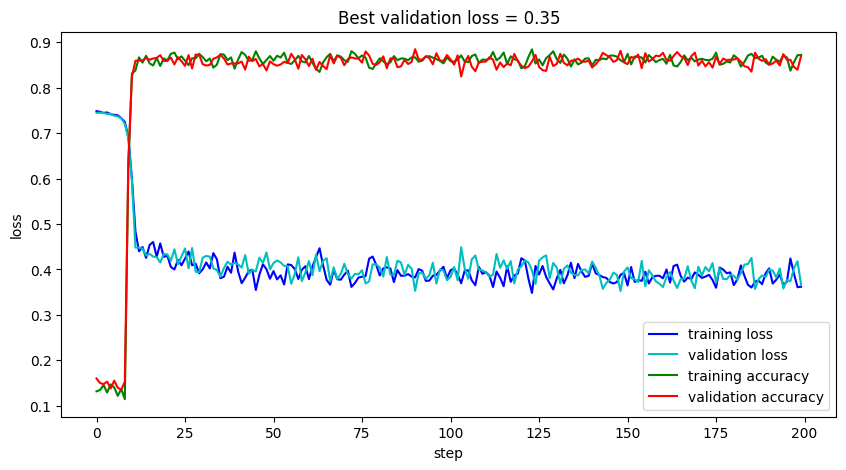

In [ ]:
trainer.train_network(
    dataloader_train,
    dataloader_val,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs
)


Again, we will load the best model (the one that achieved the best validation loss during training) and inspect the results on the validation set:

In [ ]:
trainer_test = Trainer(network=unet_1, optimizer=None, loss_function=None, name='unet_1', batch_size=None)
trainer_test.load_best_network()

Note that during validation, we do not pad image borders with half the patch size with 0s as before. Because we use `same` padding for U-Net, the output should have the same size as the input. But there is an exception where the input size is not divisible by the maximum downsampling rate (in our baseline U-Net, it is 8 (three poolings and each of them divides the size by 2)). To force the output and input to have the same size, we pad the input to a shape that is divisible by 8, implemented by the ``pad_ensure_division`` function.

In [ ]:
def pad_ensure_division(h, w, division):

    def compute_pad(s, d):
        if s % d != 0:
            p = 0
            while True:
                if (s + p) % d == 0:
                    return p
                p += 1
        return 0

    py = compute_pad(h, division)
    px = compute_pad(w, division)
    padding = (py//2, py-py//2), (px//2, px-px//2)
    return padding

We also need to change the ``process_basic`` function a bit in order to process one image using U-Net. Remember you need to pad the image when its size cannot be divided by the total downsampling rate in your U-Net (in our baseline U-Net it is 8). This ensures that the output size and the input size of the U-Net model are always the same.

In [ ]:
def process_unet(trainer: "Trainer", dataset: "DataSet"):
    imgs = np.array(dataset.imgs) / 255.
    lbls = np.array(dataset.lbls) > 0
    msks = np.array(dataset.msks) > 0

    # pad image if the size is not divisable by total downsampling rate in your U-Net
    # YOUR CODE HERE
    padding = pad_ensure_division(imgs.shape[1],imgs.shape[2],8)
    pad_imgs = np.pad(imgs, ((0, 0), (padding[0][0], padding[0][1]), (padding[1][0], padding[1][1]), (0, 0)), mode='constant', constant_values=0)

    # run unet model
    pad_imgs = np.moveaxis(pad_imgs, -1, 1)
    output = trainer._predict_batch(torch.tensor(pad_imgs[None]).float())  # Do not modify this line
    output = output[0][:, None]  # Do not modify this line

    # don't forget to crop it back because you pad it before.
    b, dummy_dim, c, h, w = output.shape

    ### YOUR SOLUTION HERE


    # YOUR CODE HERE
    output = output[:, :, :, padding[0][0]:h-padding[0][1], padding[1][0]:w-padding[1][1]]

    return lbls, msks, output

In [ ]:
""" DO NOT MODIFY THIS CELL"""

' DO NOT MODIFY THIS CELL'

Now we run the best model on the validation images:

image 0 Dice score: 0.0


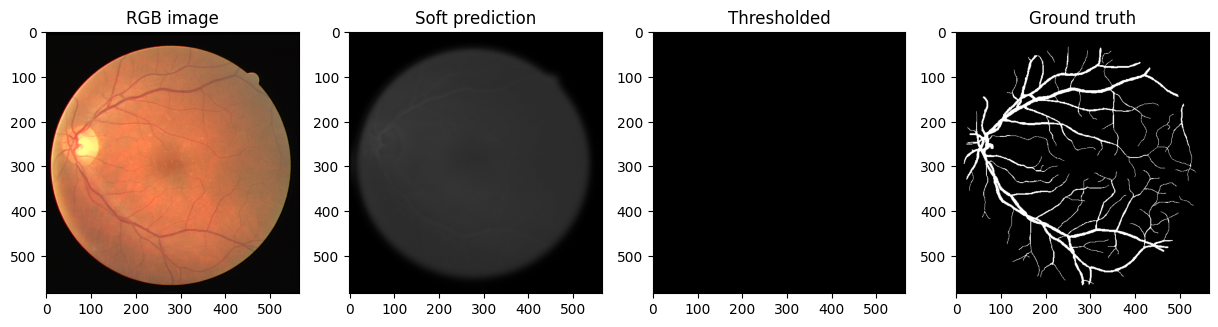

image 1 Dice score: 0.0


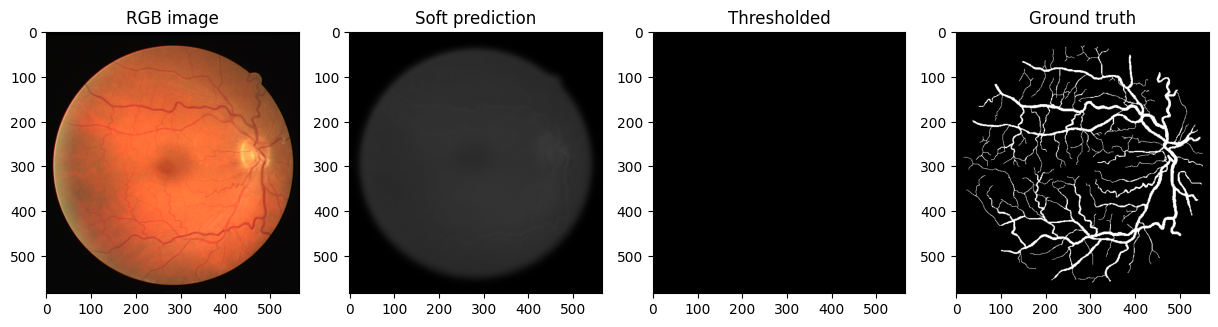

image 2 Dice score: 0.0


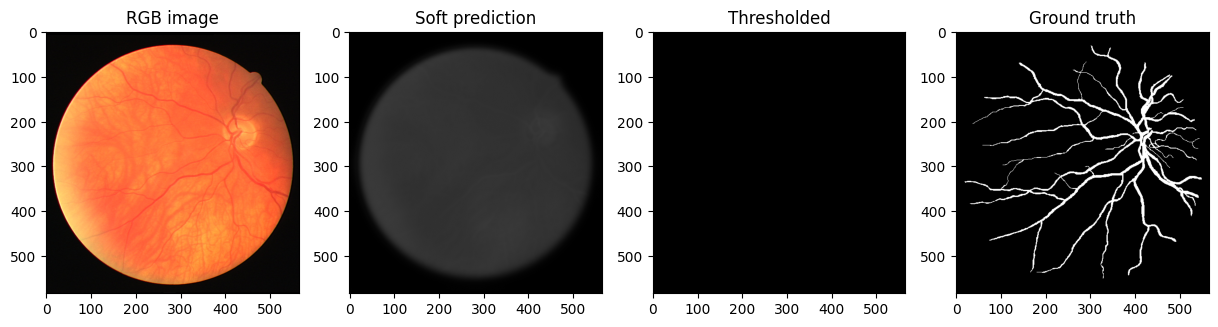

image 3 Dice score: 0.0


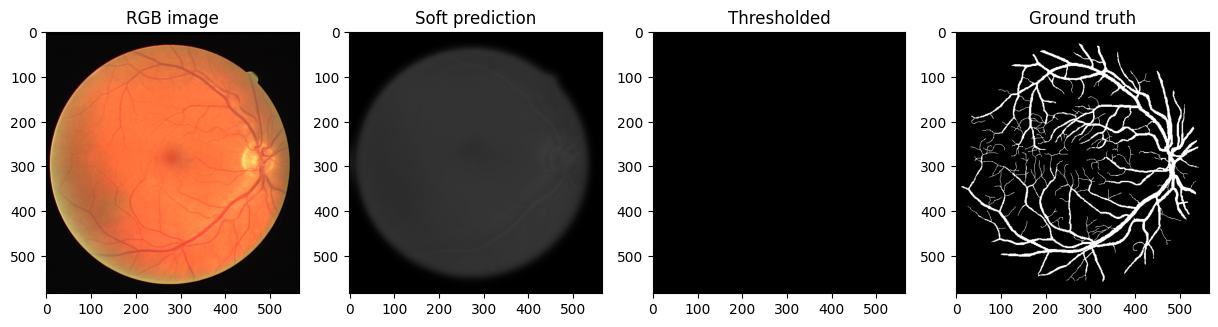

mean dice 0.0


In [ ]:
lbls, msks, output = process_unet(trainer_test, validation_data)
check_results(validation_data.imgs, lbls, msks, output)

## Improve the U-Net implementation to increase performance

You have realized that this baseline model does not perform well. Now, it is time to boost performance. These are different ideas:
- You can adjust the activation function, e.g. to `LeakyReLU`.
- You can adjust the different training hyperparameters (learning rate, mini-batch size, etc.).
- You can change the number of filters per layer by passing a different input parameter ``initial_filters`` (default = 16) to ``UNet2()`` (to be built by you!), and experiment with the effect of using a wider U-Net model.
- You can make use of different techniques seen during the lessons (batch normalization, dropout, etc).
- You can add class weights in your loss function for balancing positive and negative classses (last optional task).


Make an instance of the ``UNet2`` model and initialize all required training parameters.

In [ ]:
# YOUR CODE HERE

In [ ]:
class UNet2(nn.Module):
    def __init__(
        self,
        initial_filters: int = 16,
        n_classes: int = 2,
        batchnorm: bool = False,
        dropout: Optional[float] = None,
        activation_function: nn.Module = nn.ReLU(),
    ):
        super(UNet2, self).__init__()
        self.initial_filters = initial_filters
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.activation_function = activation_function

        # Encoder
        self.c1 = self.conv_block(3, initial_filters)
        self.p1 = nn.MaxPool2d(kernel_size=2)
        self.c2 = self.conv_block(initial_filters, initial_filters * 2)
        self.p2 = nn.MaxPool2d(kernel_size=2)
        self.c3 = self.conv_block(initial_filters * 2, initial_filters * 4)
        self.p3 = nn.MaxPool2d(kernel_size=2)
        self.c4 = self.conv_block(initial_filters * 4, initial_filters * 8)

        # Decoder
        self.u2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.cm2 = self.conv_block(initial_filters * 8 + initial_filters * 4, initial_filters * 4)
        self.u3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.cm3 = self.conv_block(initial_filters * 4 + initial_filters * 2, initial_filters * 2)
        self.u4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.cm4 = self.conv_block(initial_filters * 2 + initial_filters, initial_filters)

        # Output layer
        self.predictions = nn.Conv2d(initial_filters, n_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        if self.batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation_function)
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        if self.batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation_function)
        if self.dropout:
            layers.append(nn.Dropout(self.dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Encoder path
        x1 = self.c1(x)
        p1 = self.p1(x1)
        x2 = self.c2(p1)
        p2 = self.p2(x2)
        x3 = self.c3(p2)
        p3 = self.p3(x3)
        x4 = self.c4(p3)

        # Decoder path
        u2 = self.u2(x4)
        cat2 = torch.cat((x3, u2), dim=1)
        x5 = self.cm2(cat2)
        u3 = self.u3(x5)
        cat3 = torch.cat((x2, u3), dim=1)
        x6 = self.cm3(cat3)
        u4 = self.u4(x6)
        cat4 = torch.cat((x1, u4), dim=1)
        x7 = self.cm4(cat4)

        predictions = self.predictions(x7)
        return predictions

Make an instance of the ``UNet2`` model and initialize all required training parameters.

In [ ]:
learning_rate = None
patch_size = (None, None)
batch_size = None
steps_per_epoch = None
epochs = None
initial_filters = None
batchnorm = None
dropout = None
activation_function = None

# YOUR CODE HERE
learning_rate = 1e-4          # Increased learning rate compared to baseline 1e-5
patch_size = (128, 128)       # Slightly larger patches
batch_size = 16               # Adjusted mini-batch size
steps_per_epoch = 50          # Increase steps per epoch
epochs = 100                  # Adjust number of epochs
initial_filters = 32          # Wider U-Net by starting with more filters
batchnorm = True              # Enable batch normalization for faster convergence
dropout = 0.1                 # Apply dropout to reduce overfitting
activation_function = nn.LeakyReLU(negative_slope=0.1)  # Use LeakyReLU instead of ReLU

unet_2 = UNet2(
    initial_filters=initial_filters,
    n_classes=2,
    batchnorm=batchnorm,
    dropout=dropout,
    activation_function=activation_function,
)
optimizer_4 = torch.optim.Adam(unet_2.parameters(), lr=learning_rate)
print(unet_2)
print(f"Number of parameters: {count_params(unet_2)}")

UNet2(
  (activation_function): LeakyReLU(negative_slope=0.1)
  (c1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Dropout(p=0.1, inplace=False)
  )
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
'''DO NOT MODIFY THIS CELL'''

'DO NOT MODIFY THIS CELL'

Train your new U-Net model:

In [ ]:
patch_extractor_train = PatchExtractor(patch_size=patch_size, horizontal_flipping=True)
patch_dataset_train = UNetPatchDataset(patch_extractor=patch_extractor_train, dataset=train_data, border_pad_size=patch_extractor_train.patch_size, batch_size=batch_size)
dataloader_train = torch.utils.data.DataLoader(patch_dataset_train, batch_size)
patch_extractor_val = PatchExtractor(patch_size=patch_size, horizontal_flipping=False)
patch_dataset_val = UNetPatchDataset(patch_extractor=patch_extractor_val, dataset=validation_data, border_pad_size=patch_size, batch_size=batch_size)
dataloader_val = torch.utils.data.DataLoader(patch_dataset_val, batch_size)

# define the trainer
trainer = Trainer(
    network=unet_2,
    optimizer=optimizer_4,
    loss_function=loss_function,
    name='unet_2',
    batch_size=batch_size,
)

# Perform an evaluation pass (of the randomly initialized network, to see if everything is working)
loss, accuracy = trainer.validate_dataset(dataloader_val)
print(f"validation loss {loss}, validation accuracy {accuracy}")


validation loss 0.6714195609092712, validation accuracy 0.8472480773925781


Epochs:   1%|          | 1/100 [00:04<07:03,  4.28s/it]

Epoch 0: train loss: 0.44359058141708374, train accuracy: 0.8765754699707031, val loss: 0.4592353105545044, val accuracy: 0.9037513732910156


Epochs:   2%|▏         | 2/100 [00:08<06:59,  4.28s/it]

Epoch 1: train loss: 0.3726861774921417, train accuracy: 0.9021415710449219, val loss: 0.3546208143234253, val accuracy: 0.9389533996582031


Epochs:   3%|▎         | 3/100 [00:12<06:53,  4.26s/it]

Epoch 2: train loss: 0.3083342909812927, train accuracy: 0.9403152465820312, val loss: 0.31901878118515015, val accuracy: 0.9440193176269531


Epochs:   4%|▍         | 4/100 [00:16<06:46,  4.23s/it]

Epoch 3: train loss: 0.30275553464889526, train accuracy: 0.9372787475585938, val loss: 0.3059079051017761, val accuracy: 0.9350967407226562


Epochs:   5%|▌         | 5/100 [00:21<06:35,  4.17s/it]

Epoch 4: train loss: 0.2918736934661865, train accuracy: 0.9316291809082031, val loss: 0.2662402391433716, val accuracy: 0.9449653625488281


Epochs:   6%|▌         | 6/100 [00:25<06:26,  4.12s/it]

Epoch 5: train loss: 0.2594381868839264, train accuracy: 0.9361648559570312, val loss: 0.2559262812137604, val accuracy: 0.941864013671875


Epochs:   7%|▋         | 7/100 [00:29<06:18,  4.08s/it]

Epoch 6: train loss: 0.23475687205791473, train accuracy: 0.9472579956054688, val loss: 0.253484845161438, val accuracy: 0.93292236328125


Epochs:   8%|▊         | 8/100 [00:33<06:11,  4.04s/it]

Epoch 7: train loss: 0.229261577129364, train accuracy: 0.9452095031738281, val loss: 0.24268069863319397, val accuracy: 0.9383735656738281


Epochs:   9%|▉         | 9/100 [00:36<06:05,  4.01s/it]

Epoch 8: train loss: 0.21931013464927673, train accuracy: 0.9455375671386719, val loss: 0.21821363270282745, val accuracy: 0.9440345764160156


Epochs:  10%|█         | 10/100 [00:40<05:58,  3.98s/it]

Epoch 9: train loss: 0.24361538887023926, train accuracy: 0.9271583557128906, val loss: 0.22271525859832764, val accuracy: 0.9428787231445312


Epochs:  11%|█         | 11/100 [00:44<05:53,  3.97s/it]

Epoch 10: train loss: 0.19282247126102448, train accuracy: 0.953582763671875, val loss: 0.2065163254737854, val accuracy: 0.9454193115234375


Epochs:  12%|█▏        | 12/100 [00:48<05:48,  3.96s/it]

Epoch 11: train loss: 0.1939762681722641, train accuracy: 0.9465065002441406, val loss: 0.19495713710784912, val accuracy: 0.9455032348632812


Epochs:  13%|█▎        | 13/100 [00:52<05:43,  3.95s/it]

Epoch 12: train loss: 0.17452013492584229, train accuracy: 0.9567527770996094, val loss: 0.1901622861623764, val accuracy: 0.9456329345703125


Epochs:  14%|█▍        | 14/100 [00:56<05:40,  3.96s/it]

Epoch 13: train loss: 0.16320843994617462, train accuracy: 0.9586334228515625, val loss: 0.17972084879875183, val accuracy: 0.9474258422851562


Epochs:  15%|█▌        | 15/100 [01:00<05:35,  3.94s/it]

Epoch 14: train loss: 0.17091289162635803, train accuracy: 0.9505386352539062, val loss: 0.18231403827667236, val accuracy: 0.945068359375


Epochs:  16%|█▌        | 16/100 [01:04<05:31,  3.94s/it]

Epoch 15: train loss: 0.15968671441078186, train accuracy: 0.9540290832519531, val loss: 0.16798356175422668, val accuracy: 0.9516716003417969


Epochs:  17%|█▋        | 17/100 [01:08<05:27,  3.94s/it]

Epoch 16: train loss: 0.1610567271709442, train accuracy: 0.9516487121582031, val loss: 0.16002531349658966, val accuracy: 0.9522285461425781


Epochs:  18%|█▊        | 18/100 [01:12<05:22,  3.93s/it]

Epoch 17: train loss: 0.14657527208328247, train accuracy: 0.9574699401855469, val loss: 0.16750885546207428, val accuracy: 0.9459571838378906


Epochs:  19%|█▉        | 19/100 [01:16<05:25,  4.02s/it]

Epoch 18: train loss: 0.15110492706298828, train accuracy: 0.9522590637207031, val loss: 0.14517098665237427, val accuracy: 0.9563560485839844


Epochs:  20%|██        | 20/100 [01:20<05:19,  4.00s/it]

Epoch 19: train loss: 0.14186957478523254, train accuracy: 0.9564743041992188, val loss: 0.1566067636013031, val accuracy: 0.9490585327148438


Epochs:  21%|██        | 21/100 [01:24<05:14,  3.99s/it]

Epoch 20: train loss: 0.1633276343345642, train accuracy: 0.9442481994628906, val loss: 0.14376914501190186, val accuracy: 0.9564666748046875


Epochs:  22%|██▏       | 22/100 [01:28<05:11,  3.99s/it]

Epoch 21: train loss: 0.14171633124351501, train accuracy: 0.9552421569824219, val loss: 0.14021514356136322, val accuracy: 0.9553298950195312


Epochs:  23%|██▎       | 23/100 [01:32<05:06,  3.98s/it]

Epoch 22: train loss: 0.13137055933475494, train accuracy: 0.956878662109375, val loss: 0.14867910742759705, val accuracy: 0.9500541687011719


Epochs:  24%|██▍       | 24/100 [01:36<05:01,  3.97s/it]

Epoch 23: train loss: 0.13765662908554077, train accuracy: 0.9539642333984375, val loss: 0.14452588558197021, val accuracy: 0.9495162963867188


Epochs:  25%|██▌       | 25/100 [01:40<04:57,  3.97s/it]

Epoch 24: train loss: 0.1474161148071289, train accuracy: 0.9509773254394531, val loss: 0.14190755784511566, val accuracy: 0.9507789611816406


Epochs:  26%|██▌       | 26/100 [01:44<04:53,  3.97s/it]

Epoch 25: train loss: 0.1336011290550232, train accuracy: 0.9536514282226562, val loss: 0.13342949748039246, val accuracy: 0.9542655944824219


Epochs:  27%|██▋       | 27/100 [01:48<04:49,  3.97s/it]

Epoch 26: train loss: 0.11539898812770844, train accuracy: 0.9616966247558594, val loss: 0.1227148175239563, val accuracy: 0.9594192504882812


Epochs:  28%|██▊       | 28/100 [01:52<04:45,  3.97s/it]

Epoch 27: train loss: 0.11544767022132874, train accuracy: 0.9597129821777344, val loss: 0.1505129486322403, val accuracy: 0.9456253051757812


Epochs:  29%|██▉       | 29/100 [01:56<04:41,  3.96s/it]

Epoch 28: train loss: 0.12799595296382904, train accuracy: 0.9555015563964844, val loss: 0.12338511645793915, val accuracy: 0.9560432434082031


Epochs:  30%|███       | 30/100 [02:00<04:36,  3.95s/it]

Epoch 29: train loss: 0.13030791282653809, train accuracy: 0.953125, val loss: 0.15495610237121582, val accuracy: 0.9438629150390625


Epochs:  31%|███       | 31/100 [02:04<04:32,  3.95s/it]

Epoch 30: train loss: 0.1319425255060196, train accuracy: 0.9540176391601562, val loss: 0.13423198461532593, val accuracy: 0.9494781494140625


Epochs:  32%|███▏      | 32/100 [02:08<04:27,  3.94s/it]

Epoch 31: train loss: 0.11234152317047119, train accuracy: 0.9599266052246094, val loss: 0.12982535362243652, val accuracy: 0.9521331787109375


Epochs:  33%|███▎      | 33/100 [02:11<04:23,  3.94s/it]

Epoch 32: train loss: 0.1161818578839302, train accuracy: 0.9574699401855469, val loss: 0.12596744298934937, val accuracy: 0.9531440734863281


Epochs:  34%|███▍      | 34/100 [02:15<04:19,  3.93s/it]

Epoch 33: train loss: 0.11391085386276245, train accuracy: 0.9598464965820312, val loss: 0.1305234730243683, val accuracy: 0.9520492553710938


Epochs:  35%|███▌      | 35/100 [02:19<04:15,  3.93s/it]

Epoch 34: train loss: 0.11396495997905731, train accuracy: 0.9580535888671875, val loss: 0.16303762793540955, val accuracy: 0.9391365051269531


Epochs:  36%|███▌      | 36/100 [02:23<04:12,  3.94s/it]

Epoch 35: train loss: 0.10594819486141205, train accuracy: 0.9610252380371094, val loss: 0.11609695106744766, val accuracy: 0.9588127136230469


Epochs:  37%|███▋      | 37/100 [02:27<04:08,  3.94s/it]

Epoch 36: train loss: 0.12801021337509155, train accuracy: 0.9518165588378906, val loss: 0.11607314646244049, val accuracy: 0.959136962890625


Epochs:  38%|███▊      | 38/100 [02:31<04:04,  3.94s/it]

Epoch 37: train loss: 0.1086832657456398, train accuracy: 0.9603958129882812, val loss: 0.14289754629135132, val accuracy: 0.9464111328125


Epochs:  39%|███▉      | 39/100 [02:35<04:00,  3.94s/it]

Epoch 38: train loss: 0.12129200249910355, train accuracy: 0.9533958435058594, val loss: 0.1275893598794937, val accuracy: 0.9518280029296875


Epochs:  40%|████      | 40/100 [02:39<03:56,  3.94s/it]

Epoch 39: train loss: 0.11491665989160538, train accuracy: 0.9564476013183594, val loss: 0.12420119345188141, val accuracy: 0.9518890380859375


Epochs:  41%|████      | 41/100 [02:43<03:52,  3.94s/it]

Epoch 40: train loss: 0.09571963548660278, train accuracy: 0.9648704528808594, val loss: 0.13210409879684448, val accuracy: 0.9491958618164062


Epochs:  42%|████▏     | 42/100 [02:47<03:48,  3.94s/it]

Epoch 41: train loss: 0.10667382925748825, train accuracy: 0.9606704711914062, val loss: 0.12871137261390686, val accuracy: 0.9503517150878906


Epochs:  43%|████▎     | 43/100 [02:51<03:44,  3.94s/it]

Epoch 42: train loss: 0.10611593723297119, train accuracy: 0.9587440490722656, val loss: 0.1367451399564743, val accuracy: 0.948974609375


Epochs:  44%|████▍     | 44/100 [02:55<03:45,  4.03s/it]

Epoch 43: train loss: 0.09739609062671661, train accuracy: 0.9644622802734375, val loss: 0.12080620229244232, val accuracy: 0.9544105529785156


Epochs:  45%|████▌     | 45/100 [02:59<03:40,  4.01s/it]

Epoch 44: train loss: 0.11647927016019821, train accuracy: 0.9564704895019531, val loss: 0.1223372146487236, val accuracy: 0.9532394409179688


Epochs:  46%|████▌     | 46/100 [03:03<03:35,  3.99s/it]

Epoch 45: train loss: 0.0866973027586937, train accuracy: 0.9680252075195312, val loss: 0.1256992518901825, val accuracy: 0.9519615173339844


Epochs:  47%|████▋     | 47/100 [03:07<03:31,  3.99s/it]

Epoch 46: train loss: 0.10029879212379456, train accuracy: 0.9624900817871094, val loss: 0.1402311623096466, val accuracy: 0.9477310180664062


Epochs:  48%|████▊     | 48/100 [03:11<03:26,  3.98s/it]

Epoch 47: train loss: 0.09916828572750092, train accuracy: 0.962005615234375, val loss: 0.13989193737506866, val accuracy: 0.9453697204589844


Epochs:  49%|████▉     | 49/100 [03:15<03:22,  3.96s/it]

Epoch 48: train loss: 0.11158052086830139, train accuracy: 0.9569015502929688, val loss: 0.12502560019493103, val accuracy: 0.9516487121582031


Epochs:  50%|█████     | 50/100 [03:19<03:18,  3.97s/it]

Epoch 49: train loss: 0.09820081293582916, train accuracy: 0.9615974426269531, val loss: 0.11026154458522797, val accuracy: 0.9566421508789062


Epochs:  51%|█████     | 51/100 [03:23<03:14,  3.97s/it]

Epoch 50: train loss: 0.1000300794839859, train accuracy: 0.9606781005859375, val loss: 0.10834486782550812, val accuracy: 0.9586677551269531


Epochs:  52%|█████▏    | 52/100 [03:27<03:10,  3.96s/it]

Epoch 51: train loss: 0.09571246057748795, train accuracy: 0.9626121520996094, val loss: 0.14999249577522278, val accuracy: 0.9445571899414062


Epochs:  53%|█████▎    | 53/100 [03:31<03:05,  3.95s/it]

Epoch 52: train loss: 0.09605030715465546, train accuracy: 0.9627685546875, val loss: 0.11969847977161407, val accuracy: 0.9558372497558594


Epochs:  54%|█████▍    | 54/100 [03:35<03:01,  3.95s/it]

Epoch 53: train loss: 0.1068149209022522, train accuracy: 0.9574241638183594, val loss: 0.12186909466981888, val accuracy: 0.9522857666015625


Epochs:  55%|█████▌    | 55/100 [03:39<02:57,  3.95s/it]

Epoch 54: train loss: 0.1001221239566803, train accuracy: 0.9611358642578125, val loss: 0.1354748010635376, val accuracy: 0.949310302734375


Epochs:  56%|█████▌    | 56/100 [03:42<02:53,  3.94s/it]

Epoch 55: train loss: 0.09506754577159882, train accuracy: 0.9636993408203125, val loss: 0.12148578464984894, val accuracy: 0.9535064697265625


Epochs:  57%|█████▋    | 57/100 [03:46<02:50,  3.95s/it]

Epoch 56: train loss: 0.10737696290016174, train accuracy: 0.9573936462402344, val loss: 0.10197331011295319, val accuracy: 0.9608726501464844


Epochs:  58%|█████▊    | 58/100 [03:50<02:45,  3.95s/it]

Epoch 57: train loss: 0.0829608365893364, train accuracy: 0.9672164916992188, val loss: 0.13438928127288818, val accuracy: 0.949798583984375


Epochs:  59%|█████▉    | 59/100 [03:54<02:41,  3.94s/it]

Epoch 58: train loss: 0.09439995884895325, train accuracy: 0.9630699157714844, val loss: 0.1337798535823822, val accuracy: 0.9483261108398438


Epochs:  60%|██████    | 60/100 [03:58<02:37,  3.94s/it]

Epoch 59: train loss: 0.09110869467258453, train accuracy: 0.9647102355957031, val loss: 0.13508421182632446, val accuracy: 0.9486312866210938


Epochs:  61%|██████    | 61/100 [04:02<02:33,  3.94s/it]

Epoch 60: train loss: 0.09822307527065277, train accuracy: 0.9616012573242188, val loss: 0.13227351009845734, val accuracy: 0.9498367309570312


Epochs:  62%|██████▏   | 62/100 [04:06<02:29,  3.94s/it]

Epoch 61: train loss: 0.08608539402484894, train accuracy: 0.9660606384277344, val loss: 0.10074970126152039, val accuracy: 0.9624557495117188


Epochs:  63%|██████▎   | 63/100 [04:10<02:25,  3.94s/it]

Epoch 62: train loss: 0.08772441744804382, train accuracy: 0.9649772644042969, val loss: 0.1232001930475235, val accuracy: 0.9514579772949219


Epochs:  64%|██████▍   | 64/100 [04:14<02:21,  3.93s/it]

Epoch 63: train loss: 0.08357395231723785, train accuracy: 0.9664459228515625, val loss: 0.15051880478858948, val accuracy: 0.9456863403320312


Epochs:  65%|██████▌   | 65/100 [04:18<02:17,  3.93s/it]

Epoch 64: train loss: 0.0948861837387085, train accuracy: 0.9619026184082031, val loss: 0.11553651839494705, val accuracy: 0.9551849365234375


Epochs:  66%|██████▌   | 66/100 [04:22<02:13,  3.93s/it]

Epoch 65: train loss: 0.09751302003860474, train accuracy: 0.9607162475585938, val loss: 0.11899598687887192, val accuracy: 0.9542083740234375


Epochs:  67%|██████▋   | 67/100 [04:26<02:09,  3.93s/it]

Epoch 66: train loss: 0.08655066043138504, train accuracy: 0.9656181335449219, val loss: 0.1168280839920044, val accuracy: 0.9532051086425781


Epochs:  68%|██████▊   | 68/100 [04:30<02:05,  3.93s/it]

Epoch 67: train loss: 0.0889800637960434, train accuracy: 0.9643707275390625, val loss: 0.11929527670145035, val accuracy: 0.9531745910644531


Epochs:  69%|██████▉   | 69/100 [04:34<02:01,  3.93s/it]

Epoch 68: train loss: 0.09660352766513824, train accuracy: 0.9609870910644531, val loss: 0.12420636415481567, val accuracy: 0.9538383483886719


Epochs:  70%|███████   | 70/100 [04:38<01:57,  3.93s/it]

Epoch 69: train loss: 0.09788846969604492, train accuracy: 0.9605674743652344, val loss: 0.12166963517665863, val accuracy: 0.9531936645507812


Epochs:  71%|███████   | 71/100 [04:42<01:54,  3.94s/it]

Epoch 70: train loss: 0.07374222576618195, train accuracy: 0.9704017639160156, val loss: 0.08584665507078171, val accuracy: 0.9665374755859375


Epochs:  72%|███████▏  | 72/100 [04:45<01:50,  3.93s/it]

Epoch 71: train loss: 0.0912836417555809, train accuracy: 0.9632301330566406, val loss: 0.12130565941333771, val accuracy: 0.9530487060546875


Epochs:  73%|███████▎  | 73/100 [04:49<01:46,  3.93s/it]

Epoch 72: train loss: 0.09458666294813156, train accuracy: 0.9623565673828125, val loss: 0.1268254518508911, val accuracy: 0.9525184631347656


Epochs:  74%|███████▍  | 74/100 [04:53<01:42,  3.93s/it]

Epoch 73: train loss: 0.08496163785457611, train accuracy: 0.9664306640625, val loss: 0.13564977049827576, val accuracy: 0.9444427490234375


Epochs:  75%|███████▌  | 75/100 [04:57<01:38,  3.93s/it]

Epoch 74: train loss: 0.08515810966491699, train accuracy: 0.96624755859375, val loss: 0.11931335926055908, val accuracy: 0.9546737670898438


Epochs:  76%|███████▌  | 76/100 [05:01<01:34,  3.93s/it]

Epoch 75: train loss: 0.10046636313199997, train accuracy: 0.9592857360839844, val loss: 0.1392727643251419, val accuracy: 0.9488983154296875


Epochs:  77%|███████▋  | 77/100 [05:05<01:30,  3.92s/it]

Epoch 76: train loss: 0.09678240120410919, train accuracy: 0.9606285095214844, val loss: 0.11329556256532669, val accuracy: 0.9574508666992188


Epochs:  78%|███████▊  | 78/100 [05:09<01:26,  3.92s/it]

Epoch 77: train loss: 0.07667820155620575, train accuracy: 0.9688262939453125, val loss: 0.12544885277748108, val accuracy: 0.9540061950683594


Epochs:  79%|███████▉  | 79/100 [05:13<01:22,  3.93s/it]

Epoch 78: train loss: 0.08743596822023392, train accuracy: 0.963958740234375, val loss: 0.11121232062578201, val accuracy: 0.9545211791992188


Epochs:  80%|████████  | 80/100 [05:17<01:18,  3.93s/it]

Epoch 79: train loss: 0.09253178536891937, train accuracy: 0.9616127014160156, val loss: 0.09865757822990417, val accuracy: 0.9621772766113281


Epochs:  81%|████████  | 81/100 [05:21<01:14,  3.93s/it]

Epoch 80: train loss: 0.07714404165744781, train accuracy: 0.9686050415039062, val loss: 0.14167988300323486, val accuracy: 0.9480781555175781


Epochs:  82%|████████▏ | 82/100 [05:25<01:10,  3.93s/it]

Epoch 81: train loss: 0.08832070976495743, train accuracy: 0.96392822265625, val loss: 0.12010030448436737, val accuracy: 0.9551544189453125


Epochs:  83%|████████▎ | 83/100 [05:29<01:06,  3.93s/it]

Epoch 82: train loss: 0.08425505459308624, train accuracy: 0.9658164978027344, val loss: 0.10707792639732361, val accuracy: 0.9587554931640625


Epochs:  84%|████████▍ | 84/100 [05:33<01:02,  3.93s/it]

Epoch 83: train loss: 0.07989232242107391, train accuracy: 0.96795654296875, val loss: 0.12441985309123993, val accuracy: 0.9522933959960938


Epochs:  85%|████████▌ | 85/100 [05:36<00:58,  3.93s/it]

Epoch 84: train loss: 0.07715936005115509, train accuracy: 0.9686393737792969, val loss: 0.11674527078866959, val accuracy: 0.9539566040039062


Epochs:  86%|████████▌ | 86/100 [05:40<00:55,  3.93s/it]

Epoch 85: train loss: 0.07823769748210907, train accuracy: 0.96734619140625, val loss: 0.11367860436439514, val accuracy: 0.9578514099121094


Epochs:  87%|████████▋ | 87/100 [05:44<00:51,  3.93s/it]

Epoch 86: train loss: 0.08684337139129639, train accuracy: 0.9644241333007812, val loss: 0.15177659690380096, val accuracy: 0.9454116821289062


Epochs:  88%|████████▊ | 88/100 [05:48<00:47,  3.93s/it]

Epoch 87: train loss: 0.08513837307691574, train accuracy: 0.9648399353027344, val loss: 0.12589234113693237, val accuracy: 0.9525566101074219


Epochs:  89%|████████▉ | 89/100 [05:52<00:43,  3.93s/it]

Epoch 88: train loss: 0.08764000236988068, train accuracy: 0.9631996154785156, val loss: 0.12111025303602219, val accuracy: 0.95721435546875


Epochs:  90%|█████████ | 90/100 [05:56<00:39,  3.93s/it]

Epoch 89: train loss: 0.07931661605834961, train accuracy: 0.9670867919921875, val loss: 0.11855970323085785, val accuracy: 0.9537315368652344


Epochs:  91%|█████████ | 91/100 [06:00<00:35,  3.93s/it]

Epoch 90: train loss: 0.08455562591552734, train accuracy: 0.9645004272460938, val loss: 0.13004863262176514, val accuracy: 0.95184326171875


Epochs:  92%|█████████▏| 92/100 [06:04<00:31,  3.93s/it]

Epoch 91: train loss: 0.08939886093139648, train accuracy: 0.9635543823242188, val loss: 0.11794663220643997, val accuracy: 0.9557952880859375


Epochs:  93%|█████████▎| 93/100 [06:08<00:27,  3.93s/it]

Epoch 92: train loss: 0.08389083296060562, train accuracy: 0.9651908874511719, val loss: 0.10777781158685684, val accuracy: 0.9583396911621094


Epochs:  94%|█████████▍| 94/100 [06:12<00:23,  3.93s/it]

Epoch 93: train loss: 0.07143128663301468, train accuracy: 0.97088623046875, val loss: 0.13659770786762238, val accuracy: 0.9522666931152344


Epochs:  95%|█████████▌| 95/100 [06:16<00:19,  3.93s/it]

Epoch 94: train loss: 0.08455665409564972, train accuracy: 0.9660110473632812, val loss: 0.13661563396453857, val accuracy: 0.9496383666992188


Epochs:  96%|█████████▌| 96/100 [06:20<00:15,  3.93s/it]

Epoch 95: train loss: 0.08129691332578659, train accuracy: 0.9668464660644531, val loss: 0.12625864148139954, val accuracy: 0.9529876708984375


Epochs:  97%|█████████▋| 97/100 [06:24<00:11,  3.93s/it]

Epoch 96: train loss: 0.08234068006277084, train accuracy: 0.9665946960449219, val loss: 0.11935785412788391, val accuracy: 0.9562263488769531


Epochs:  98%|█████████▊| 98/100 [06:28<00:07,  3.93s/it]

Epoch 97: train loss: 0.08429016172885895, train accuracy: 0.965545654296875, val loss: 0.11399619281291962, val accuracy: 0.960052490234375


Epochs:  99%|█████████▉| 99/100 [06:32<00:03,  3.93s/it]

Epoch 98: train loss: 0.07364334911108017, train accuracy: 0.9699974060058594, val loss: 0.1273517608642578, val accuracy: 0.9526634216308594


Epoch 99: train loss: 0.07310844212770462, train accuracy: 0.9697227478027344, val loss: 0.13044393062591553, val accuracy: 0.9532203674316406


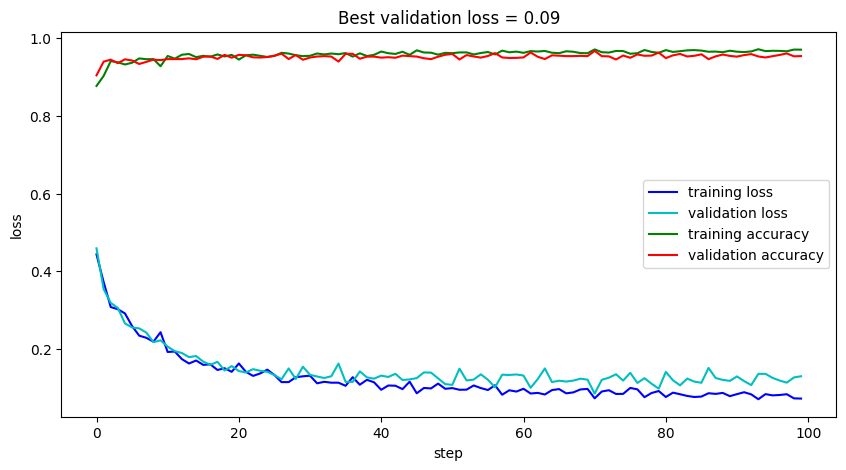

In [ ]:
trainer.train_network(
    dataloader_train,
    dataloader_val,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs
)

Run the best  model on the validation images:

image 0 Dice score: 0.8382346926254652


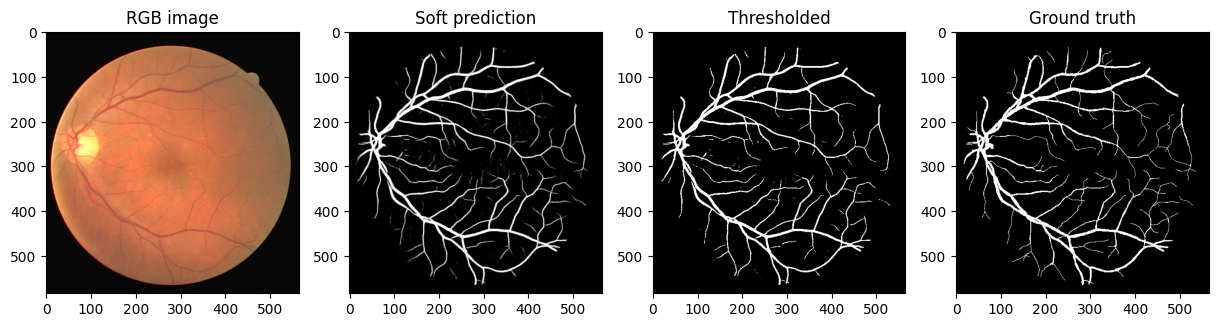

image 1 Dice score: 0.7962936411212274


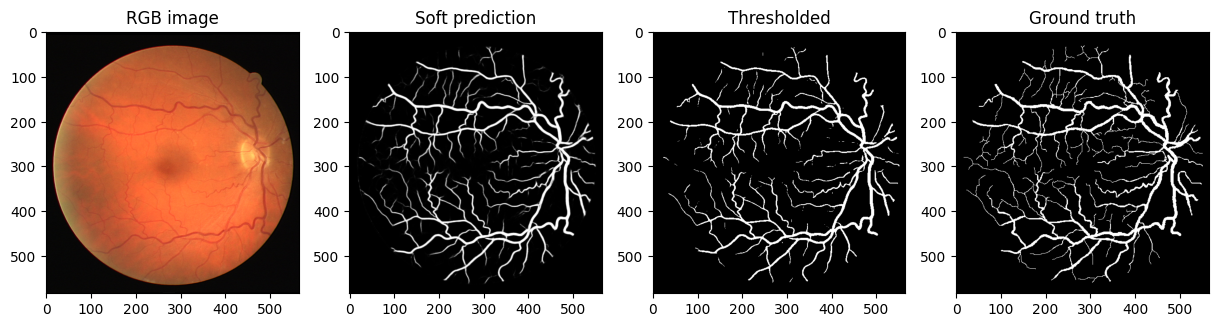

image 2 Dice score: 0.7640573572398555


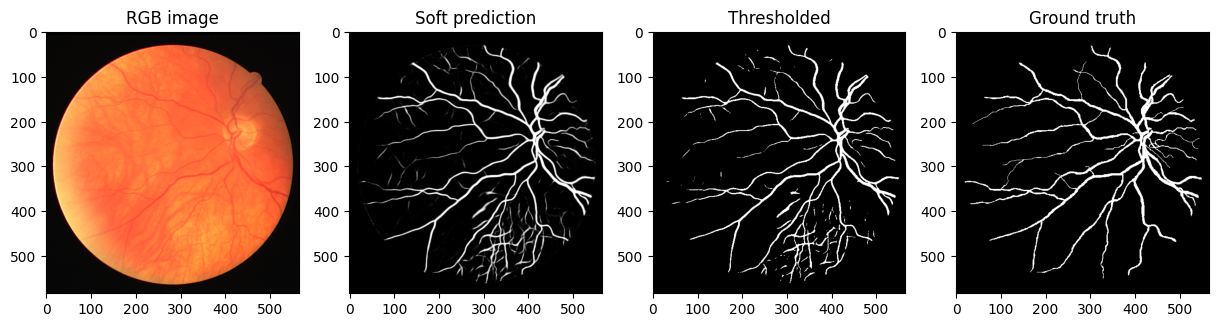

image 3 Dice score: 0.8075864721720862


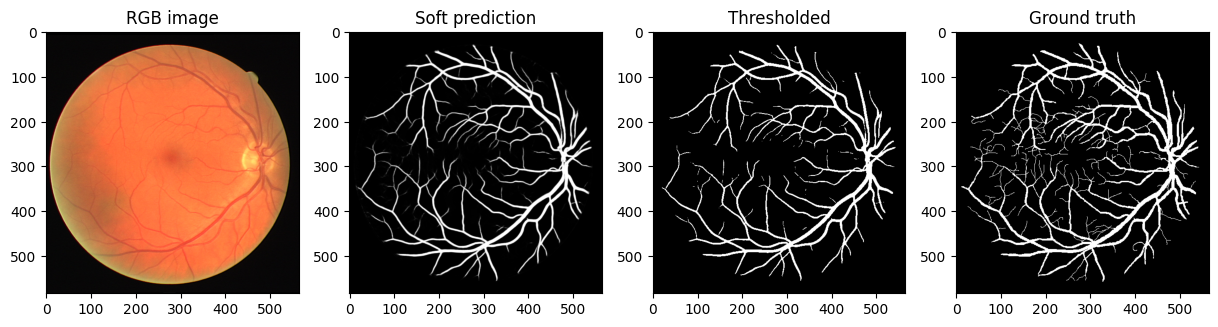

mean dice 0.8015430407896584


In [ ]:
trainer_test = Trainer(network=unet_2, optimizer=None, loss_function=None, name='unet_2', batch_size=None)
trainer_test.load_best_network()

lbls, msks, output = process_unet(trainer_test, validation_data)
check_results(validation_data.imgs, lbls, msks, output)
